In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/grand-final/PAST_BEHAVIOR.csv
/kaggle/input/grand-final/contract_train.csv
/kaggle/input/grand-final/CONTRACT.csv
/kaggle/input/grand-final/CUSTOMER.csv
/kaggle/input/grand-final/contract_test.csv
/kaggle/input/grand-final/LEADS.csv
/kaggle/input/grand-final/SHOP.csv
/kaggle/input/grand-final/EMPLOYEE.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np 


In [3]:
contract = pd.read_csv(r'/kaggle/input/grand-final/CONTRACT.csv')
# customer = pd.read_csv(r'/kaggle/input/grand-final/CUSTOMER.csv', low_memory=False)
# employee = pd.read_csv(r'/kaggle/input/grand-final/EMPLOYEE.csv', dtype = {'CODE_EMPLOYEE':'object'})
lead = pd.read_csv(r'/kaggle/input/grand-final/LEADS.csv')
# past_behave = pd.read_csv(r'/kaggle/input/grand-final/PAST_BEHAVIOR.csv')
shop = pd.read_csv(r'/kaggle/input/grand-final/SHOP.csv')
# contract_test = pd.read_csv(r'/kaggle/input/grand-final/contract_test.csv')
# contract_train = pd.read_csv(r'/kaggle/input/grand-final/contract_train.csv')


In [3]:
customer = pd.read_csv(r'/kaggle/input/grand-final/CUSTOMER.csv', low_memory=False)
contract_test = pd.read_csv(r'/kaggle/input/grand-final/contract_test.csv')
contract_train = pd.read_csv(r'/kaggle/input/grand-final/contract_train.csv')

# PREPROCESSING

## Contract Table

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

histogram = [
    'NAME_EDUCATION_TYPE', 'CNT_CHILDREN', 'NAME_INCOME_TYPE', 'CODE_PROFESSION',
    'NAME_CREDIT_STATUS', 'PRODUCT', 'PAYMENT_NUM',
     'FIRST_DUE', 'SECOND_DUE', 'THIRD_DUE', 'FOURTH_DUE',
    'FLAG_INS', 'APPLY_EMPLOYEE_LEVEL', 'SIGN_EMPLOYEE_LEVEL'
]

all_numeric_cols = contract.select_dtypes(include=['int64', 'float64']).columns.tolist()[2:]

exclude_cols = histogram + ['AMT_INCOME_MAIN', 'AMT_INCOME_HOUSEHOLD']
boxplot_cols = [col for col in all_numeric_cols if col not in exclude_cols]

for col in boxplot_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=contract[col], color='#ed5f72')
    plt.title(f'Distribution of {col} BEFORE Preprocessing')
    plt.tight_layout()
    plt.show()



colors = ['#ed5f72', '#f1b599', '#5c090b', '#ff5757']

for col in histogram:
    if col in contract.columns:
        plt.figure(figsize=(8, 5))

        value_counts = contract[col].value_counts(dropna=False)
        num_categories = len(value_counts)

        # Repeat colors if there are more bars than colors
        bar_colors = (colors * (num_categories // len(colors) + 1))[:num_categories]

        value_counts.plot(kind='bar', color=bar_colors)

        plt.title(f'Distribution of {col} BEFORE Preprocessing')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


#=====Applying Employee=====

# Get employee counts
employee_counts = contract['APPLY_EMPLOYEE'].value_counts(dropna=False)

# Extract prefix using regex
prefixes = employee_counts.index.to_series().str.extract(r'^([A-Za-z]+)')[0]

# Create a dataframe: employee, count, and prefix
employee_prefix_df = pd.DataFrame({
    'employee': employee_counts.index,
    'count': employee_counts.values,
    'prefix': prefixes.fillna('Unknown')  # Label missing prefixes
})

# Group by prefix and sum contract counts
merged_prefix_counts = employee_prefix_df.groupby('prefix')['count'].sum().sort_values(ascending=False)

# Plot all prefixes (including "Unknown")
plt.figure(figsize=(14, 6))
sns.barplot(x=merged_prefix_counts.index[:25], y=merged_prefix_counts.values[:25], color = '#ed5f72')  # top 25
plt.title('Distribution of APPLY_EMPLOYEE by Prefix (including Unknown)')
plt.xlabel('Prefix')
plt.ylabel('Total Contracts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#=====AMT_INCOME_MAIN VS HOUSEHOLD=====
income_cols = ['AMT_INCOME_MAIN', 'AMT_INCOME_HOUSEHOLD']

income_bins = {
    'AMT_INCOME_MAIN': [0, 9e6, 20e6, 50e6, 100e6, 500e6, 1e9, float('inf')],
    'AMT_INCOME_HOUSEHOLD': [0, 9e6, 20e6, 50e6, 100e6, 500e6, 10e9, float('inf')]
}

def generate_labels(bins):
    labels = []
    for i in range(len(bins) - 1):
        lower = bins[i]
        upper = bins[i + 1]
        if upper == float('inf'):
            labels.append(f'>{lower / 1e6:.0f}M')
        else:
            labels.append(f'{lower / 1e6:.0f}–{upper / 1e6:.0f}M')
    return labels

income_labels = {
    col: generate_labels(income_bins[col]) for col in income_cols
}

for col in income_cols:
    print(f"\nAnalysis for column: {col}")

    zero_count = (contract[col] == 0).sum()
    print(f"Number of 0 values: {zero_count}")

    non_zero_values = contract.loc[contract[col] > 0, col]
    # Create a new column with default '0' for zero income
    contract[f'{col}_range'] = '0'

# Assign binned categories to non-zero income rows
    contract.loc[contract[col] > 0, f'{col}_range'] = pd.cut(
    contract.loc[contract[col] > 0, col],
    bins=income_bins[col],
    labels=income_labels[col],
    right=False
).astype(str)  # Cast to string to avoid categorical mismatch
        

    range_counts = contract[f'{col}_range'].value_counts(dropna=False).sort_index()
    range_counts = pd.concat([pd.Series({'0': zero_count}), range_counts])

    plt.figure(figsize=(10, 6))
    sns.barplot(x=range_counts.index.astype(str), y=range_counts.values, color='#ed5f72')
    plt.title(f'Distribution of {col} BEFORE Preprocessing')
    plt.xlabel('Income Range')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
# Basic descriptive statistics
print("Descriptive Statistics for CONTRACT table:")
print(contract.describe(include='all'))

# Check for missing values by ratio
print("\nMissing ratio per column:")
missing_ratio = contract.isnull().sum() / len(contract)
print(missing_ratio.sort_values(ascending=False))

In [ ]:
numerical_cols = ["AMT_CREDIT", 'INIT_PAY', 'ANNUITY', 'AMT_BILLING', 'PAYMENT_NUM', 'CNT_CHILDREN', 'AMT_INCOME_MAIN']
categorical_cols = [ 'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'CODE_PROFESSION',
    'NAME_CREDIT_STATUS', 'PRODUCT',
     'FIRST_DUE', 'SECOND_DUE', 'THIRD_DUE', 'FOURTH_DUE',
    'FLAG_INS', 'APPLY_EMPLOYEE_LEVEL', 'SIGN_EMPLOYEE_LEVEL']

# contract = contract.drop('AMT_INCOME_HOUSEHOLD', axis=1)


contract_cleaned = contract.copy()


for col in numerical_cols:
    contract_cleaned[col] = pd.to_numeric(contract_cleaned[col], errors='coerce')

# filter outliers using IQR
for col in numerical_cols:
    if contract_cleaned[col].count() > 1: # Check if there's at least 2 non-null values for quantile calculation
        Q1 = contract_cleaned[col].quantile(0.25)
        Q3 = contract_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        # Keep rows where the value is within the IQR range or is null
        contract_cleaned = contract_cleaned[(contract_cleaned[col].isnull()) | ((contract_cleaned[col] >= lower) & (contract_cleaned[col] <= upper))]
    else:
        print(f"Warning: Not enough non-null data to filter outliers for column '{col}'. Skipping outlier filtering for this column.")


# fill missing values for numerical columns 
for col in numerical_cols:
    missing_ratio = contract_cleaned[col].isnull().mean()
    if 0 < missing_ratio < 0.10:
        # Fill with median
        median_val = contract_cleaned[col].median()
        contract_cleaned[col] = contract_cleaned[col].fillna(median_val)
    elif missing_ratio >= 0.10:
        
        contract_cleaned[col] = contract_cleaned[col].astype('object')
        contract_cleaned[col] = contract_cleaned[col].fillna('Unknown')


# handle categorical columns

for col in categorical_cols:

    contract_cleaned[col] = contract_cleaned[col].fillna('Unknown')
    contract_cleaned[col] = contract_cleaned[col].astype(str)
    contract_cleaned[col] = contract_cleaned[col].replace('XNA', 'Unknown')
    contract_cleaned[col] = contract_cleaned[col].replace('nan', 'Unknown')

contract = contract_cleaned

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define histograms (categorical or discrete features)
histogram = [
    'NAME_EDUCATION_TYPE', 'CNT_CHILDREN', 'NAME_INCOME_TYPE', 'CODE_PROFESSION',
    'NAME_CREDIT_STATUS', 'PRODUCT', 'PAYMENT_NUM',
    'FIRST_DUE', 'SECOND_DUE', 'THIRD_DUE', 'FOURTH_DUE',
    'FLAG_INS', 'APPLY_EMPLOYEE_LEVEL', 'SIGN_EMPLOYEE_LEVEL'
]

# Identify numeric columns and exclude histogram + income features
all_numeric_cols = contract.select_dtypes(include=['int64', 'float64']).columns.tolist()[2:]
exclude_cols = histogram + ['AMT_INCOME_MAIN', 'AMT_INCOME_HOUSEHOLD']
boxplot_cols = [col for col in all_numeric_cols if col not in exclude_cols]

# === Boxplots ===
for col in boxplot_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(y=contract[col], color='#ed5f72')
    plt.title(f'Boxplot of {col} (After Preprocessing)')
    plt.tight_layout()
    plt.show()

# === Histograms ===
colors = ['#ed5f72', '#f1b599', '#5c090b', '#ff5757']

for col in histogram:
    if col in contract.columns:
        plt.figure(figsize=(8, 5))

        value_counts = contract[col].value_counts(dropna=False)
        value_counts.index = value_counts.index.astype(str).fillna('Missing')

        num_categories = len(value_counts)
        bar_colors = (colors * ((num_categories // len(colors)) + 1))[:num_categories]

        value_counts.plot(kind='bar', color=bar_colors)

        plt.title(f'Distribution of {col} AFTER Preprocessing')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

# === APPLY_EMPLOYEE Prefix ===
employee_counts = contract['APPLY_EMPLOYEE'].value_counts(dropna=False)
prefixes = employee_counts.index.to_series().str.extract(r'^([A-Za-z]+)')[0]

employee_prefix_df = pd.DataFrame({
    'employee': employee_counts.index.fillna('Missing'),
    'count': employee_counts.values,
    'prefix': prefixes.fillna('Unknown')
})

merged_prefix_counts = employee_prefix_df.groupby('prefix')['count'].sum().sort_values(ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(x=merged_prefix_counts.index[:25], y=merged_prefix_counts.values[:25], color='#ed5f72')
plt.title('Distribution of APPLY_EMPLOYEE by Prefix (AFTER Preprocessing)')
plt.xlabel('Prefix')
plt.ylabel('Total Contracts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# === Income Range Analysis ===
income_cols = ['AMT_INCOME_MAIN']
income_bins = {
    'AMT_INCOME_MAIN': [0, 9e6, 20e6, 50e6, 100e6, 500e6, 1e9, float('inf')],
    'AMT_INCOME_HOUSEHOLD': [0, 9e6, 20e6, 50e6, 100e6, 500e6, 10e9, float('inf')]
}

def generate_labels(bins):
    labels = []
    for i in range(len(bins) - 1):
        lower, upper = bins[i], bins[i + 1]
        labels.append(f'>{lower / 1e6:.0f}M' if upper == float('inf') else f'{lower / 1e6:.0f}–{upper / 1e6:.0f}M')
    return labels

income_labels = {
    col: generate_labels(income_bins[col]) for col in income_cols
}

for col in income_cols:
    print(f"\nAnalysis for column: {col}")

    zero_count = (contract[col] == 0).sum()
    print(f"Number of 0 values: {zero_count}")

    contract[f'{col}_range'] = '0'
    contract.loc[contract[col] > 0, f'{col}_range'] = pd.cut(
        contract.loc[contract[col] > 0, col],
        bins=income_bins[col],
        labels=income_labels[col],
        right=False
    ).astype(str)

    range_counts = contract[f'{col}_range'].value_counts(dropna=False).sort_index()
    range_counts = pd.concat([pd.Series({'0': zero_count}), range_counts])

    plt.figure(figsize=(10, 6))
    sns.barplot(x=range_counts.index.astype(str), y=range_counts.values, color='#ed5f72')
    plt.title(f'Distribution of {col} by Income Bin (AFTER Preprocessing)')
    plt.xlabel('Income Range')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
# Step 1: Normalize CODE_EMPLOYEE (strip + uppercase)
gm_employee_set = set(employee['CODE_EMPLOYEE'].dropna().astype(str).str.strip().str.upper().unique())

# Step 2: Combine and normalize APPLY + SIGN_EMPLOYEE
all_employee_cols = pd.concat([
    contract['APPLY_EMPLOYEE'],
    contract['SIGN_EMPLOYEE']
], axis=0).dropna().astype(str).str.strip().str.upper()

# Step 3 onward stays the same
employee_counts = all_employee_cols.value_counts()

match_status = employee_counts.index.to_series().apply(
    lambda x: 'GM employee' if x in gm_employee_set else 'Non-GM'
)

employee_match_df = pd.DataFrame({
    'employee': employee_counts.index,
    'count': employee_counts.values,
    'status': match_status.values
})
print(employee_match_df['status'].value_counts())

import matplotlib.pyplot as plt
import seaborn as sns

# Group and sum contract counts by status (GM vs Non-GM)
match_summary = employee_match_df.groupby('status')['count'].sum().sort_values(ascending=False)

# Ensure both categories are always present
match_summary = match_summary.reindex(['GM employee', 'Non-GM'], fill_value=0)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=match_summary.index, y=match_summary.values, palette=['#ed5f72', '#f1b599'])
plt.title('Distribution of Contracts by GM vs Non-GM Employees')
plt.xlabel('Employee Type')
plt.ylabel('Total Contracts')
plt.tight_layout()
plt.show()


## Leads table

In [ ]:
# Display count of NaN values in each column of the lead DataFrame
print("\nCount of NaN values in each column:")
print(lead.isna().sum())

# Display percentage of NaN values in each column
print("\nPercentage of NaN values in each column:")
print((lead.isna().sum() / len(lead) * 100).round(2))


In [ ]:
# Drop rows where DESC_FIN_REASON is NaN
lead = lead.dropna(subset=['DESC_FIN_REASON'])
lead = lead.dropna(subset=['MAX_OFFER'])


In [ ]:
# Create a bar plot of DESC_FIN_REASON distribution ordered by count
plt.figure(figsize=(12, 6))
order = lead['DESC_FIN_REASON'].value_counts().index
sns.countplot(data=lead, y='DESC_FIN_REASON', order=order)
plt.title('Distribution of Final Reasons')
plt.xlabel('Count')
plt.ylabel('Final Reason')
plt.tight_layout()
plt.show()


In [ ]:
# Create a box plot for MAX_OFFER to visualize IQR
plt.figure(figsize=(10, 6))
sns.boxplot(data=lead, y='MAX_OFFER')
plt.title('Distribution of MAX_OFFER with IQR')
plt.ylabel('MAX_OFFER')
plt.tight_layout()
plt.show()

# Calculate and display IQR statistics
Q1 = lead['MAX_OFFER'].quantile(0.25)
Q3 = lead['MAX_OFFER'].quantile(0.75)
IQR = Q3 - Q1

print("\nMAX_OFFER IQR Statistics:")
print(f"Q1 (25th percentile): {Q1:,.2f}")
print(f"Q3 (75th percentile): {Q3:,.2f}")
print(f"IQR: {IQR:,.2f}")


In [ ]:
# Filter leads with MAX_OFFER less than 10,000
small_offers = lead[lead['MAX_OFFER'] < 10000]

print("\nLeads with MAX_OFFER less than 10,000:")
print(small_offers[['SKP_CLIENT', 'MAX_OFFER', 'CODE_PRODUCT_TYPE', 'LEAD_SOURCE']])
print(f"\nTotal count of small offers: {len(small_offers)}")


In [ ]:
# Create IS_OFFER_VALID flag based on MAX_OFFER threshold
threshold = 100000  
lead['IS_OFFER_VALID'] = (lead['MAX_OFFER'] >= threshold).astype(int)

# Replace small offers with NaN to avoid skewing calculations
lead.loc[lead['MAX_OFFER'] < threshold, 'MAX_OFFER'] = np.nan

# Display summary of the new feature
print("Distribution of IS_OFFER_VALID:")
print(lead['IS_OFFER_VALID'].value_counts(normalize=True).round(3) * 100, "%\n")

# Show updated MAX_OFFER statistics after treating small values
print("Updated MAX_OFFER statistics after treating small values:")
print(lead['MAX_OFFER'].describe().round(2))


In [ ]:
# Display count of NaN values in each column of the past_behave DataFrame
print("\nCount of NaN values in each column of past_behave:")
print(past_behave.isna().sum())

# Display percentage of NaN values in each column
print("\nPercentage of NaN values in each column of past_behave:")
print((past_behave.isna().sum() / len(past_behave) * 100).round(2))


## Customer Table

In [ ]:
import pandas as pd
import numpy as np

df = pd.DataFrame(customer)
df['CNT_CHILDREN'] = df['CNT_CHILDREN'].astype(float) # Ensure float type for NaN

print("DataFrame ban đầu:")
print(df)
print(f"Số lượng null trong CNT_CHILDREN ban đầu: {df['CNT_CHILDREN'].isnull().sum()}")

# --- 2. Tính toán IQR và các giới hạn ---
Q1 = df['CNT_CHILDREN'].quantile(0.25)
Q3 = df['CNT_CHILDREN'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nQ1: {Q1}, Q3: {Q3}, IQR: {IQR}")
print(f"Giới hạn Outlier: [{lower_bound}, {upper_bound}]")

# --- 3. Loại bỏ Outlier VÀ Giữ lại Nulls ---
# Thay đổi quan trọng: Thêm điều kiện OR (hoặc) để giữ lại các giá trị null
df_cleaned_children = df[
    (df['CNT_CHILDREN'] >= lower_bound) & (df['CNT_CHILDREN'] <= upper_bound) | # Giữ lại các giá trị trong giới hạn
    (df['CNT_CHILDREN'].isnull())                                               # HOẶC giữ lại các giá trị null
].copy()

print("\nDataFrame sau khi loại bỏ Outlier VÀ giữ lại Nulls:")
print(df_cleaned_children)
print(f"Số lượng null trong CNT_CHILDREN sau xử lý: {df_cleaned_children['CNT_CHILDREN'].isnull().sum()}")

# Để thấy rõ hơn, các outlier (ví dụ 5, 6, 7) đã biến mất, nhưng NaN vẫn còn

In [ ]:
# Thay thế giá trị null trong 'CNT_CHILDREN' bằng median
median_children = df_cleaned_children['CNT_CHILDREN'].median()
df_cleaned_children['CNT_CHILDREN'].fillna(median_children, inplace=True)

print("\nDataFrame sau khi thay thế null bằng median:")
print(df_cleaned_children)
print(f"Số lượng null trong CNT_CHILDREN sau khi fillna: {df_cleaned_children['CNT_CHILDREN'].isnull().sum()}")
print(f"Giá trị median được sử dụng để điền null: {median_children}")

In [ ]:
customer = df_cleaned_children

In [ ]:
customer['CNT_PERSON_DEPENDENT'].fillna('Unknown', inplace=True)
customer['ADDRESS'].fillna('Unknown', inplace=True)

print("\nMissing values after replacement:")
print(customer.isnull().sum())

In [ ]:
customer.replace('XNA', 'Unknown', inplace=True)

print("\nValues 'XNA' replaced with 'Unknown':")
customer

In [ ]:

import matplotlib.pyplot as plt
# Function to plot distribution of each column in a DataFrame
def plot_distributions(df):
    for column in df.columns:
        plt.figure(figsize=(10, 6)) # Adjust figure size as needed
        if df[column].dtype in ['int64', 'float64']:
            sns.histplot(df[column], kde=True)
            plt.title(f'Distribution of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
        else:
            # For categorical or object types, you might use a countplot
            # or a bar plot of value counts, depending on the cardinality
            if df[column].nunique() < 50: # Arbitrary threshold for number of unique values
                sns.countplot(y=df[column], order=df[column].value_counts().index) # Using y for horizontal bars if many categories
                plt.title(f'Count of {column}')

                plt.xlabel('Count')
                plt.ylabel(column)
            else:
                print(f"Skipping plotting for {column} due to high cardinality ({df[column].nunique()} unique values)")
        plt.show()

# Plot distributions for the customer DataFrame
plot_distributions(customer)

# ANALYSIS

## Conversion Rate

In [ ]:
# Take unique SKP_CLIENT in contract table that have non-null SIGN_CONTRACT_TIME
unique_signed_clients = contract[contract['SIGN_CONTRACT_TIME'].notnull()]['SKP_CLIENT'].nunique()

# Total leads
total_leads = lead['SKP_CLIENT'].count()

ratio_signed_to_leads = unique_signed_clients / total_leads
print(f"Leads Conversion Rate: {ratio_signed_to_leads:.4f}")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the color to #ed5f72
primary_color = '#ed5f72'

# Merge leads with contract to identify signed clients
leads_merged = pd.merge(
    lead,
    contract[['SKP_CLIENT', 'SIGN_CONTRACT_TIME', 'NAME_CREDIT_STATUS']],
    on='SKP_CLIENT',
    how='left'
)

# More accurate signed flag using credit status
signed_statuses = ['Active', 'Finished', 'Paid off', 'Signed', 'Written off']
leads_merged['SIGNED'] = leads_merged['NAME_CREDIT_STATUS'].isin(signed_statuses)

# 1. Conversion Rate by Lead Source
conversion_by_source = leads_merged.groupby('LEAD_SOURCE').agg(
    Total_Leads=('SIGNED', 'count'),
    Signed_Clients=('SIGNED', 'sum')
).assign(
    Conversion_Rate=lambda x: x['Signed_Clients'] / x['Total_Leads']
).sort_values('Conversion_Rate', ascending=False)

print("Lead Conversion Rate by Lead Source:")
print(conversion_by_source)

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(
    x=conversion_by_source.index,
    y=conversion_by_source['Conversion_Rate'],
    color=primary_color
)
plt.title('Lead Conversion Rate by Lead Source', fontsize=14, pad=15)
plt.xlabel('Lead Source', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. Conversion Rate by Process
conversion_by_process = leads_merged.groupby('PROCESS').agg(
    Total_Leads=('SIGNED', 'count'),
    Signed_Clients=('SIGNED', 'sum')
).assign(
    Conversion_Rate=lambda x: x['Signed_Clients'] / x['Total_Leads']
).sort_values('Conversion_Rate', ascending=False)

print("\nLead Conversion Rate by Process:")
print(conversion_by_process)

# Visualization
plt.figure(figsize=(8, 5))
sns.barplot(
    x=conversion_by_process.index,
    y=conversion_by_process['Conversion_Rate'],
    color=primary_color
)
plt.title('Lead Conversion Rate by Process', fontsize=14, pad=15)
plt.xlabel('Process', fontsize=12)
plt.ylabel('Conversion Rate', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Bonus: Conversion Rate by Lead Source and Process (Heatmap)
if len(leads_merged['PROCESS'].unique()) > 1:
    cross_tab = pd.crosstab(
        index=leads_merged['LEAD_SOURCE'],
        columns=leads_merged['PROCESS'],
        values=leads_merged['SIGNED'],
        aggfunc='mean'
    )
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        cross_tab,
        annot=True,
        fmt=".1%",
        cmap=sns.light_palette(primary_color, as_cmap=True),
        linewidths=0.5
    )
    plt.title('Conversion Rate by Lead Source × Process', fontsize=14, pad=15)
    plt.xlabel('Process', fontsize=12)
    plt.ylabel('Lead Source', fontsize=12)
    plt.tight_layout()
    plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the custom color palette with priority colors
priority_colors = ['#ed5f72', '#f1b599']  # For highest priority variables
secondary_color = '#5c090b'  # For other variables
sns.set_palette(sns.color_palette(priority_colors))

# Convert datetime and extract features
lead['DTIME_CREATED'] = pd.to_datetime(lead['DTIME_CREATED'])
lead['hour'] = lead['DTIME_CREATED'].dt.hour
lead['day_of_week'] = lead['DTIME_CREATED'].dt.dayofweek  # Monday=0, Sunday=6
lead['day_name'] = lead['day_of_week'].map({
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
})

# Create aggregated DataFrames first
hourly_leads = lead.groupby('hour').size().reset_index(name='lead_count')
daily_leads = lead.groupby('day_name').size().reset_index(name='lead_count')

# 1. Hourly Lead Pattern (Overall) - Primary color
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=hourly_leads,
    x='hour', 
    y='lead_count',
    color=priority_colors[0], 
    linewidth=2.5
)
plt.title('Hourly Lead Arrival Pattern', fontsize=14, pad=20)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Leads', fontsize=12)
plt.xticks(range(24))
plt.grid(True, alpha=0.3)
plt.show()

# 2. Daily Lead Pattern (Overall) - Primary color
plt.figure(figsize=(10, 6))
sns.barplot(
    data=daily_leads,
    x='day_name', 
    y='lead_count',
    order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
    color=priority_colors[0]
)
plt.title('Daily Lead Arrival Pattern', fontsize=14, pad=20)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Leads', fontsize=12)
plt.show()

# 3. By Lead Source - Hourly (Priority colors for top sources)
hourly_source = lead.groupby(['LEAD_SOURCE','hour']).size().reset_index(name='lead_count')
source_order = lead['LEAD_SOURCE'].value_counts().index.tolist()

plt.figure(figsize=(14, 6))
for i, source in enumerate(source_order):
    color = priority_colors[i%2] if i < 2 else secondary_color
    subset = hourly_source[hourly_source['LEAD_SOURCE'] == source]
    plt.plot(
        subset['hour'], 
        subset['lead_count'], 
        label=source, 
        color=color, 
        linewidth=2.5,
        linestyle='--' if i >= 2 else '-'
    )

plt.title('Hourly Lead Arrival by Source', fontsize=14, pad=20)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Leads', fontsize=12)
plt.xticks(range(24))
plt.legend(title='Lead Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. By Lead Source - Daily (Priority colors)
daily_source = lead.groupby(['LEAD_SOURCE','day_name']).size().reset_index(name='lead_count')

plt.figure(figsize=(14, 6))
# Create custom palette mapping
palette = {source: priority_colors[i%2] if i < 2 else secondary_color 
           for i, source in enumerate(source_order)}
sns.barplot(
    data=daily_source,
    x='day_name', 
    y='lead_count', 
    hue='LEAD_SOURCE',
    order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
    hue_order=source_order,
    palette=palette
)
plt.title('Daily Lead Arrival by Source', fontsize=14, pad=20)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Leads', fontsize=12)
plt.legend(title='Lead Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 5. By Process - Hourly (Priority colors)
hourly_process = lead.groupby(['PROCESS','hour']).size().reset_index(name='lead_count')

plt.figure(figsize=(12, 6))
for i, process in enumerate(hourly_process['PROCESS'].unique()):
    plt.plot(
        hourly_process[hourly_process['PROCESS'] == process]['hour'],
        hourly_process[hourly_process['PROCESS'] == process]['lead_count'],
        label=process,
        color=priority_colors[i],  # Only two processes, use both priority colors
        linewidth=2.5
    )

plt.title('Hourly Lead Arrival by Process', fontsize=14, pad=20)
plt.xlabel('Hour of the Day', fontsize=12)
plt.ylabel('Number of Leads', fontsize=12)
plt.xticks(range(24))
plt.legend(title='Process')
plt.grid(True, alpha=0.3)
plt.show()

# 6. By Process - Daily (Priority colors)
daily_process = lead.groupby(['PROCESS','day_name']).size().reset_index(name='lead_count')

plt.figure(figsize=(12, 6))
sns.barplot(
    data=daily_process,
    x='day_name', 
    y='lead_count', 
    hue='PROCESS',
    order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
    palette=priority_colors  # Only two processes
)
plt.title('Daily Lead Arrival by Process', fontsize=14, pad=20)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Number of Leads', fontsize=12)
plt.legend(title='Process')
plt.show()

In [ ]:
leads_process_std = len(lead[lead['PROCESS'] == 'STD'])
leads_pro = len(lead[lead['PROCESS'] == 'PRO'])

# Calculate the percentage of leads from 'PROCESS STD' and 'PRO'
percentage_process_std = (leads_process_std / len(lead)) * 100 if len(lead) > 0 else 0
percentage_pro = (leads_pro / len(lead)) * 100 if len(lead) > 0 else 0

print(f"Percentage of leads from 'STD': {percentage_process_std:.2f}%")
print(f"Percentage of leads from 'PRO': {percentage_pro:.2f}%")

In [ ]:
# Group by rejection reason and count occurrences
rejection_analysis = lead.groupby('DESC_FIN_REASON').agg(
    COUNT=('DESC_FIN_REASON', 'size'),
    PERCENTAGE=('DESC_FIN_REASON', lambda x: round(len(x)/len(rejected)*100, 1))
).sort_values('COUNT', ascending=False).reset_index()

# Display the results
print("Rejection Reasons Analysis:")
print("="*50)
print(rejection_analysis)
print("="*50)
print(f"Total Rejected Leads: {len(rejected):,}")

# Visualization
plt.figure(figsize=(12, 8))
bars = plt.barh(rejection_analysis['DESC_FIN_REASON'][:15],  # Show top 15 reasons
                rejection_analysis['COUNT'][:15],
                color='lightcoral')
plt.title('Top Rejection Reasons', pad=20)
plt.xlabel('Number of Rejections')
plt.ylabel('Rejection Reason')
plt.gca().invert_yaxis()  # Show highest count at top

# Add count labels to bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 5,  # Small offset from bar
             bar.get_y() + bar.get_height()/2,
             f'{width:,}',
             va='center')

plt.tight_layout()
plt.show()

In [ ]:
# Set style and colors
sns.set_style("whitegrid")
colors = ['#ed5f72', '#5c090b', '#f1b599', '#ff5757']

# 1. MAX OFFER ANALYSIS
# ---------------------
# Calculate max offer statistics
max_offer_stats = lead.groupby('LEAD_SOURCE')['MAX_OFFER'].agg(['mean', 'median', 'count'])
print("\nMax Offer Analysis by Lead Source:")
print(max_offer_stats)

# Visualize offer distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x='LEAD_SOURCE', y='MAX_OFFER', data=lead, palette=colors)
plt.title('Loan Offer Distribution by Lead Source', fontsize=14)
plt.xlabel('Lead Source', fontsize=12)
plt.ylabel('Maximum Offer Amount', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Merge leads with contract data to find conversions
converted_leads = pd.merge(
    lead,
    contract[contract['NAME_CREDIT_STATUS'].isin(['Active', 'Finished', 'Paid off', 'Signed', 'Written off'])][['SKP_CLIENT']],
    on='SKP_CLIENT',
    how='inner'
)

# 3. CREDIT ANALYSIS
# ------------------
# Merge with contract data for credit insights
credit_analysis = pd.merge(
    lead[['SKP_CLIENT', 'LEAD_SOURCE', 'MAX_OFFER']],
    contract[['SKP_CLIENT', 'NAME_CREDIT_STATUS', 'AMT_INCOME_MAIN', 'AMT_CREDIT']],
    on='SKP_CLIENT',
    how='left'
)# Merge leads with contract data to find conversions
converted_leads = pd.merge(
    lead,
    contract[contract['NAME_CREDIT_STATUS'].isin(['Active', 'Finished', 'Paid off', 'Signed', 'Written off'])][['SKP_CLIENT']],
    on='SKP_CLIENT',
    how='inner'
)


# Calculate approval metrics
credit_analysis['APPROVED'] = credit_analysis['NAME_CREDIT_STATUS'].isin(
    ['Active', 'Finished', 'Paid off', 'Signed', 'Written off']
)

# Approval rate by income to offer ratio
credit_analysis['INCOME_TO_OFFER_RATIO'] = credit_analysis['AMT_INCOME_MAIN'] / credit_analysis['MAX_OFFER']
approval_by_ratio = credit_analysis.groupby(
    pd.cut(credit_analysis['INCOME_TO_OFFER_RATIO'], bins=5)
)['APPROVED'].mean().reset_index()

print("\nApproval Rate by Income-to-Offer Ratio:")
print(approval_by_ratio)

# Visualize approval patterns
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='NAME_CREDIT_STATUS', 
    y='AMT_INCOME_MAIN', 
    data=credit_analysis[credit_analysis['NAME_CREDIT_STATUS'].notna()],
    palette=colors
)
plt.title('Income Distribution by Credit Status', fontsize=14)
plt.xlabel('Credit Status', fontsize=12)
plt.ylabel('Main Income', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# 4. REJECTION ANALYSIS
# ---------------------
if 'DESC_FIN_REASON' in lead.columns:
    rejection_reasons = lead[lead['CODE_SA'].notna() & 
                           ~lead['SKP_CLIENT'].isin(converted_leads['SKP_CLIENT'])]\
                        ['DESC_FIN_REASON'].value_counts().reset_index()
    rejection_reasons.columns = ['Reason', 'Count']
    
    print("\nTop Rejection Reasons:")
    print(rejection_reasons.head(10))
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Count', y='Reason', 
                data=rejection_reasons.head(10), 
                palette=colors)
    plt.title('Top 10 Lead Rejection Reasons', fontsize=14)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Rejection Reason', fontsize=12)
    plt.show()

# 5. PRODUCT MATCH ANALYSIS
# -------------------------
if 'CODE_PRODUCT_TYPE' in lead.columns and 'PRODUCT' in contract.columns:
    product_match = pd.merge(
        lead[['SKP_CLIENT', 'CODE_PRODUCT_TYPE']],
        contract[['SKP_CLIENT', 'PRODUCT']],
        on='SKP_CLIENT',
        how='inner'
    )
    product_match['MATCH'] = product_match['CODE_PRODUCT_TYPE'] == product_match['PRODUCT']
    
    print("\nProduct Matching Rate:")
    print(product_match['MATCH'].value_counts(normalize=True))
    
    plt.figure(figsize=(8, 6))
    product_match['MATCH'].value_counts().plot.pie(
        autopct='%1.1f%%',
        colors=colors[:2],
        labels=['Matched', 'Mismatched']
    )
    plt.title('Product Offer vs Final Product Match Rate', fontsize=14)
    plt.ylabel('')
    plt.show()

In [ ]:
leads_process_std = len(lead[lead['PROCESS'] == 'STD'])
leads_pro = len(lead[lead['PROCESS'] == 'PRO'])

# Calculate the percentage of leads from 'PROCESS STD' and 'PRO'
percentage_process_std = (leads_process_std / len(lead)) * 100 if len(lead) > 0 else 0
percentage_pro = (leads_pro / len(lead)) * 100 if len(lead) > 0 else 0

print(f"Percentage of leads from 'STD': {percentage_process_std:.2f}%")
print(f"Percentage of leads from 'PRO': {percentage_pro:.2f}%")

In [ ]:
# Trích xuất chỉ tháng (không bao gồm năm)
lead['month_only'] = lead['DTIME_CREATED'].dt.month

# Đếm tần suất
monthly_frequency = lead['month_only'].value_counts().sort_index()

# Đổi tên index cho dễ hiểu
monthly_frequency.index = ['Tháng 1', 'Tháng 2', 'Tháng 3', 'Tháng 4', 
                          'Tháng 5', 'Tháng 6', 'Tháng 7', 'Tháng 8',
                          'Tháng 9', 'Tháng 10', 'Tháng 11', 'Tháng 12']

print(monthly_frequency)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
monthly_frequency.plot(kind='bar')
plt.title('Tần suất khách hàng Leads theo tháng (tất cả năm)')
plt.xlabel('Tháng')
plt.ylabel('Số lượng Leads')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## DEMOPGRAPHICS OF ACCEPTED CUSTOMERS

In [ ]:
customer_NK = customer.drop(columns=['NAME_EDUCATION_TYPE', 'CNT_CHILDREN'])

print("\nDataFrame 'customer_NK' after drop column:")
print(customer_NK)

In [ ]:
merged_inner = pd.merge(customer_NK, contract, on='SKP_CLIENT', how='inner')
print("Result Inner Merge:")
print(merged_inner)
print("\n---")


In [ ]:
filtered_merged_inner = merged_inner[merged_inner['SIGN_CONTRACT_TIME'].notnull()]

print("merged_inner DataFrame sau khi lọc SIGN_CONTRACT_TIME khác null:")
print(filtered_merged_inner)

In [ ]:
# # 1. Count unique SKP_CLIENT in filtered_merged_inner
# total_unique_skp_clients = filtered_merged_inner['SKP_CLIENT'].nunique()
# print(f"Tổng số lượng unique SKP_CLIENT trong filtered_merged_inner là: {total_unique_skp_clients}")

# print("\n" + "="*50 + "\n")

# # 2. Đếm số lần vay (số hợp đồng) của mỗi unique SKP_CLIENT
# loans_per_skp_client = filtered_merged_inner.groupby('SKP_CLIENT')['SIGN_CONTRACT_TIME'].count().reset_index(name='So_Lan_Vay')



# print("Số lần vay của mỗi SKP_CLIENT:")
# print(loans_per_skp_client)

In [ ]:
info_for_unique_skp_clients = filtered_merged_inner.drop_duplicates(subset=['SKP_CLIENT'], keep='first')

print("\nInformation of each unique SKP_CLIENT (take first line):")
print(info_for_unique_skp_clients)

In [ ]:
# ===========================================================================================
# PART 2: CALCULATE AGE AND ADD 'Age' COLUMN
# ===========================================================================================

info_for_unique_skp_clients['SIGN_CONTRACT_TIME'] = pd.to_datetime(info_for_unique_skp_clients['SIGN_CONTRACT_TIME'])
info_for_unique_skp_clients['DATE_BIRTH'] = pd.to_datetime(info_for_unique_skp_clients['DATE_BIRTH'])

print("Data type after conversion to datetime:")
print(info_for_unique_skp_clients[['SIGN_CONTRACT_TIME', 'DATE_BIRTH']].dtypes)
print("\n" + "="*50 + "\n")

time_difference = info_for_unique_skp_clients['SIGN_CONTRACT_TIME'] - info_for_unique_skp_clients['DATE_BIRTH']

info_for_unique_skp_clients['Age'] = (time_difference.dt.days / 365.25).astype(int)


In [ ]:
info_for_unique_skp_clients

In [ ]:
# ==============================================================================
# REMOVE OUTLIERS OF 'Age' BY IQR
# ==============================================================================

original_length = len(info_for_unique_skp_clients)

Q1 = info_for_unique_skp_clients['Age'].quantile(0.25)
Q3 = info_for_unique_skp_clients['Age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Q1 (25th percentile): {Q1}")
print(f"Q3 (75th percentile): {Q3}")
print(f"IQR: {IQR}")
print(f"Lower Bound (Q1 - 1.5*IQR): {lower_bound}")
print(f"Upper Bound (Q3 + 1.5*IQR): {upper_bound}")
print("\n" + "="*50 + "\n")

info_for_unique_skp_clients_no_outliers = info_for_unique_skp_clients[
    (info_for_unique_skp_clients['Age'] >= lower_bound) &
    (info_for_unique_skp_clients['Age'] <= upper_bound)
].copy() 

cleaned_length = len(info_for_unique_skp_clients_no_outliers)
num_outliers_removed = original_length - cleaned_length
print(f"Số lượng outlier đã bị loại bỏ là: {num_outliers_removed}")

# BOX PLOT

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(y=info_for_unique_skp_clients['Age'],color='#ed5f72')
plt.title('Box Plot of Age (before remove outliers)')
plt.ylabel('Age')

plt.subplot(1, 2, 2)
sns.boxplot(y=info_for_unique_skp_clients_no_outliers['Age'], color='#ed5f72')
plt.title('Box Plot of Age (After remove outliers)')
plt.ylabel('Age')

plt.tight_layout()
plt.show()



In [ ]:
info_for_unique_skp_clients_no_outliers

In [ ]:
# ==============================================================================
# PLOTTING DEMOGRAPHIC DISTRIBUTIONS
# ==============================================================================

plt.style.use('seaborn-v0_8-darkgrid') # Use a style for better-looking plots
plt.figure(figsize=(15, 10)) # Create a larger figure to contain multiple plots

# Plot 1: Age Distribution
plt.subplot(2, 2, 1) # 2 rows, 2 columns, first plot
sns.histplot(info_for_unique_skp_clients_no_outliers['Age'], kde=True, bins=10, color='#ed5f72')
plt.title('Age Distribution of Borrowers')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Plot 2: Gender Distribution
plt.subplot(2, 2, 2) # 2 rows, 2 columns, second plot
sns.countplot(x='NAME_GENDER', data=info_for_unique_skp_clients_no_outliers, color='#ed5f72')
plt.title('Gender Distribution of Borrowers')
plt.xlabel('Gender')
plt.ylabel('Count')

# Plot 3: Education Type Distribution
plt.subplot(2, 2, 3) # 2 rows, 2 columns, third plot
sns.countplot(y='NAME_EDUCATION_TYPE', data=info_for_unique_skp_clients_no_outliers, order=info_for_unique_skp_clients['NAME_EDUCATION_TYPE'].value_counts().index, color='#ed5f72')
plt.title('Education Level Distribution of Borrowers')
plt.xlabel('Count')
plt.ylabel('Education Level')

# Plot 4: Number of Children Distribution
plt.subplot(2, 2, 4) # 2 rows, 2 columns, fourth plot
sns.countplot(x='CNT_CHILDREN', data=info_for_unique_skp_clients_no_outliers, color='#ed5f72')
plt.title('Number of Children Distribution of Borrowers')
plt.xlabel('Number of Children')
plt.ylabel('Count')


plt.tight_layout() # Automatically adjust subplot parameters for a tight layout
plt.show()

print("\nCreated and displayed 4 basic demographic distribution plots.")

## DEMOGRAPHICS OF Rejected customer

In [ ]:
con_cus = pd.merge(contract, customer, on='SKP_CLIENT', how='left')
con_cus.head()

In [ ]:
# Combine NAME_EDUCATION_TYPE columns, keeping values from contract where available
con_cus['NAME_EDUCATION_TYPE'] = con_cus['NAME_EDUCATION_TYPE_x'].combine_first(con_cus['NAME_EDUCATION_TYPE_y'])

# Drop the original suffixed columns
con_cus = con_cus.drop(['NAME_EDUCATION_TYPE_x', 'NAME_EDUCATION_TYPE_y'], axis=1)

# Display first few rows to verify
con_cus.head()


In [ ]:
# Combine CNT_CHILDREN columns, keeping values from contract where available
con_cus['CNT_CHILDREN'] = con_cus['CNT_CHILDREN_x'].combine_first(con_cus['CNT_CHILDREN_y'])

# Drop the original suffixed columns
con_cus = con_cus.drop(['CNT_CHILDREN_x', 'CNT_CHILDREN_y'], axis=1)

# Display first few rows to verify
con_cus.head()


In [ ]:
# Convert DATE_BIRTH to datetime if it's not already
con_cus['DATE_BIRTH'] = pd.to_datetime(con_cus['DATE_BIRTH'])

# Extract year from APPLY_CONTRACT_TIME and DATE_BIRTH
con_cus['AGE'] = pd.to_datetime(con_cus['APPLY_CONTRACT_TIME']).dt.year - con_cus['DATE_BIRTH'].dt.year
# If there are multiple age values for a SKP_CLIENT, keep the first one
con_cus['AGE'] = con_cus.groupby('SKP_CLIENT')['AGE'].transform('first')

con_cus = con_cus.drop(['DATE_BIRTH'], axis=1)
con_cus.head()

In [ ]:
# Extract the city (last part after the last comma) from ADDRESS
con_cus['FROM'] = con_cus['ADDRESS'].str.split(',').str[-1].str.strip()

# Drop the original ADDRESS column
con_cus = con_cus.drop(['ADDRESS'], axis=1)

con_cus.head()

In [ ]:
selected_cols = ['SKP_CLIENT', 'AGE', 'FROM', 'NAME_EDUCATION_TYPE', 'NAME_GENDER', 'CNT_CHILDREN', 'AMT_INCOME_MAIN', 'AMT_INCOME_HOUSEHOLD', 'CODE_PROFESSION', 'NAME_CREDIT_STATUS', 'FLAG_CAR_OWNER', 'FLAG_INS', 'CNT_PERSON_DEPENDENT', 'AVG_SESSION_PER_WEEK_2025']
# Select columns and filter rows
con_cus_view = con_cus[selected_cols][con_cus['NAME_CREDIT_STATUS'].str.contains('Rejected')]
con_cus_view = con_cus_view.drop(['NAME_CREDIT_STATUS'], axis=1)
con_cus_view.head()# or .show() if you're using a custom display method

In [ ]:
# Create a figure with larger size for better visibility
plt.figure(figsize=(12, 6))

# Create histogram of age distribution
sns.histplot(data=con_cus_view, x='AGE', bins=30)

# Customize the plot
plt.title('Age Distribution of Rejected Applications', fontsize=14)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add mean and median lines
plt.axvline(con_cus_view['AGE'].mean(), color='red', linestyle='--', label=f'Mean Age: {con_cus_view["AGE"].mean():.1f}')
plt.axvline(con_cus_view['AGE'].median(), color='green', linestyle='--', label=f'Median Age: {con_cus_view["AGE"].median():.1f}')

plt.legend()
plt.show()


In [ ]:
# Get numerical columns
numerical_cols = con_cus_view.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop(['AVG_SESSION_PER_WEEK_2025', 'SKP_CLIENT', 'CNT_CHILDREN'])  # Changed 'skp_client' to 'SKP_CLIENT'

# Calculate number of subplots needed
n_cols = 2
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

# Create figure with subplots
plt.figure(figsize=(15, 5*n_rows))

# Plot boxplot for each numerical variable
for i, col in enumerate(numerical_cols):
    plt.subplot(n_rows, n_cols, i+1)
    
    # Create boxplot
    sns.boxplot(y=con_cus_view[col])
    
    # Calculate IQR statistics
    Q1 = con_cus_view[col].quantile(0.25)
    Q3 = con_cus_view[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Add title with IQR value
    plt.title(f'{col}\nIQR: {IQR:.2f}')
    
    # Rotate y-axis labels if needed
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate IQR for age
Q1 = con_cus_view['AGE'].quantile(0.25)
Q3 = con_cus_view['AGE'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR

# Filter out age outliers
con_cus_view_no_outliers = con_cus_view[(con_cus_view['AGE'] >= lower_bound) & 
                                       (con_cus_view['AGE'] <= upper_bound)]

# Print shape before and after removing outliers
print(f"Shape before removing outliers: {con_cus_view.shape}")
print(f"Shape after removing outliers: {con_cus_view_no_outliers.shape}")

# Create boxplot to visualize the effect
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=con_cus_view['AGE'])
plt.title('Age Distribution with Outliers')

plt.subplot(1, 2, 2)
sns.boxplot(y=con_cus_view_no_outliers['AGE'])
plt.title('Age Distribution without Outliers')

plt.tight_layout()
plt.show()


In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(15, 10))

# Plot 1: Age Distribution
plt.subplot(2, 2, 1)
sns.histplot(data=con_cus_view_no_outliers, x='AGE', kde=True, bins=10, color='#ed5f72')
plt.title('Age Distribution of Rejected Borrowers')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Plot 2: Gender Distribution  
plt.subplot(2, 2, 2)
sns.countplot(data=con_cus_view_no_outliers, x='NAME_GENDER', color='#ed5f72')
plt.title('Gender Distribution of Rejected Borrowers')
plt.xlabel('Gender')
plt.ylabel('Count')

# Plot 3: Education Type Distribution
plt.subplot(2, 2, 3)
sns.countplot(data=con_cus_view_no_outliers, y='NAME_EDUCATION_TYPE', 
              order=con_cus_view_no_outliers['NAME_EDUCATION_TYPE'].value_counts().index,
              color='#ed5f72')
plt.title('Education Level Distribution of Rejected Borrowers')
plt.xlabel('Count')
plt.ylabel('Education Level')

# Plot 4: Number of Children Distribution
plt.subplot(2, 2, 4)
sns.countplot(data=con_cus_view_no_outliers, x='CNT_CHILDREN', color='#ed5f72')
plt.title('Number of Children Distribution of Rejected Borrowers')
plt.xlabel('Number of Children')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print("\nCreated and displayed 4 demographic distribution plots for rejected customers.")


In [ ]:
# Plot distribution of customer cities
plt.figure(figsize=(12, 6))

# Get top 15 cities by frequency
city_counts = con_cus_view_no_outliers['FROM'].value_counts().head(15)

# Create bar plot
sns.barplot(x=city_counts.values, y=city_counts.index, color='#ed5f72')

plt.title('Top 15 Cities Distribution of Rejected Borrowers')
plt.xlabel('Number of Borrowers')
plt.ylabel('City')

plt.tight_layout()
plt.show()

print("\nCreated and displayed distribution plot of top 15 cities where rejected customers are from.")


In [ ]:
# data2 = pd.DataFrame(info_for_unique_skp_clients)

# print(f"DataFrame filtered_merged_inner có {data2.shape[1]} cột.")
# print("Tên của toàn bộ các cột trong filtered_merged_inner là:")

# # Lấy và in tên của tất cả các cột
# print(data2.columns.tolist())

In [ ]:
# skp_client_counts_by_credit_status = info_for_unique_skp_clients.groupby('NAME_CREDIT_STATUS')['SKP_CLIENT'].count().reset_index(name='Count_SKP_CLIENT')

# print("Số lượng SKP_CLIENT theo NAME_CREDIT_STATUS:")
# print(skp_client_counts_by_credit_status)

## SHORT TIME TO ACCEPT LEADS

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


lead_filtered['DTIME_CREATED'] = pd.to_datetime(lead_filtered['DTIME_CREATED'])
lead_filtered['DATE_ASSIGNED'] = pd.to_datetime(lead_filtered['DATE_ASSIGNED'])
lead_filtered['DATE_ACCEPTED'] = pd.to_datetime(lead_filtered['DATE_ACCEPTED'])
df_lead_clean = pd.DataFrame(lead_filtered)

df_lead_clean = df_lead_clean[df_lead_clean['DATE_ASSIGNED'] >= df_lead_clean['DTIME_CREATED']]

df_lead_clean['LEAD_ASSIGNMENT_TIME_SECONDS'] = (df_lead_clean['DATE_ASSIGNED'] - df_lead_clean['DTIME_CREATED']).dt.total_seconds()
df_lead_clean['LEAD_ASSIGNMENT_TIME_MINUTES'] = df_lead_clean['LEAD_ASSIGNMENT_TIME_SECONDS'] / 60

df_lead_clean['SA_ACCEPTANCE_TIME_SECONDS'] = (df_lead_clean['DATE_ACCEPTED'] - df_lead_clean['DATE_ASSIGNED']).dt.total_seconds()
df_lead_clean['SA_ACCEPTANCE_TIME_MINUTES'] = df_lead_clean['SA_ACCEPTANCE_TIME_SECONDS'] / 60

df_lead_clean['TOTAL_HANDLING_TIME_SECONDS'] = (df_lead_clean['DATE_ACCEPTED'] - df_lead_clean['DTIME_CREATED']).dt.total_seconds()
df_lead_clean['TOTAL_HANDLING_TIME_MINUTES'] = df_lead_clean['TOTAL_HANDLING_TIME_SECONDS'] / 60

print("--- Handling Time Metrics (in minutes) ---")
print(df_lead_clean[['LEAD_ASSIGNMENT_TIME_MINUTES', 'SA_ACCEPTANCE_TIME_MINUTES', 'TOTAL_HANDLING_TIME_MINUTES']].describe())

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(df_lead_clean['LEAD_ASSIGNMENT_TIME_MINUTES'], bins=50, kde=True, color='skyblue')
plt.title('Lead Assignment Time Distribution (min)')
plt.xlabel('Time (min)')
plt.ylabel('Number of Leads')

plt.subplot(1, 3, 2)
sns.histplot(df_lead_clean['SA_ACCEPTANCE_TIME_MINUTES'].dropna(), bins=50, kde=True, color='lightcoral')
plt.title('SA Lead Acceptance Time Distribution (min)')
plt.xlabel('Time (min)')
plt.ylabel('Number of Leads')

plt.subplot(1, 3, 3)
sns.histplot(df_lead_clean['TOTAL_HANDLING_TIME_MINUTES'].dropna(), bins=50, kde=True, color='lightgreen')
plt.title('Distribution of Total Lead Processing Time (min)')
plt.xlabel('Time (min)')
plt.ylabel('Number of Leads')

plt.tight_layout()
plt.show()

In [ ]:
EXPIRATION_THRESHOLD_MINUTES = 30
EXPIRATION_THRESHOLD_SECONDS = EXPIRATION_THRESHOLD_MINUTES * 60

latest_data_time = df_lead_clean['DTIME_CREATED'].max() # or DATE_ASSIGNED.max()

assigned_but_unaccepted = df_lead_clean[df_lead_clean['SA_ACCEPTANCE_TIME_MINUTES'].isna()].copy()

assigned_but_unaccepted['TIME_ELAPSED_SINCE_ASSIGNMENT_MINUTES'] = \
    (latest_data_time - assigned_but_unaccepted['DATE_ASSIGNED']).dt.total_seconds() / 60

expired_leads_hypothetical = assigned_but_unaccepted[
    assigned_but_unaccepted['TIME_ELAPSED_SINCE_ASSIGNMENT_MINUTES'] > EXPIRATION_THRESHOLD_MINUTES
]

num_expired_leads_hypothetical = len(expired_leads_hypothetical)
total_assigned_leads = df_lead_clean['CODE_SA'].count() 

print("\n--- Lead Expiration Rules Analysis (Hypothetical) ---")
print(f"Total number of assigned Leads: {total_assigned_leads}")
print(f"Number of assigned but unaccepted Leads: {len(assigned_but_unaccepted)}")
print(f"Number of Leads that may have expired (not accepted after {EXPIRATION_THRESHOLD_MINUTES} minutes): {num_expired_leads_hypothetical}")
print(f"Ratio of Leads that may have expired to total assigned: {num_expired_leads_hypothetical / total_assigned_leads:.2%}")


plt.figure(figsize=(10, 6))
sns.histplot(assigned_but_unaccepted['TIME_ELAPSED_SINCE_ASSIGNMENT_MINUTES'], bins=50, kde=True, color='darkorange')
plt.axvline(EXPIRATION_THRESHOLD_MINUTES, color='red', linestyle='--', label=f'Expiration Threshold ({EXPIRATION_THRESHOLD_MINUTES} minutes)')
plt.title('Distribution of Elapsed Time for Unaccepted Leads')
plt.xlabel('Time Since Assignment (minutes)')
plt.ylabel('Number of Leads')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
SLA_ASSIGNMENT_MINUTES = 5
SLA_ASSIGNMENT_SECONDS = SLA_ASSIGNMENT_MINUTES * 60

leads_within_assignment_sla = df_lead_clean[df_lead_clean['LEAD_ASSIGNMENT_TIME_SECONDS'] <= SLA_ASSIGNMENT_SECONDS]
compliance_rate_assignment = len(leads_within_assignment_sla) / len(df_lead_clean)

print("\n--- Analyze SLA Compliance Rates ---")
print(f"SLA for Lead Assignment Time: {SLA_ASSIGNMENT_MINUTES} minutes")
print(f"Lead assignment SLA compliance rate: {compliance_rate_assignment:.2%}")

# --- SLA on Lead Acceptance Time SA ---
SLA_ACCEPTANCE_MINUTES = 10 # Example: SLA is 10 minutes
SLA_ACCEPTANCE_SECONDS = SLA_ACCEPTANCE_MINUTES * 60

# Only count on leads that have actually been accepted (not NaT)
accepted_leads_for_sla = df_lead_clean.dropna(subset=['SA_ACCEPTANCE_TIME_SECONDS'])

leads_within_acceptance_sla = accepted_leads_for_sla[accepted_leads_for_sla['SA_ACCEPTANCE_TIME_SECONDS'] <= SLA_ACCEPTANCE_SECONDS]
compliance_rate_acceptance = len(leads_within_acceptance_sla) / len(accepted_leads_for_sla)

print(f"SLA on SA Lead Acceptance Time: {SLA_ACCEPTANCE_MINUTES} minutes")
print(f"Lead Acceptance SLA Compliance Rate (on accepted leads only): {compliance_rate_acceptance:.2%}")

# Visualization
labels = ['Assigned SLA Compliance', 'Not Assigned SLA Compliance']
sizes_assign = [compliance_rate_assignment, 1 - compliance_rate_assignment]
labels_accept = ['Accepted SLA Compliance', 'Not Accepted SLA Compliance']
sizes_accept = [compliance_rate_acceptance, 1 - compliance_rate_acceptance]

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

axes[0].pie(sizes_assign, labels=labels, autopct='%1.1f%%', startangle=90, colors=['mediumseagreen', 'salmon'])
axes[0].set_title(f'SLA Compliance Lead Assignment (within {SLA_ASSIGNMENT_MINUTES} minutes)')
axes[0].axis('equal')

axes[1].pie(sizes_accept, labels=labels_accept, autopct='%1.1f%%', startangle=90, colors=['mediumseagreen', 'salmon'])
axes[1].set_title(f'SLA Compliance Lead Acceptance (within {SLA_ACCEPTANCE_MINUTES} minutes)')
axes[1].axis('equal')

plt.tight_layout()
plt.show()


## SA OVERLOADED BY LEADS

In [ ]:
print(f"Số lượng NaN trong cột DATE_ACCEPTED của df_lead_clean: {df_lead_clean['DATE_ACCEPTED'].isna().sum()}")

daily_assigned_counts = df_lead_clean.groupby([df_lead_clean['DATE_ASSIGNED'].dt.date, 'CODE_SA']).size().unstack(fill_value=0)

print("\nNumber of leads assigned to each SA by day (first 5 days):")
print(daily_assigned_counts.head())

top_sas = daily_assigned_counts.sum(axis=0).nlargest(5).index

if not daily_assigned_counts.empty and not top_sas.empty:
    plt.figure(figsize=(15, 7))
    s_to_plot = [sa for sa in top_sas if sa in daily_assigned_counts.columns]
    if s_to_plot:
        daily_assigned_counts[s_to_plot].plot(kind='line', marker='o', alpha=0.8)
        plt.title('Daily Leads Assigned to Top SAs')
        plt.xlabel('Day')
        plt.ylabel('Leads Assigned')
        plt.grid(True)
        plt.legend(title='SA Code')
        plt.tight_layout()
        plt.show()
    else:
        print("There are no top SAs with data in daily_assigned_counts to plot.")
else:
    print("DataFrame 'daily_assigned_counts' empty")



sa_time_summary = df_lead_clean.groupby('CODE_SA').agg(
    Avg_Acceptance_Time_Minutes=('SA_ACCEPTANCE_TIME_MINUTES', 'mean'),
    Median_Acceptance_Time_Minutes=('SA_ACCEPTANCE_TIME_MINUTES', 'median'),
    Avg_Total_Handling_Time_Minutes=('TOTAL_HANDLING_TIME_MINUTES', 'mean'),
    Median_Total_Handling_Time_Minutes=('TOTAL_HANDLING_TIME_MINUTES', 'median'),
    Total_Leads_Assigned=('CODE_SA', 'count')
).reset_index()

print("\n--- Statistics of processing time (Acceptance & Total Handling) of each SA ---")
# Sort by average acceptance time to easily see which SA is the slowest
print(sa_time_summary.sort_values(by='Avg_Acceptance_Time_Minutes', ascending=False).head(10))

plt.figure(figsize=(12, 7))
sns.barplot(x='CODE_SA', y='Avg_Acceptance_Time_Minutes', data=sa_time_summary.sort_values(by='Avg_Acceptance_Time_Minutes', ascending=False).head(10), palette='Reds_d')
plt.title('Avg. Time to Accept Lead (Slowest SAs)')
plt.xlabel('SA Code')
plt.ylabel('Avg. Time to Accept (Minutes)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# c. Define Aging Leads in the SA pipeline (by acceptance time)
# Defines an "aging" lead if its acceptance time exceeds a certain threshold.
# For example, a lead is "aging" if it takes more than 4 hours (240 minutes) to be accepted
AGING_THRESHOLD_MINUTES = 240 # 4 hours

aging_leads_by_sa = df_lead_clean[df_lead_clean['SA_ACCEPTANCE_TIME_MINUTES'] > AGING_THRESHOLD_MINUTES]
count_aging_leads_by_sa = aging_leads_by_sa['CODE_SA'].value_counts().nlargest(10) 

print(f"\n--- Number of 'aging' Leads (taking > {AGING_THRESHOLD_MINUTES} minutes to accept) for each SA ---")
print(count_aging_leads_by_sa)

if not count_aging_leads_by_sa.empty:
    plt.figure(figsize=(12, 7))
    sns.barplot(x=count_aging_leads_by_sa.index, y=count_aging_leads_by_sa.values, palette='Oranges_d')
    plt.title(f'Number of "aging" Leads (> {AGING_THRESHOLD_MINUTES} minutes accepted) per SA')
    plt.xlabel('CODE_SA')
    plt.ylabel('Number of "aging" Leads')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print(f"No leads are considered 'aging' (accepted time > {AGING_THRESHOLD_MINUTES} minutes).")

## WRONG LEADS DISTRIBUTION TO SA

In [ ]:
# Giả sử bạn có một DataFrame tên là 'my_dataframe'
print(employee.dtypes)

In [ ]:
# Giả sử bạn có một DataFrame tên là 'my_dataframe'
print(lead.dtypes)

In [38]:
# Convert date columns to datetime
employee['HIRING_DATE'] = pd.to_datetime(employee['HIRING_DATE'])
employee['BIRTH_DATE'] = pd.to_datetime(employee['BIRTH_DATE'])
# employee['HIRING_DATE'] = pd.to_datetime(employee['HIRING_DATE'])

customer['DATE_BIRTH'] = pd.to_datetime(customer['DATE_BIRTH'])

contract['APPLY_CONTRACT_TIME'] = pd.to_datetime(contract['APPLY_CONTRACT_TIME'])
contract['APPROVE_CONTRACT_TIME'] = pd.to_datetime(contract['APPROVE_CONTRACT_TIME']) 
contract['SIGN_CONTRACT_TIME'] = pd.to_datetime(contract['SIGN_CONTRACT_TIME'])


# Extract city from address by taking the last part after splitting by comma
employee['city'] = employee['ADDRESS'].str.split(',').str[-1].str.strip()

# Drop the ADDRESS column
employee_lead = employee.drop('ADDRESS', axis=1)


In [39]:
employee_lead = pd.merge(employee, lead, left_on='CODE_EMPLOYEE', right_on='CODE_SA', how='left')
print("Columns in employee_lead:", employee_lead.columns.tolist())
# Calculate total work dates and handle NaT in LEAVING_DATE
# employee_lead['total_work_dates'] = np.where(
#     employee_lead['LEAVING_DATE'].isna(),
#     (pd.Timestamp.now() - employee_lead['HIRING_DATE']).dt.days,
#     (pd.to_datetime(employee_lead['LEAVING_DATE']) - employee_lead['HIRING_DATE']).dt.days
# )

# Drop the original date columns
# employee_lead = employee_lead.drop(['LEAVING_DATE', 'HIRING_DATE'], axis=1)
# Create lead_accepted column based on DATE_ACCEPTED
employee_lead['lead_accepted'] = np.where(employee_lead['DATE_ACCEPTED'].notna(), 1, 0)
employee_lead = employee_lead.drop(['DATE_ACCEPTED'], axis=1)
# Drop specified columns
columns_to_drop = ['BIRTH_DATE', 'DTIME_CREATED', 'CODE_SA', 'MANAGER_CODE_EMPLOYEE'] 
employee_lead = employee_lead.drop(columns_to_drop, axis=1)


Columns in employee_lead: ['CODE_EMPLOYEE', 'HIRING_DATE', 'LEAVING_DATE', 'MANAGER_CODE_EMPLOYEE', 'GENDER', 'BIRTH_DATE', 'LEVEL_SA', 'ADDRESS', 'city', 'DTIME_CREATED', 'DATE_ASSIGNED', 'DATE_ACCEPTED', 'DESC_FIN_REASON', 'CODE_POS', 'CODE_PRODUCT_TYPE', 'FLAG_ASSIGNED', 'CODE_SA', 'SKP_CLIENT', 'MAX_OFFER', 'LEAD_SOURCE', 'PROCESS']


## kiểm tra phân phối lead cho SA (thiếu lead cho các SA hằng ngày)

In [ ]:
print(employee_lead.columns)

In [ ]:
employee_lead

In [40]:
import pandas as pd

# Bước 1: Đếm số lead mỗi SA nhận được từng ngày
daily_leads = (
    employee_lead.groupby(['ASSIGNED_DATE', 'CODE_EMPLOYEE'])
    .size()
    .reset_index(name='DAILY_LEAD_COUNT')
)

# Bước 2: Phân nhóm lead/ngày
bins = [0, 5, 10, float('inf')]
labels = ['0-5', '5-10', '>10']
daily_leads['LEAD_RANGE'] = pd.cut(
    daily_leads['DAILY_LEAD_COUNT'],
    bins=bins,
    labels=labels,
    right=False
)

# Bước 3: Đếm số SA thuộc mỗi nhóm LEAD_RANGE từng ngày
result_daily = (
    daily_leads.groupby(['ASSIGNED_DATE', 'LEAD_RANGE'])
    .size()
    .unstack(fill_value=0)
    .rename(columns={'0-5': 'SA_0_5', '5-10': 'SA_5_10', '>10': 'SA_10+'})
    .reset_index()
)

# Hiển thị kết quả 5 ngày gần nhất (hoặc toàn bộ)
print(result_daily.sort_values('ASSIGNED_DATE', ascending=False))

KeyError: 'ASSIGNED_DATE'

In [ ]:
lead

In [ ]:
print(lead.columns)

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chuyển DTIME_CREATED sang datetime và trích xuất ngày, năm
lead_data = lead.copy()  # Tạo bản sao để tránh cảnh báo
lead_data['DTIME_CREATED'] = pd.to_datetime(lead_data['DTIME_CREATED'])
lead_data['CREATED_DATE'] = lead_data['DTIME_CREATED'].dt.date
lead_data['YEAR'] = lead_data['DTIME_CREATED'].dt.year

# Đếm số lead được tạo mỗi ngày
daily_leads = (
    lead_data.groupby(['CREATED_DATE', 'YEAR'])
    .size()
    .reset_index(name='DAILY_LEAD_COUNT')
)

# Tính trung bình lead/ngày theo năm
avg_leads_by_year = (
    daily_leads.groupby('YEAR')['DAILY_LEAD_COUNT']
    .mean()
    .reset_index(name='AVG_LEADS_PER_DAY')
)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


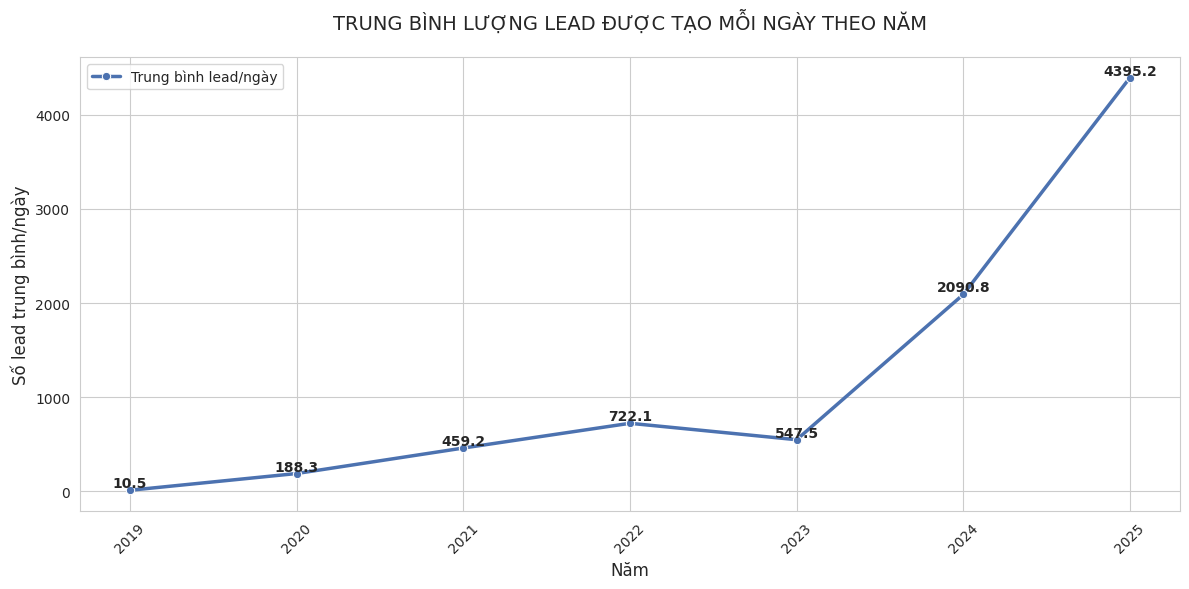

In [42]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Vẽ đường trend
sns.lineplot(
    data=avg_leads_by_year,
    x='YEAR',
    y='AVG_LEADS_PER_DAY',
    marker='o',
    color='#4C72B0',
    linewidth=2.5,
    label='Trung bình lead/ngày'
)

# Customize
plt.title('TRUNG BÌNH LƯỢNG LEAD ĐƯỢC TẠO MỖI NGÀY THEO NĂM', fontsize=14, pad=20)
plt.xlabel('Năm', fontsize=12)
plt.ylabel('Số lead trung bình/ngày', fontsize=12)
plt.xticks(avg_leads_by_year['YEAR'].unique(), rotation=45)

# Hiển thị giá trị trên điểm
for x, y in zip(avg_leads_by_year['YEAR'], avg_leads_by_year['AVG_LEADS_PER_DAY']):
    plt.text(x, y, f'{y:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

SA hoạt động

In [ ]:
unique_values = employee_lead['LEAVING_DATE'].unique()
print("Các giá trị phân biệt trong LEAVING_DATE:")
print(unique_values)

In [ ]:
employee_lead

In [43]:
employee_lead = pd.DataFrame(employee_lead)

print("--- Inspecting Original Date Columns ---")
print("\nOriginal DATE_ASSIGNED values (first 10):")
print(employee_lead['DATE_ASSIGNED'].head(10))
print("\nOriginal LEAVING_DATE values (first 10):")
print(employee_lead['LEAVING_DATE'].head(10))

print("\n--- Attempting Conversion and Checking NaT Counts ---")
employee_lead['DATE_ASSIGNED_DT'] = pd.to_datetime(employee_lead['DATE_ASSIGNED'], errors='coerce')
employee_lead['LEAVING_DATE_DT'] = pd.to_datetime(employee_lead['LEAVING_DATE'], errors='coerce')

print("\nNumber of NaT after coercing DATE_ASSIGNED_DT:", employee_lead['DATE_ASSIGNED_DT'].isna().sum())
print("Number of NaT after coercing LEAVING_DATE_DT:", employee_lead['LEAVING_DATE_DT'].isna().sum())

# Display rows where conversion failed for DATE_ASSIGNED
if employee_lead['DATE_ASSIGNED_DT'].isna().any():
    print("\nOriginal values that failed conversion in DATE_ASSIGNED:")
    print(employee_lead[employee_lead['DATE_ASSIGNED_DT'].isna()]['DATE_ASSIGNED'])

# Display rows where conversion failed for LEAVING_DATE
if employee_lead['LEAVING_DATE_DT'].isna().any():
    print("\nOriginal values that failed conversion in LEAVING_DATE:")
    print(employee_lead[employee_lead['LEAVING_DATE_DT'].isna()]['LEAVING_DATE'])

print("\n--- Resulting min/max year after conversion ---")
print("Năm gán sớm nhất (sau chuyển đổi):", employee_lead['DATE_ASSIGNED_DT'].dt.year.min())
print("Năm rời đi muộn nhất (sau chuyển đổi):", employee_lead['LEAVING_DATE_DT'].dt.year.max())

--- Inspecting Original Date Columns ---

Original DATE_ASSIGNED values (first 10):
0    2021-04-20 19:44:51
1    2021-04-25 15:45:53
2    2021-04-25 15:45:53
3    2021-04-20 19:44:51
4    2021-09-14 17:49:54
5    2021-04-25 15:45:53
6    2021-09-14 17:49:54
7    2021-04-20 19:44:51
8    2021-06-19 18:18:30
9    2021-03-28 19:21:45
Name: DATE_ASSIGNED, dtype: object

Original LEAVING_DATE values (first 10):
0    2021-10-01 00:00:00
1    2021-10-01 00:00:00
2    2021-10-01 00:00:00
3    2021-10-01 00:00:00
4    2021-10-01 00:00:00
5    2021-10-01 00:00:00
6    2021-10-01 00:00:00
7    2021-10-01 00:00:00
8    2021-07-26 00:00:00
9    2021-07-26 00:00:00
Name: LEAVING_DATE, dtype: object

--- Attempting Conversion and Checking NaT Counts ---

Number of NaT after coercing DATE_ASSIGNED_DT: 1930
Number of NaT after coercing LEAVING_DATE_DT: 1186160

Original values that failed conversion in DATE_ASSIGNED:
214        NaN
262        NaN
2197       NaN
2198       NaN
2254       NaN
          

## ở dưới là cái shop 

In [46]:
shop = shop.drop('ADDRESS', axis=1)
print("Data types in shop:")
shop.dtypes

Data types in shop:


CODE_POS              object
SALESROOM_TOWN        object
SALESROOM_DISTRICT    object
SALESROOM_PROVINCE    object
dtype: object

In [47]:
detail_lead = pd.merge(employee_lead, shop, on='CODE_POS', how='left')
# Drop salesroom location columns
columns_to_drop = ['SALESROOM_TOWN', 'SALESROOM_DISTRICT']
detail_lead = detail_lead.drop(columns_to_drop, axis=1)
# Rename SALESROOM_PROVINCE to shop_city
detail_lead = detail_lead.rename(columns={'SALESROOM_PROVINCE': 'shop_city'})


In [54]:
# Create mapping dictionary for product types
product_mapping = {
    'CD': 'Consumer Durable',
    'EPOS': 'Consumer Durable', 
    'TW': 'Two-wheelers',
    'BNP': 'GM Paylater',
    'BNPL': 'GM Paylater',
    'CCX': 'Credit Card',
    'SCW': 'Credit Card',
    'VCC': 'Credit Card', 
    'CCW': 'Credit Card',
    'CW': 'Cash Loan',
    'CL': 'Cash Loan',
    'CLX': 'Cash Loan',
    'ACL': 'Cash Loan'
}

# Map the PRODUCT values to their categories
contract['PRODUCT'] = contract['PRODUCT'].map(product_mapping)

# Get unique values in mapped PRODUCT column
print("Distinct values in PRODUCT column after mapping:")
print(contract['PRODUCT'].unique())

Distinct values in PRODUCT column after mapping:
[nan]


In [55]:
# Create mapping dictionary for product types
product_mapping = {
    'CD': 'Consumer Durable',
    'EPOS': 'Consumer Durable', 
    'TW': 'Two-wheelers',
    'BNP': 'GM Paylater',
    'BNPL': 'GM Paylater',
    'CCX': 'Credit Card',
    'SCW': 'Credit Card',
    'VCC': 'Credit Card', 
    'CCW': 'Credit Card',
    'CW': 'Cash Loan',
    'CL': 'Cash Loan',
    'CLX': 'Cash Loan',
    'ACL': 'Cash Loan'
}

# Map the CODE_PRODUCT_TYPE values to their categories
detail_lead['CODE_PRODUCT_TYPE'] = detail_lead['CODE_PRODUCT_TYPE'].map(product_mapping)

# Get unique values in mapped CODE_PRODUCT_TYPE column
print("Distinct values in CODE_PRODUCT_TYPE column after mapping:")
print(detail_lead['CODE_PRODUCT_TYPE'].unique())


Distinct values in CODE_PRODUCT_TYPE column after mapping:
[nan]


In [56]:
# Select columns from detail_lead
detail_lead_filtered = detail_lead[['CODE_EMPLOYEE', 'LEVEL_SA', 'total_work_dates', 
                                  'GENDER', 'DESC_FIN_REASON', 'SKP_CLIENT', 
                                  'LEAD_SOURCE', 'PROCESS', 'MAX_OFFER', 
                                  'CODE_PRODUCT_TYPE']]

# Join with contract table on SKP_CLIENT and product mapping
detail_lead_contract = pd.merge(
    detail_lead_filtered,
    contract[['SKP_CLIENT', 'PRODUCT', 'SIGN_CONTRACT_TIME', 
             'NAME_CREDIT_STATUS', 'APPLY_CONTRACT_TIME', 'AMT_CREDIT']],
    left_on=['SKP_CLIENT', 'CODE_PRODUCT_TYPE'],
    right_on=['SKP_CLIENT', 'PRODUCT'],
    how='left'
)

# Drop redundant PRODUCT column
detail_lead_contract = detail_lead_contract.drop('PRODUCT', axis=1)

# Join with customer table
detail_lead_contract_customer = pd.merge(
    detail_lead_contract,
    customer[['SKP_CLIENT', 'NAME_GENDER', 'NAME_EDUCATION_TYPE', 
             'AVG_SESSION_PER_WEEK_2025', 'DATE_BIRTH']],
    on='SKP_CLIENT',
    how='left'
)

# Calculate age
detail_lead_contract_customer['Age'] = pd.to_datetime(detail_lead_contract_customer['APPLY_CONTRACT_TIME']).dt.year - pd.to_datetime(detail_lead_contract_customer['DATE_BIRTH']).dt.year

# Drop DATE_BIRTH column
detail_lead_contract_customer = detail_lead_contract_customer.drop('DATE_BIRTH', axis=1)



KeyError: "['total_work_dates'] not in index"

In [51]:
# Define the statuses that count as converted
converted_statuses = ['Active', 'Finished', 'Paid off', 'Signed', 'Written off', 'Approved']

# Create converted flag column
detail_lead_contract_customer['converted'] = detail_lead_contract_customer['NAME_CREDIT_STATUS'].apply(
    lambda x: 1 if x in converted_statuses else 0
)

# Remove NAME_CREDIT_STATUS column
detail_lead_contract_customer = detail_lead_contract_customer.drop('NAME_CREDIT_STATUS', axis=1)



NameError: name 'detail_lead_contract_customer' is not defined

In [52]:
# Statistical test for significance
from scipy import stats
# Calculate conversion rate by LEVEL_SA and LEAD_SOURCE
conversion_by_level_source = detail_lead_contract_customer.groupby(['LEVEL_SA', 'LEAD_SOURCE'])['converted'].agg(['count', 'sum']).reset_index()
conversion_by_level_source['conversion_rate'] = conversion_by_level_source['sum'] / conversion_by_level_source['count']

# Create a grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=conversion_by_level_source, x='LEVEL_SA', y='conversion_rate', hue='LEAD_SOURCE')
plt.title('Conversion Rate by SA Level and Lead Source')
plt.xlabel('SA Level')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='Lead Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print the actual conversion rates
print("\nDetailed Conversion Rates:")
print(conversion_by_level_source.round(3))

# Statistical test for significance
from scipy import stats

# Group data by LEVEL_SA
level_groups = detail_lead_contract_customer.groupby('LEVEL_SA')

# Perform chi-square test for each lead source
print("\nChi-square Test Results:")
for source in detail_lead_contract_customer['LEAD_SOURCE'].unique():
    source_data = detail_lead_contract_customer[detail_lead_contract_customer['LEAD_SOURCE'] == source]
    contingency = pd.crosstab(source_data['LEVEL_SA'], source_data['converted'])
    
    # Check if we have data for this lead source
    if contingency.size > 0 and contingency.values.sum() > 0:
        chi2, p_value = stats.chi2_contingency(contingency)[:2]
        print(f"\nLead Source: {source}")
        print(f"Chi-square statistic: {chi2:.2f}")
        print(f"p-value: {p_value:.4f}")
    else:
        print(f"\nLead Source: {source}")
        print("Insufficient data for chi-square test")

NameError: name 'detail_lead_contract_customer' is not defined

In [53]:
# Create MAX_OFFER groups using quantiles
detail_lead_contract_customer['MAX_OFFER_GROUP'] = pd.qcut(detail_lead_contract_customer['MAX_OFFER'], 
                                                         q=4, 
                                                         labels=[f'Q1 (≤{detail_lead_contract_customer.MAX_OFFER.quantile(0.25):,.0f})', 
                                                                f'Q2 (≤{detail_lead_contract_customer.MAX_OFFER.quantile(0.5):,.0f})',
                                                                f'Q3 (≤{detail_lead_contract_customer.MAX_OFFER.quantile(0.75):,.0f})',
                                                                f'Q4 (>{detail_lead_contract_customer.MAX_OFFER.quantile(0.75):,.0f})'])

# Calculate conversion rates by SA Level and MAX_OFFER groups
conversion_by_level_amount = detail_lead_contract_customer.groupby(['LEVEL_SA', 'MAX_OFFER_GROUP'])['converted'].agg(['count', 'sum']).reset_index()
conversion_by_level_amount['conversion_rate'] = conversion_by_level_amount['sum'] / conversion_by_level_amount['count']

# Define colors - strong red for Warrior/Master, lighter shades for others
colors = {
    'WARRIOR': '#FF0000',  # Strong red
    'MASTER': '#FF0000',   # Same strong red
    'SENIOR': '#0000FF',   # Blue
    'JUNIOR': '#0000FF'    # Blue
}

# Create line plot
plt.figure(figsize=(12, 6))
for level in conversion_by_level_amount['LEVEL_SA'].unique():
    level_data = conversion_by_level_amount[conversion_by_level_amount['LEVEL_SA'] == level]
    plt.plot(level_data['MAX_OFFER_GROUP'], 
            level_data['conversion_rate'], 
            marker='o',
            color=colors[level],
            linewidth=2,
            label=f'SA Level {level}')

plt.title('Conversion Rate by SA Level Across Lead Value Groups')
plt.xlabel('Offer Range')
plt.ylabel('Conversion Rate')
plt.xticks(rotation=45)
plt.legend(title='SA Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Conversion Rates by SA Level and MAX_OFFER Groups:")
print(conversion_by_level_amount.round(3))

# Statistical test for each MAX_OFFER group
print("\nChi-square Test Results by MAX_OFFER Group:")
for offer_group in detail_lead_contract_customer['MAX_OFFER_GROUP'].unique():
    group_data = detail_lead_contract_customer[detail_lead_contract_customer['MAX_OFFER_GROUP'] == offer_group]
    contingency = pd.crosstab(group_data['LEVEL_SA'], group_data['converted'])
    
    if contingency.size > 0 and contingency.values.sum() > 0:
        chi2, p_value = stats.chi2_contingency(contingency)[:2]
        print(f"\nMAX_OFFER Group: {offer_group}")
        print(f"Chi-square statistic: {chi2:.2f}")
        print(f"p-value: {p_value:.4f}")
    else:
        print(f"\nMAX_OFFER Group: {offer_group}")
        print("Insufficient data for chi-square test")


NameError: name 'detail_lead_contract_customer' is not defined

In [ ]:
# Calculate IQR ranges for MAX_OFFER
q1 = detail_lead_contract_customer['MAX_OFFER'].quantile(0.25)
q2 = detail_lead_contract_customer['MAX_OFFER'].quantile(0.50)
q3 = detail_lead_contract_customer['MAX_OFFER'].quantile(0.75)

# Create MAX_OFFER range categories
detail_lead_contract_customer['MAX_OFFER_RANGE'] = pd.cut(
    detail_lead_contract_customer['MAX_OFFER'],
    bins=[-float('inf'), q1, q2, q3, float('inf')],
    labels=[f'0-{q1:,.0f}', f'{q1:,.0f}-{q2:,.0f}', f'{q2:,.0f}-{q3:,.0f}', f'>{q3:,.0f}']
)

# Create distribution table
distribution = pd.crosstab(
    detail_lead_contract_customer['MAX_OFFER_RANGE'],
    detail_lead_contract_customer['LEVEL_SA']
)

# Set colors for each SA level
colors = {
    'WARRIOR': '#FF6B6B',  # Red
    'MASTER': '#4ECDC4',   # Turquoise
    'SENIOR': '#45B7D1',   # Blue
    'JUNIOR': '#96CEB4'    # Green
}

# Create bar plot
plt.figure(figsize=(12, 6))
x = np.arange(len(distribution.index))
width = 0.2
multiplier = 0

for level in distribution.columns:
    offset = width * multiplier
    plt.bar(x + offset, distribution[level], width, label=level, color=colors[level])
    multiplier += 1

plt.title('Distribution of SA Levels by MAX_OFFER Range')
plt.xlabel('MAX_OFFER Range')
plt.ylabel('Number of Cases')
plt.xticks(x + width * 1.5, distribution.index, rotation=45)
plt.legend(title='SA Level')
plt.tight_layout()
plt.show()

# Print the distribution table
print("\nDistribution of SA Levels by MAX_OFFER Range:")
print(distribution)


In [ ]:
# Analyze conversion rate by SA experience level
plt.figure(figsize=(12, 6))

# Conversion rate by SA Level
conversion_by_level = detail_lead_contract_customer.groupby('LEVEL_SA')['converted'].agg(['count', 'sum']).reset_index()
conversion_by_level['conversion_rate'] = conversion_by_level['sum'] / conversion_by_level['count']

# Create figure and axis objects with a single subplot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot total leads bars on primary y-axis
x = np.arange(len(conversion_by_level['LEVEL_SA']))
ax1.bar(x, conversion_by_level['count'], width=0.4, label='Total Leads', color='#66B2FF')
ax1.set_xlabel('SA Level')
ax1.set_ylabel('Total Leads', color='#66B2FF')
ax1.tick_params(axis='y', labelcolor='#66B2FF')

# Create second y-axis that shares same x-axis
ax2 = ax1.twinx()

# Plot conversion rate bars on secondary y-axis
ax2.plot(x, conversion_by_level['conversion_rate'], color='#FF9999', marker='o', linewidth=2, label='Conversion Rate')
ax2.set_ylabel('Conversion Rate', color='#FF9999')
ax2.tick_params(axis='y', labelcolor='#FF9999')

# Set title and x-axis ticks
plt.title('Total Leads and Conversion Rate by SA Level')
plt.xticks(x, conversion_by_level['LEVEL_SA'], rotation=45)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\nDetailed Statistics by SA Level:")
print(conversion_by_level.round(3))

# Statistical test
print("\nChi-square Test for SA Level:")
level_contingency = pd.crosstab(detail_lead_contract_customer['LEVEL_SA'], 
                               detail_lead_contract_customer['converted'])
chi2_level, p_value_level = stats.chi2_contingency(level_contingency)[:2]
print(f"Chi-square statistic: {chi2_level:.2f}")
print(f"p-value: {p_value_level:.4f}")


## POS

In [19]:
shop.dtypes

CODE_POS              object
SALESROOM_TOWN        object
SALESROOM_DISTRICT    object
SALESROOM_PROVINCE    object
ADDRESS               object
dtype: object

In [20]:
lead.dtypes

DTIME_CREATED         object
DATE_ASSIGNED         object
DATE_ACCEPTED         object
DESC_FIN_REASON       object
CODE_POS              object
CODE_PRODUCT_TYPE     object
FLAG_ASSIGNED          int64
CODE_SA               object
SKP_CLIENT             int64
MAX_OFFER            float64
LEAD_SOURCE           object
PROCESS               object
dtype: object

In [106]:
num_unique_provinces = shop['CODE_POS'].nunique()

# Hiển thị các tỉnh thành duy nhất
unique_provinces = shop['CODE_POS'].unique()

print(f"Số lượng CODE_POS duy nhất: {num_unique_provinces}")
print(f"Các CODE_POS duy nhất: {unique_provinces}")


Số lượng CODE_POS duy nhất: 64343
Các CODE_POS duy nhất: ['410163' '400714' '240068' ... '210940' '014513' '460739']


In [103]:
num_unique_provinces = shop['SALESROOM_PROVINCE'].nunique()

# Hiển thị các tỉnh thành duy nhất
unique_provinces = shop['SALESROOM_PROVINCE'].unique()

print(f"Số lượng SALESROOM_PROVINCE duy nhất: {num_unique_provinces}")
print(f"Các tỉnh thành duy nhất: {unique_provinces}")


Số lượng SALESROOM_PROVINCE duy nhất: 63
Các tỉnh thành duy nhất: ['Hai Phong' 'Nghe An' 'Binh Phuoc' 'Kien Giang' 'Lao Cai' 'Soc Trang'
 'TP. Ha Noi' 'Phu Tho' 'Nam Dinh' 'Dong Nai' 'Dong Thap' 'Hai Duong'
 'Thai Nguyen' 'Vinh Long' 'Phu Yen' 'Bac Giang' 'Lam Dong' 'Binh Dinh'
 'Quang Binh' 'TP. HCM' 'Tay Ninh' 'Ninh Binh' 'Quang Tri' 'Vinh Phuc'
 'Ba Ria - Vung Tau' 'Da Nang' 'Thai Binh' 'Thanh Hoa' 'Quang Ngai'
 'Binh Duong' 'Can Tho' 'Binh Thuan' 'Tien Giang' 'Ben Tre' 'Hung Yen'
 'Tra Vinh' 'An Giang' 'Tuyen Quang' 'Ha Tinh' 'TP. Hue' 'Bac Ninh'
 'Khanh Hoa' 'Quang Nam' 'Quang Ninh' 'Long An' 'Dak Nong' 'Bac Lieu'
 'Dak Lak' 'Ca Mau' 'Ha Nam' 'Hau Giang' 'Dien Bien' 'Son La' 'Yen Bai'
 'Kon Tum' 'Lang Son' 'Ninh Thuan' 'Gia Lai' 'Hoa Binh' 'Cao Bang'
 'Lai Chau' 'Ha Giang' 'Bac Kan']


In [104]:
lead

,DTIME_CREATED,DATE_ASSIGNED,DATE_ACCEPTED,DESC_FIN_REASON,CODE_POS,CODE_PRODUCT_TYPE,FLAG_ASSIGNED,CODE_SA,SKP_CLIENT,MAX_OFFER,LEAD_SOURCE,PROCESS
0,2019-10-16 13:38:42,3000-01-01 00:00:00,3000-01-01 00:00:00,Not Applicable,011417,CLX,0,NaN,12393659,20000000.0,TLS,PRO
1,2024-09-26 18:22:11,2024-09-26 18:22:11,2024-09-26 18:22:21,Not Interest,440055,BNP,1,0026865,93813570,8000000.0,SA,STD
2,2024-11-06 20:08:00,2024-11-07 08:33:46,2024-11-07 08:34:32,Not Interest,1W0499,CCX,1,00058616,1748865,25000000.0,RA,STD
3,2022-09-29 11:56:46,2022-09-29 11:56:46,2022-09-29 18:48:50,Not Interest,400554,CCX,1,0027520,22148819,5000000.0,SA,STD
4,2022-03-30 20:17:34,2022-03-30 20:17:34,2022-03-31 08:48:42,Not Interest,100284,CLX,1,0023262,54145376,40000000.0,SA,STD
...,...,...,...,...,...,...,...,...,...,...,...,...
2143886,2022-11-04 19:28:06,2022-11-04 19:28:06,2022-11-06 12:33:10,Not Interest,030298,CLX,1,0031265,57165785,72657000.0,SA,STD
2143887,2022-11-11 19:50:40,2022-11-11 19:50:40,2022-11-12 08:09:48,Not Interest,221486,VCC,1,0027690,42788141,3000000.0,SA,STD
2143888,2025-03-19 14:38:46,2025-03-20 08:00:50,2025-03-20 08:03:59,Not Interest,013355,CCX,1,00047460,104196078,35000000.0,RA,STD
2143889,2022-11-11 16:12:23,2022-11-11 16:12:23,2022-11-11 16:12:48,Expire Lifetime,170508,VCC,1,0023679,12577773,5500000.0,RA,STD


In [110]:
num_unique_provinces = lead['CODE_POS'].nunique()

# Hiển thị các tỉnh thành duy nhất
unique_provinces = lead['CODE_POS'].unique()

print(f"Số lượng CODE_POS duy nhất trong lead: {num_unique_provinces}")
print(f"Các CODE_POS duy nhất trong lead: {unique_provinces}")


Số lượng CODE_POS duy nhất: 25311
Các CODE_POS duy nhất: ['011417' '440055' '1W0499' ... '071024' '280061' '013055']


In [121]:
import pandas as pd

# Giả sử df là DataFrame chứa dữ liệu của bạn
# Lọc các bản ghi có SALESROOM_PROVINCE là "Hai Phong"
HCM = shop[shop['SALESROOM_PROVINCE'] == 'Long An']

# Đếm số lượng CODE_POS duy nhất

HCM

,CODE_POS,SALESROOM_TOWN,SALESROOM_DISTRICT,SALESROOM_PROVINCE,IS_MATCH_CODE_POS
26,1W0163,Xã Vĩnh Lọc B,H. Binh Chanh,TP. HCM,True
28,1W0476,P.6,Q. Go Vap,TP. HCM,True
32,010879,P.Binh Chieu,TP. Thu Duc,TP. HCM,True
33,012666,Xã. An Phú Tay,H. Binh Chanh,TP. HCM,False
35,012699,P.12,Q. 10,TP. HCM,False
...,...,...,...,...,...
64483,1E0711,P. 3,Q. 4,TP. HCM,True
64485,011414,10,Q. Tan Binh,TP. HCM,True
64488,012276,Phuong 03,Q. 5,TP. HCM,False
64489,011797,P.8,Q. Go Vap,TP. HCM,True


In [14]:
import pandas as pd

# 1. Đếm số lượng SALESROOM_PROVINCE unique
unique_provinces = shop['SALESROOM_PROVINCE'].nunique()
print(f"Tổng số tỉnh/thành phố unique: {unique_provinces}\n")

# 2. Đếm số CODE_POS duy nhất cho mỗi SALESROOM_PROVINCE
province_code_counts = shop.groupby('SALESROOM_PROVINCE')['CODE_POS'].nunique().reset_index()
province_code_counts.columns = ['SALESROOM_PROVINCE', 'UNIQUE_CODE_POS_COUNT']

# Sắp xếp kết quả theo số lượng CODE_POS giảm dần
province_code_counts = province_code_counts.sort_values('UNIQUE_CODE_POS_COUNT', ascending=False)

# In kết quả
print("Số lượng CODE_POS duy nhất theo từng tỉnh/thành phố:")
print(province_code_counts.to_string(index=False))


Tổng số tỉnh/thành phố unique: 63

Số lượng CODE_POS duy nhất theo từng tỉnh/thành phố:
SALESROOM_PROVINCE  UNIQUE_CODE_POS_COUNT
           TP. HCM                   7674
        TP. Ha Noi                   5098
          Dong Nai                   3036
        Binh Duong                   2704
         Thanh Hoa                   1758
           Nghe An                   1646
         Hai Phong                   1620
          An Giang                   1495
           Dak Lak                   1480
         Khanh Hoa                   1264
        Kien Giang                   1241
        Binh Thuan                   1211
         Binh Dinh                   1176
           Long An                   1113
 Ba Ria - Vung Tau                   1092
          Lam Dong                   1072
        Quang Ninh                   1042
        Tien Giang                   1035
           Da Nang                   1016
         Dong Thap                    986
           Gia Lai            

AttributeError: 'NoneType' object has no attribute 'head'

In [13]:
import pandas as pd

# Đếm số lượng CODE_SA duy nhất cho mỗi CODE_POS trong bảng lead
code_pos_sa_counts = lead.groupby('CODE_POS')['CODE_SA'].nunique().reset_index()
code_pos_sa_counts.columns = ['CODE_POS', 'UNIQUE_CODE_SA_COUNT']

# Sắp xếp theo số lượng CODE_SA giảm dần
code_pos_sa_counts = code_pos_sa_counts.sort_values('UNIQUE_CODE_SA_COUNT', ascending=False)

# # In kết quả
# print("Số lượng CODE_SA duy nhất cho mỗi CODE_POS trong bảng lead:")
# print(code_pos_sa_counts.to_string(index=False))

# Thống kê tổng quan
print("\nThống kê tổng quan:")
print(f"Tổng số CODE_POS unique trong lead: {len(code_pos_sa_counts)}")
print(f"Trung bình CODE_SA trên mỗi CODE_POS: {code_pos_sa_counts['UNIQUE_CODE_SA_COUNT'].mean():.2f}")
print(f"CODE_POS có nhiều CODE_SA nhất: {code_pos_sa_counts['UNIQUE_CODE_SA_COUNT'].max()}")
print(f"CODE_POS có ít CODE_SA nhất: {code_pos_sa_counts['UNIQUE_CODE_SA_COUNT'].min()}")


Thống kê tổng quan:
Tổng số CODE_POS unique trong lead: 25311
Trung bình CODE_SA trên mỗi CODE_POS: 6.36
CODE_POS có nhiều CODE_SA nhất: 1480
CODE_POS có ít CODE_SA nhất: 0


In [18]:
# Kiểm tra xem có bao nhiêu CODE_POS trong lead cũng có trong shop
common_code_pos = set(lead['CODE_POS'].dropna().unique()) & set(shop['CODE_POS'].dropna().unique())
print(f"\nSố lượng CODE_POS có trong cả lead và shop: {len(common_code_pos)}")

# Đếm số CODE_SA cho các CODE_POS này
common_pos_sa_counts = lead[lead['CODE_POS'].isin(common_code_pos)].groupby('CODE_POS')['CODE_SA'].nunique()
print("\nSố lượng CODE_SA cho các CODE_POS có trong cả 2 bảng:")
# print(common_pos_sa_counts.sort_values(ascending=False).to_string())


Số lượng CODE_POS có trong cả lead và shop: 25284

Số lượng CODE_SA cho các CODE_POS có trong cả 2 bảng:


Số lead không có thông tin tỉnh: 4459 (0.21%)

Phân bố lead theo tỉnh/thành phố:
SALESROOM_PROVINCE
TP. HCM       379105
Binh Duong    133026
Dong Nai      121413
Long An        92223
TP. Ha Noi     85656
               ...  
Lao Cai         5661
Ha Giang        5339
Cao Bang        3954
Lai Chau        3025
Bac Kan         2742
Length: 63, dtype: int64


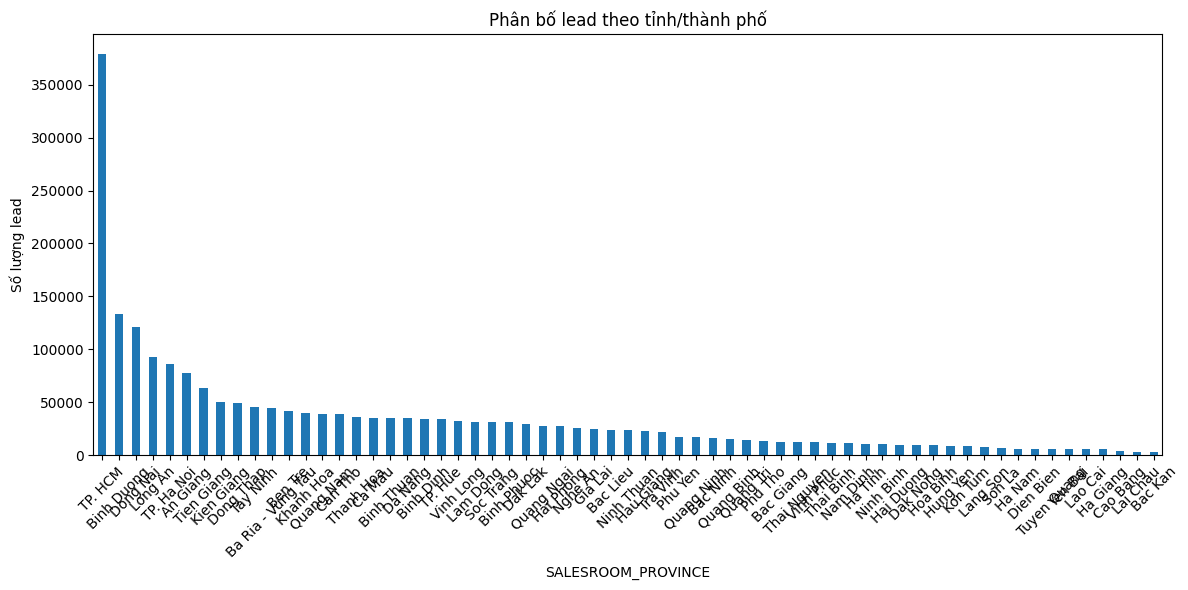


So sánh phân bố lead và điểm bán:
                    Số lượng lead  Số điểm bán  Tỷ lệ lead/điểm bán
SALESROOM_PROVINCE                                                 
Long An                     92223         1113                82.86
Tien Giang                  63093         1035                60.96
Vinh Long                   32230          542                59.46
Quang Nam                   39224          742                52.86
Hau Giang                   23200          445                52.13
...                           ...          ...                  ...
Bac Giang                   12605          931                13.54
Son La                       6932          532                13.03
Hai Duong                    9566          806                11.87
Bac Kan                      2742          233                11.77
Lao Cai                      5661          506                11.19

[63 rows x 3 columns]

Các tỉnh có tỷ lệ lead/điểm bán cao bất thường:
         

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Kết hợp thông tin tỉnh từ bảng shop vào bảng lead
lead_with_province = pd.merge(lead, shop[['CODE_POS', 'SALESROOM_PROVINCE']], 
                             on='CODE_POS', how='left')

# Kiểm tra xem có bao nhiêu lead không có thông tin tỉnh
missing_province = lead_with_province['SALESROOM_PROVINCE'].isna().sum()
print(f"Số lead không có thông tin tỉnh: {missing_province} ({missing_province/len(lead)*100:.2f}%)")

# 2. Phân bố lead theo tỉnh/thành phố
lead_province_dist = lead_with_province.groupby('SALESROOM_PROVINCE').size().sort_values(ascending=False)
print("\nPhân bố lead theo tỉnh/thành phố:")
print(lead_province_dist)

# Vẽ biểu đồ
plt.figure(figsize=(12,6))
lead_province_dist.plot(kind='bar')
plt.title('Phân bố lead theo tỉnh/thành phố')
plt.ylabel('Số lượng lead')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. So sánh với phân bố điểm bán (CODE_POS)
shop_province_dist = shop.groupby('SALESROOM_PROVINCE')['CODE_POS'].nunique().sort_values(ascending=False)

# Tạo DataFrame so sánh
comparison_df = pd.DataFrame({
    'Số lượng lead': lead_province_dist,
    'Số điểm bán': shop_province_dist,
    'Tỷ lệ lead/điểm bán': (lead_province_dist / shop_province_dist).round(2)
}).sort_values('Tỷ lệ lead/điểm bán', ascending=False)

print("\nSo sánh phân bố lead và điểm bán:")
print(comparison_df)

# 4. Phân tích các tỉnh có phân bố bất thường
# Các tỉnh có tỷ lệ lead/điểm bán cao
high_ratio = comparison_df[comparison_df['Tỷ lệ lead/điểm bán'] > comparison_df['Tỷ lệ lead/điểm bán'].median() * 2]
print("\nCác tỉnh có tỷ lệ lead/điểm bán cao bất thường:")
print(high_ratio)

# Các tỉnh có tỷ lệ lead/điểm bán thấp
low_ratio = comparison_df[comparison_df['Tỷ lệ lead/điểm bán'] < comparison_df['Tỷ lệ lead/điểm bán'].median() / 2]
print("\nCác tỉnh có tỷ lệ lead/điểm bán thấp bất thường:")
print(low_ratio)

Top 20 tỉnh/thành phố có số lượng lead cao nhất:
SALESROOM_PROVINCE
TP. HCM              379105
Binh Duong           133026
Dong Nai             121413
Long An               92223
TP. Ha Noi            85656
An Giang              77650
Tien Giang            63093
Kien Giang            50220
Dong Thap             48749
Tay Ninh              45710
Ba Ria - Vung Tau     44211
Ben Tre               41826
Khanh Hoa             39649
Quang Nam             39224
Can Tho               38635
Thanh Hoa             35656
Ca Mau                35317
Binh Thuan            35061
Da Nang               34667
Binh Dinh             34301
dtype: int64


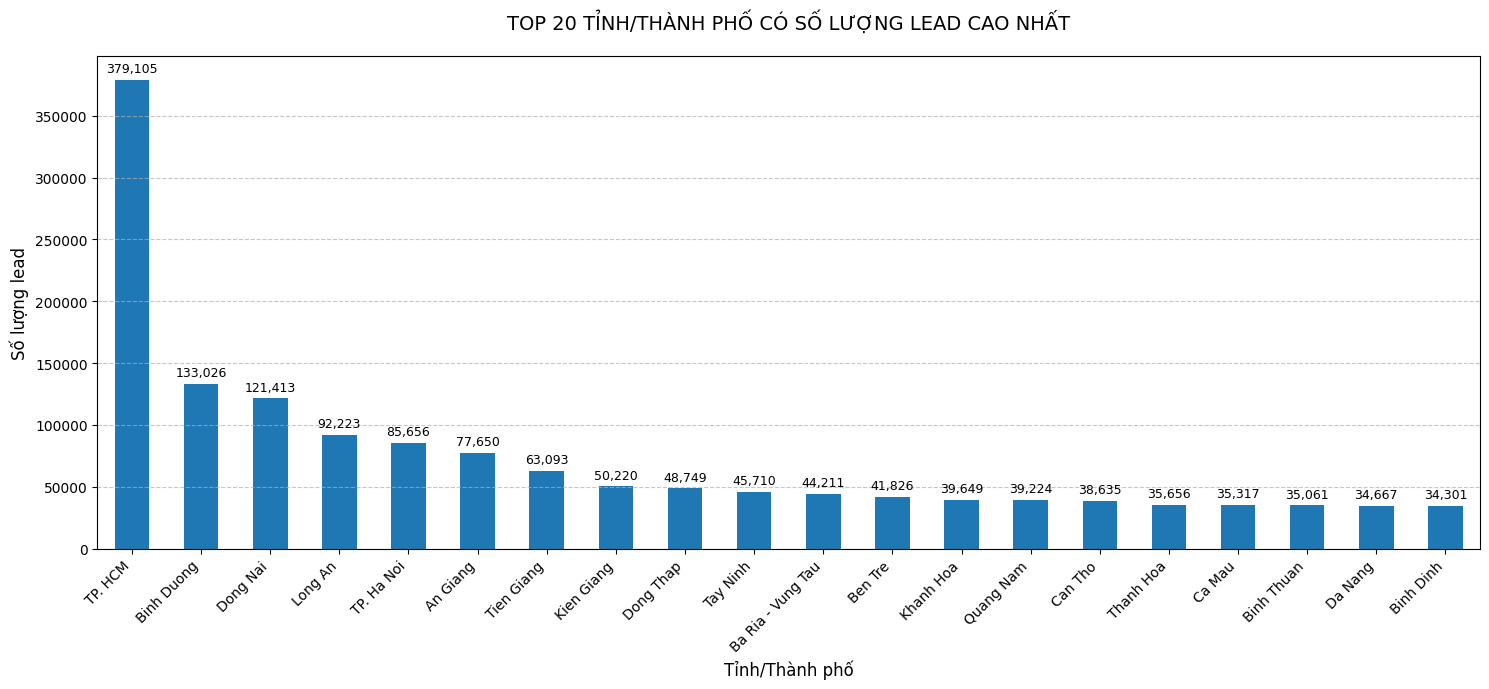

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Lấy top 20 tỉnh có số lượng lead cao nhất
top_20_provinces = lead_with_province.groupby('SALESROOM_PROVINCE').size().sort_values(ascending=False).head(20)

# 2. In thông tin top 20 tỉnh
print("Top 20 tỉnh/thành phố có số lượng lead cao nhất:")
print(top_20_provinces)

# 3. Vẽ biểu đồ
plt.figure(figsize=(15, 7))
top_20_provinces.plot(kind='bar', color='#1f77b4')

# Customize biểu đồ
plt.title('TOP 20 TỈNH/THÀNH PHỐ CÓ SỐ LƯỢNG LEAD CAO NHẤT', fontsize=14, pad=20)
plt.xlabel('Tỉnh/Thành phố', fontsize=12)
plt.ylabel('Số lượng lead', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục x 45 độ và căn phải

# Thêm đường trung bình
avg_leads = top_20_provinces.mean()
# plt.axhline(y=avg_leads, color='r', linestyle='--', linewidth=1)
# plt.text(x=0, y=avg_leads*1.05, s=f'Trung bình: {avg_leads:,.0f}', color='r')

# Thêm giá trị trên mỗi cột
for i, v in enumerate(top_20_provinces):
    plt.text(i, v + 0.01*max(top_20_provinces), f'{v:,.0f}', 
             ha='center', va='bottom', fontsize=9)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [29]:
HCM = 379105/7674
HCM

49.40122491529841

In [24]:
contract.dtypes

SKP_CREDIT_CASE            int64
SKP_CLIENT                 int64
NAME_EDUCATION_TYPE       object
CNT_CHILDREN               int64
AMT_INCOME_MAIN          float64
AMT_INCOME_HOUSEHOLD       int64
NAME_INCOME_TYPE          object
CODE_PROFESSION           object
NAME_CREDIT_STATUS        object
PRODUCT                   object
AMT_CREDIT               float64
PAYMENT_NUM              float64
INIT_PAY                 float64
ANNUITY                  float64
SKP_SALESROOM              int64
APPLY_CONTRACT_TIME       object
APPROVE_CONTRACT_TIME     object
SIGN_CONTRACT_TIME        object
APPLY_EMPLOYEE            object
SIGN_EMPLOYEE             object
TRANSAC                   object
FIRST_DUE                  int64
SECOND_DUE                 int64
THIRD_DUE                  int64
FOURTH_DUE                 int64
AMT_BILLING              float64
FLAG_INS                   int64
APPLY_EMPLOYEE_LEVEL      object
SIGN_EMPLOYEE_LEVEL       object
dtype: object

Tỷ lệ ký hợp đồng theo tỉnh/thành phố:
SALESROOM_PROVINCE
Dong Thap     80.99
Tien Giang    80.82
Quang Ngai    80.77
Tra Vinh      80.70
Quang Nam     80.26
              ...  
Vinh Phuc     74.53
Kon Tum       74.31
Lai Chau      73.52
Lao Cai       71.50
Bac Kan       70.27
Length: 63, dtype: float64


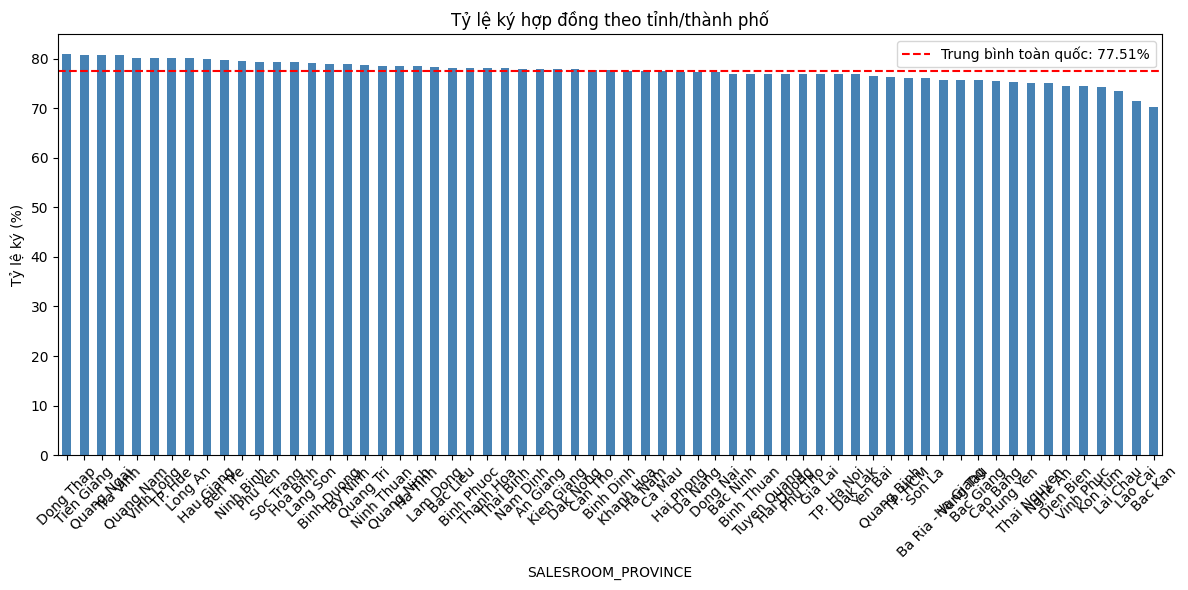


Các tỉnh có tỷ lệ ký hợp đồng cao bất thường:
SALESROOM_PROVINCE
Ben Tre       79.79
Dong Thap     80.99
Hau Giang     80.05
Long An       80.06
Quang Nam     80.26
Quang Ngai    80.77
TP. Hue       80.22
Tien Giang    80.82
Tra Vinh      80.70
Vinh Long     80.25
dtype: float64

Các tỉnh có tỷ lệ ký hợp đồng thấp bất thường:
SALESROOM_PROVINCE
Bac Kan        70.27
Dien Bien      74.54
Kon Tum        74.31
Lai Chau       73.52
Lao Cai        71.50
Nghe An        75.03
Thai Nguyen    75.19
Vinh Phuc      74.53
dtype: float64

Tỷ lệ ký hợp đồng theo sản phẩm và tỉnh:
PRODUCT              BNPL     CC     CD     CL     CW  IN     TW
SALESROOM_PROVINCE                                              
An Giang            90.42  74.21  79.82  68.24  26.08 NaN  71.32
Ba Ria - Vung Tau   89.48  77.45  77.45  69.45  22.09 NaN  61.12
Bac Giang           92.25  79.89  76.93  72.42  38.91 NaN  78.24
Bac Kan             98.30  75.68  70.33  65.19  27.65 NaN  69.91
Bac Lieu            93.12  72.86  79.

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

## 1. Kết hợp dữ liệu từ các bảng
# Merge contract với lead qua SKP_CLIENT
contract_with_lead = pd.merge(contract, lead[['SKP_CLIENT', 'CODE_POS']], on='SKP_CLIENT', how='left')

# Merge tiếp với shop để lấy thông tin tỉnh/thành
contract_with_province = pd.merge(contract_with_lead, 
                                 shop[['CODE_POS', 'SALESROOM_PROVINCE']], 
                                 on='CODE_POS', 
                                 how='left')

## 2. Tính toán tỷ lệ ký hợp đồng
# Đếm tổng số hợp đồng theo tỉnh
total_contracts_by_province = contract_with_province.groupby('SALESROOM_PROVINCE').size()

# Đếm số hợp đồng đã ký (giả sử SIGN_CONTRACT_TIME không null là đã ký)
signed_contracts = contract_with_province[contract_with_province['SIGN_CONTRACT_TIME'].notna()]
signed_by_province = signed_contracts.groupby('SALESROOM_PROVINCE').size()

# Tính tỷ lệ ký hợp đồng
signing_rate = (signed_by_province / total_contracts_by_province * 100).round(2)

## 3. Phân tích kết quả
# Sắp xếp theo tỷ lệ giảm dần
signing_rate_sorted = signing_rate.sort_values(ascending=False)

print("Tỷ lệ ký hợp đồng theo tỉnh/thành phố:")
print(signing_rate_sorted)

# Vẽ biểu đồ
plt.figure(figsize=(12,6))
signing_rate_sorted.plot(kind='bar', color='steelblue')
plt.title('Tỷ lệ ký hợp đồng theo tỉnh/thành phố')
plt.ylabel('Tỷ lệ ký (%)')
plt.xticks(rotation=45)
plt.axhline(y=signing_rate.mean(), color='r', linestyle='--', label=f'Trung bình toàn quốc: {signing_rate.mean():.2f}%')
plt.legend()
plt.tight_layout()
plt.show()

## 4. Xác định các tỉnh có tỷ lệ cao/thấp bất thường
mean_rate = signing_rate.mean()
std_rate = signing_rate.std()

# Tỉnh có tỷ lệ cao (trên mean + 1std)
high_rate_provinces = signing_rate[signing_rate > mean_rate + std_rate]
print("\nCác tỉnh có tỷ lệ ký hợp đồng cao bất thường:")
print(high_rate_provinces)

# Tỉnh có tỷ lệ thấp (dưới mean - 1std)
low_rate_provinces = signing_rate[signing_rate < mean_rate - std_rate]
print("\nCác tỉnh có tỷ lệ ký hợp đồng thấp bất thường:")
print(low_rate_provinces)

## 5. Phân tích sâu hơn với các biến khác
# Tỷ lệ ký hợp đồng theo loại sản phẩm và tỉnh
product_signing_rate = pd.crosstab(contract_with_province['SALESROOM_PROVINCE'],
                                  contract_with_province['PRODUCT'],
                                  values=contract_with_province['SIGN_CONTRACT_TIME'].notna(),
                                  aggfunc='mean').round(4)*100

print("\nTỷ lệ ký hợp đồng theo sản phẩm và tỉnh:")
print(product_signing_rate)

# Tương quan giữa tỷ lệ ký hợp đồng và quy mô điểm bán
province_stats = pd.DataFrame({
    'SigningRate': signing_rate,
    'NumShops': shop.groupby('SALESROOM_PROVINCE')['CODE_POS'].nunique()
})

print("\nTương quan giữa tỷ lệ ký và số lượng điểm bán:")
print(province_stats.corr())

In [34]:
# Bước 2: Thực hiện kiểm tra các giá trị duy nhất
unique_statuses = contract_with_province['NAME_CREDIT_STATUS'].unique()
num_unique_statuses = contract_with_province['NAME_CREDIT_STATUS'].nunique()

print(f"Các loại (giá trị duy nhất) trong cột 'NAME_CREDIT_STATUS' là: {unique_statuses}")
print(f"Tổng số loại (giá trị duy nhất) trong cột 'NAME_CREDIT_STATUS' là: {num_unique_statuses}")

Các loại (giá trị duy nhất) trong cột 'NAME_CREDIT_STATUS' là: ['Finished' 'Rejected' 'Active' 'Cancelled' 'Written off' 'Sold'
 'Paid off' 'In Preprocess' 'Signed' 'Approved' 'In Process']
Tổng số loại (giá trị duy nhất) trong cột 'NAME_CREDIT_STATUS' là: 11


In [41]:
signed_by_status = contract_with_province[contract_with_province['NAME_CREDIT_STATUS'] == 'Finished']
signed_by_status

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,SKP_CREDIT_CASE,SKP_CLIENT,NAME_EDUCATION_TYPE,CNT_CHILDREN,AMT_INCOME_MAIN,AMT_INCOME_HOUSEHOLD,NAME_INCOME_TYPE,CODE_PROFESSION,NAME_CREDIT_STATUS,PRODUCT,...,FIRST_DUE,SECOND_DUE,THIRD_DUE,FOURTH_DUE,AMT_BILLING,FLAG_INS,APPLY_EMPLOYEE_LEVEL,SIGN_EMPLOYEE_LEVEL,CODE_POS,SALESROOM_PROVINCE
0,46804792,13152490,XNA,0,0.0,0,XNA,XNA,Finished,CD,...,0,0,0,0,NaN,1,NaN,NaN,NaN,NaN
1,54355719,14915647,XNA,0,0.0,0,XNA,XNA,Finished,CD,...,0,0,0,0,NaN,1,NaN,NaN,200471,Tien Giang
2,54355719,14915647,XNA,0,0.0,0,XNA,XNA,Finished,CD,...,0,0,0,0,NaN,1,NaN,NaN,200471,Tien Giang
9,199467152,62216381,Bachelor's degree,0,10000000.0,0,Employed person,OTHER,Finished,CD,...,0,0,0,0,NaN,1,NaN,NaN,070451,Khanh Hoa
10,199467152,62216381,Bachelor's degree,0,10000000.0,0,Employed person,OTHER,Finished,CD,...,0,0,0,0,NaN,1,NaN,NaN,013783,TP. HCM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22630612,321433839,11854609,XNA,0,10000000.0,0,Employed person,OTHER,Finished,CL,...,0,0,0,0,NaN,0,NaN,WARRIOR,1W0559,TP. HCM
22630613,81343486,12603259,XNA,0,0.0,0,XNA,XNA,Finished,CD,...,0,0,0,0,NaN,1,NaN,NaN,1W0535,TP. HCM
22630614,81343486,12603259,XNA,0,0.0,0,XNA,XNA,Finished,CD,...,0,0,0,0,NaN,1,NaN,NaN,1W0535,TP. HCM
22630615,81343486,12603259,XNA,0,0.0,0,XNA,XNA,Finished,CD,...,0,0,0,0,NaN,1,NaN,NaN,1W0535,TP. HCM



Tỷ lệ hợp đồng có NAME_CREDIT_STATUS là IS_SIGNED theo tỉnh/thành phố:
SALESROOM_PROVINCE
Lai Chau      10.30
Lao Cai       10.07
Kien Giang    10.06
Ca Mau         9.89
Hung Yen       9.70
              ...  
Lang Son       6.75
Quang Tri      6.70
TP. Hue        6.55
Quang Ngai     6.22
Quang Nam      5.70
Length: 63, dtype: float64


<Figure size 1400x700 with 0 Axes>

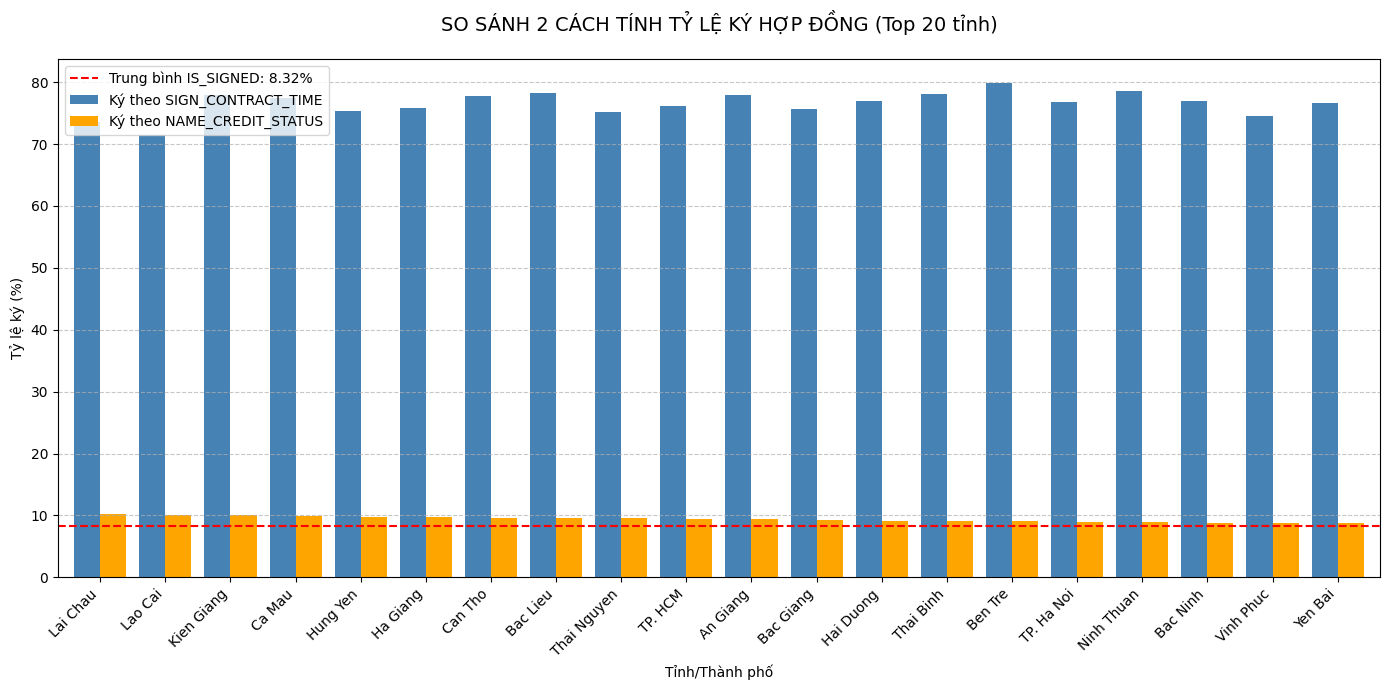


Các tỉnh có tỷ lệ cao bất thường:
SALESROOM_PROVINCE
An Giang        9.36
Bac Giang       9.30
Bac Lieu        9.65
Ca Mau          9.89
Can Tho         9.66
Ha Giang        9.68
Hung Yen        9.70
Kien Giang     10.06
Lai Chau       10.30
Lao Cai        10.07
TP. HCM         9.47
Thai Nguyen     9.51
dtype: float64

Các tỉnh có tỷ lệ thấp bất thường:
SALESROOM_PROVINCE
Da Nang       7.12
Ha Tinh       7.09
Lang Son      6.75
Phu Yen       7.06
Quang Binh    7.26
Quang Nam     5.70
Quang Ngai    6.22
Quang Tri     6.70
TP. Hue       6.55
dtype: float64

Tỷ lệ Finished theo sản phẩm và tỉnh:
PRODUCT             BNPL     CC    CD     CL     CW  IN     TW
SALESROOM_PROVINCE                                            
An Giang            7.78   8.08  8.70  12.78  26.36 NaN   8.61
Ba Ria - Vung Tau   8.35   5.50  8.12   9.81  27.28 NaN  11.41
Bac Giang           4.59   5.69  7.93  14.03  20.31 NaN   6.71
Bac Kan             1.19   3.79  7.79  12.16  26.14 NaN   5.95
Bac Lieu            4

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [43]:
## 2.1 Tính toán tỷ lệ hợp đồng có NAME_CREDIT_STATUS là "IS_SIGNED"
# Đếm số hợp đồng đã ký (theo trạng thái)
signed_by_status = contract_with_province[contract_with_province['NAME_CREDIT_STATUS'] == 'Rejected']
signed_status_by_province = signed_by_status.groupby('SALESROOM_PROVINCE').size()

# Tính tỷ lệ ký hợp đồng theo trạng thái
signing_rate_by_status = (signed_status_by_province / total_contracts_by_province * 100).round(2)

# Sắp xếp theo tỷ lệ giảm dần
signing_rate_status_sorted = signing_rate_by_status.sort_values(ascending=False)

print("\nTỷ lệ hợp đồng có NAME_CREDIT_STATUS là IS_SIGNED theo tỉnh/thành phố:")
print(signing_rate_status_sorted)

# Vẽ biểu đồ so sánh 2 cách tính
plt.figure(figsize=(14, 7))

# Tạo dataframe so sánh
comparison_df = pd.DataFrame({
    'Ký theo SIGN_CONTRACT_TIME': signing_rate,
    'Ký theo NAME_CREDIT_STATUS': signing_rate_by_status
}).sort_values('Ký theo NAME_CREDIT_STATUS', ascending=False).head(20)

# Vẽ biểu đồ
comparison_df.plot(kind='bar', width=0.8, color=['steelblue', 'orange'], figsize=(14,7))
plt.title('SO SÁNH 2 CÁCH TÍNH TỶ LỆ KÝ HỢP ĐỒNG (Top 20 tỉnh)', fontsize=14, pad=20)
plt.ylabel('Tỷ lệ ký (%)')
plt.xlabel('Tỉnh/Thành phố')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=signing_rate_by_status.mean(), color='r', linestyle='--', 
            label=f'Trung bình IS_SIGNED: {signing_rate_by_status.mean():.2f}%')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 4.1 Xác định các tỉnh có tỷ lệ IS_SIGNED cao/thấp bất thường
mean_status_rate = signing_rate_by_status.mean()
std_status_rate = signing_rate_by_status.std()

# Tỉnh có tỷ lệ cao
high_status_rate = signing_rate_by_status[signing_rate_by_status > mean_status_rate + std_status_rate]
print("\nCác tỉnh có tỷ lệ cao bất thường:")
print(high_status_rate)

# Tỉnh có tỷ lệ thấp
low_status_rate = signing_rate_by_status[signing_rate_by_status < mean_status_rate - std_status_rate]
print("\nCác tỉnh có tỷ lệ thấp bất thường:")
print(low_status_rate)

## 5.1 Phân tích sâu hơn với trạng thái IS_SIGNED
# Tỷ lệ IS_SIGNED theo sản phẩm và tỉnh
product_status_rate = pd.crosstab(
    contract_with_province['SALESROOM_PROVINCE'],
    contract_with_province['PRODUCT'],
    values=(contract_with_province['NAME_CREDIT_STATUS'] == 'Rejected'),
    aggfunc='mean'
).round(4)*100

print("\nTỷ lệ Finished theo sản phẩm và tỉnh:")
print(product_status_rate)

# So sánh 2 cách tính tỷ lệ ký
discrepancy = (signing_rate - signing_rate_by_status).abs()
print("\nChênh lệch trung bình giữa 2 cách tính:", discrepancy.mean().round(2), "%")
print("Các tỉnh có chênh lệch lớn nhất:")
print(discrepancy.sort_values(ascending=False).head(10))

<Figure size 1800x900 with 0 Axes>

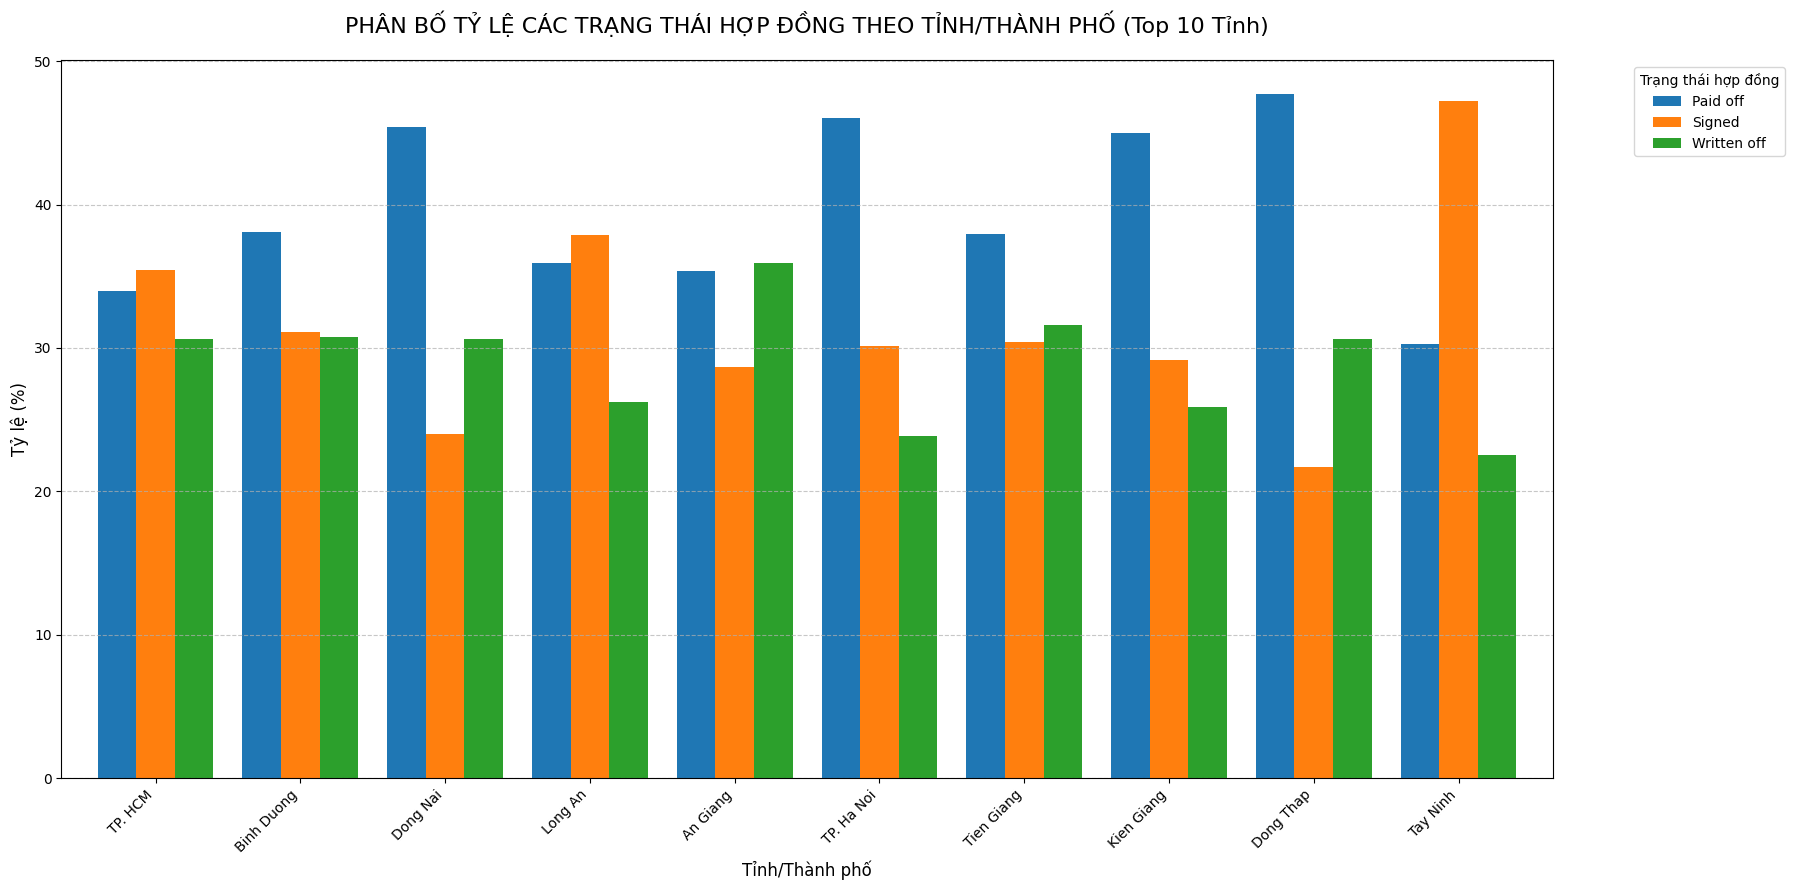

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Thường được dùng để tạo biểu đồ đẹp hơn

# Xác định các trạng thái hợp đồng bạn muốn hiển thị
target_statuses = ['Written off', 'Paid off', 'Signed']

# Lọc DataFrame để chỉ bao gồm các trạng thái mong muốn
filtered_contracts = contract_with_province[contract_with_province['NAME_CREDIT_STATUS'].isin(target_statuses)]

# Tính toán tỷ lệ phần trăm của mỗi trạng thái trên mỗi tỉnh
# Sử dụng value_counts(normalize=True) để lấy tỷ lệ, sau đó unstack để chuyển sang định dạng rộng
# Cuối cùng nhân 100 để có phần trăm
status_distribution_by_province = filtered_contracts.groupby('SALESROOM_PROVINCE')['NAME_CREDIT_STATUS'].value_counts(normalize=True).unstack(fill_value=0) * 100

# Chọn Top 10 tỉnh có số lượng hợp đồng lớn nhất để biểu đồ dễ nhìn hơn
# (hoặc bạn có thể chọn các tỉnh cụ thể mà bạn quan tâm)
top_provinces = contract_with_province['SALESROOM_PROVINCE'].value_counts().nlargest(10).index
status_distribution_for_plot = status_distribution_by_province.loc[top_provinces]

# Vẽ biểu đồ nhóm cột (grouped bar chart)
plt.figure(figsize=(18, 9)) # Kích thước biểu đồ lớn hơn để dễ nhìn
status_distribution_for_plot.plot(kind='bar', figsize=(18, 9), width=0.8)

plt.title('PHÂN BỐ TỶ LỆ CÁC TRẠNG THÁI HỢP ĐỒNG THEO TỈNH/THÀNH PHỐ (Top 10 Tỉnh)', fontsize=16, pad=20)
plt.ylabel('Tỷ lệ (%)', fontsize=12)
plt.xlabel('Tỉnh/Thành phố', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10) # Xoay nhãn trục x để dễ đọc
plt.yticks(fontsize=10)
plt.legend(title='Trạng thái hợp đồng', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10) # Chú thích bên ngoài biểu đồ
plt.grid(axis='y', linestyle='--', alpha=0.7) # Thêm lưới ngang
plt.tight_layout() # Tự động điều chỉnh khoảng cách
plt.show()

# MODEL TRAINING

## Merge customer and contract

In [4]:
customer_MD = customer.drop(columns=['CNT_CHILDREN', 'CNT_PERSON_DEPENDENT','FLAG_CAR_OWNER','ADDRESS','NAME_EDUCATION_TYPE','AVG_SESSION_PER_WEEK_2025'])


customer_MD['NAME_GENDER'] = customer_MD['NAME_GENDER'].replace('XNA', 'Unknown')
customer_MD['NAME_SALARY_FREQUENCY'] = customer_MD['NAME_SALARY_FREQUENCY'].replace('XNA', 'Unknown')


In [5]:
contract_train_MD = contract_train.drop(columns=['SKP_CREDIT_CASE','SKP_SALESROOM',
                                                 'APPLY_EMPLOYEE',
                                                 'APPLY_EMPLOYEE_LEVEL', 'SIGN_EMPLOYEE_LEVEL',
                                                'TRANSAC', 'AMT_BILLING','APPROVE_CONTRACT_TIME',
                                                 'AMT_INCOME_HOUSEHOLD'])


In [ ]:
# contract_test = pd.read_csv(r'/kaggle/input/grand-final/contract_test.csv')

In [6]:

contract_test_MD = contract_test.drop(columns=['SKP_CREDIT_CASE','SKP_SALESROOM',
                                                 'APPLY_EMPLOYEE',
                                                 'APPLY_EMPLOYEE_LEVEL', 'SIGN_EMPLOYEE_LEVEL',
                                                'TRANSAC', 'AMT_BILLING','APPROVE_CONTRACT_TIME',
                                                 'AMT_INCOME_HOUSEHOLD'])


In [7]:
numerical_cols = ["AMT_CREDIT", 'INIT_PAY', 'ANNUITY', 'PAYMENT_NUM','CNT_CHILDREN', 'AMT_INCOME_MAIN']
categorical_cols = [ 'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'CODE_PROFESSION','NAME_CREDIT_STATUS', 
                    'PRODUCT', 'FIRST_DUE', 'SECOND_DUE', 'THIRD_DUE', 'FOURTH_DUE','FLAG_INS']


contract_train_cleaned = contract_train_MD.copy()


for col in numerical_cols:
    contract_train_cleaned[col] = pd.to_numeric(contract_train_cleaned[col], errors='coerce')

# filter outliers using IQR
for col in numerical_cols:
    if contract_train_cleaned[col].count() > 1: # Check if there's at least 2 non-null values for quantile calculation
        Q1 = contract_train_cleaned[col].quantile(0.25)
        Q3 = contract_train_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        # Keep rows where the value is within the IQR range or is null
        contract_train_cleaned = contract_train_cleaned[(contract_train_cleaned[col].isnull()) | ((contract_train_cleaned[col] >= lower) & (contract_train_cleaned[col] <= upper))]
    else:
        print(f"Warning: Not enough non-null data to filter outliers for column '{col}'. Skipping outlier filtering for this column.")


# fill missing values for numerical columns 
for col in numerical_cols:
    missing_ratio = contract_train_cleaned[col].isnull().mean()
    if 0 < missing_ratio < 0.10:
        # Fill with median
        median_val = contract_train_cleaned[col].median()
        contract_train_cleaned[col] = contract_train_cleaned[col].fillna(median_val)
    elif missing_ratio >= 0.10:
        
        contract_train_cleaned[col] = contract_train_cleaned[col].astype('object')
        contract_train_cleaned[col] = contract_train_cleaned[col].fillna('Unknown')


# handle categorical columns

for col in categorical_cols:

    contract_train_cleaned[col] = contract_train_cleaned[col].fillna('Unknown')
    contract_train_cleaned[col] = contract_train_cleaned[col].astype(str)
    contract_train_cleaned[col] = contract_train_cleaned[col].replace('XNA', 'Unknown')
    contract_train_cleaned[col] = contract_train_cleaned[col].replace('nan', 'Unknown')

contract_train_MD = contract_train_cleaned

In [8]:
numerical_cols = ["AMT_CREDIT", 'INIT_PAY', 'ANNUITY', 'PAYMENT_NUM','CNT_CHILDREN', 'AMT_INCOME_MAIN']
categorical_cols = [ 'NAME_EDUCATION_TYPE', 'NAME_INCOME_TYPE', 'CODE_PROFESSION','NAME_CREDIT_STATUS', 
                    'PRODUCT', 'FIRST_DUE', 'SECOND_DUE', 'THIRD_DUE', 'FOURTH_DUE','FLAG_INS']

#k có SKP_ClIENT và APPROVE_CONTRACT_TIME  (Có 16 cột phía trên)
# contract = contract.drop('AMT_INCOME_HOUSEHOLD', axis=1)
# Phân loại các biến, trừ biến ID và biến Datetime -> xử lí sau 
contract_test_cleaned = contract_test_MD.copy()


for col in numerical_cols:
    contract_test_cleaned[col] = pd.to_numeric(contract_test_cleaned[col], errors='coerce')

# filter outliers using IQR
for col in numerical_cols:
    if contract_test_cleaned[col].count() > 1: # Check if there's at least 2 non-null values for quantile calculation
        Q1 = contract_test_cleaned[col].quantile(0.25)
        Q3 = contract_test_cleaned[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        # Keep rows where the value is within the IQR range or is null
        contract_test_cleaned = contract_test_cleaned[(contract_test_cleaned[col].isnull()) | ((contract_test_cleaned[col] >= lower) & (contract_test_cleaned[col] <= upper))]
    else:
        print(f"Warning: Not enough non-null data to filter outliers for column '{col}'. Skipping outlier filtering for this column.")


# fill missing values for numerical columns 
for col in numerical_cols:
    missing_ratio = contract_test_cleaned[col].isnull().mean()
    if 0 < missing_ratio < 0.10:
        # Fill with median
        median_val = contract_test_cleaned[col].median()
        contract_test_cleaned[col] = contract_test_cleaned[col].fillna(median_val)
    elif missing_ratio >= 0.10:
        
        contract_test_cleaned[col] = contract_test_cleaned[col].astype('object')
        contract_test_cleaned[col] = contract_test_cleaned[col].fillna('Unknown')


# handle categorical columns

for col in categorical_cols:

    contract_test_cleaned[col] = contract_test_cleaned[col].fillna('Unknown')
    contract_test_cleaned[col] = contract_test_cleaned[col].astype(str)
    contract_test_cleaned[col] = contract_test_cleaned[col].replace('XNA', 'Unknown')
    contract_test_cleaned[col] = contract_test_cleaned[col].replace('nan', 'Unknown')

contract_test_MD = contract_test_cleaned

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater_equal
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less_equal
  return op(a, b)


In [9]:
merged_inner_train_MD = pd.merge(customer_MD, contract_train_MD, on='SKP_CLIENT', how='inner')
print("Result Inner Merge:")
print(merged_inner_train_MD)
print("\n---")


Result Inner Merge:
         SKP_CLIENT NAME_GENDER        DATE_BIRTH NAME_SALARY_FREQUENCY  \
0              1470        Male  1967-12-27 00:00               Unknown   
1             10711      Female  1978-01-01 00:00               Unknown   
2             10711      Female  1978-01-01 00:00               Unknown   
3             10711      Female  1978-01-01 00:00               Unknown   
4             10711      Female  1978-01-01 00:00               Unknown   
...             ...         ...               ...                   ...   
2478324   119319103        Male  2000-07-11 00:00               Unknown   
2478325   119319103        Male  2000-07-11 00:00               Unknown   
2478326   127342846      Female  1990-10-31 00:00               Unknown   
2478327   125271510        Male  1999-04-19 00:00               Unknown   
2478328   118415150      Female  2000-05-09 00:00               Unknown   

                 NAME_EDUCATION_TYPE  CNT_CHILDREN  AMT_INCOME_MAIN  \
0       

In [10]:
merged_inner_test_MD = pd.merge(customer_MD, contract_test_MD, on='SKP_CLIENT', how='inner')
# print("Result Inner Merge:")
# print(merged_inner_test_MD)
# print("\n---")


In [11]:
import pandas as pd
import numpy as np
#calculate Age based on APPLY_CONTRACT_TIME and DATE_BIRTH
# không dùng APPROVE_CONTRACT_TIME vì nó là biến trực tiếp (or biến đầu ra) -> bị leak data
merged_inner_train_MD['APPLY_CONTRACT_TIME'] = pd.to_datetime(merged_inner_train_MD['APPLY_CONTRACT_TIME'], errors='coerce')

# Convert DATE_BIRTH column to datetime type
merged_inner_train_MD['DATE_BIRTH'] = pd.to_datetime(merged_inner_train_MD['DATE_BIRTH'], errors='coerce')
# 'errors='coerce' will turn values that cannot be converted into NaT (Not a Time)

# Step 1: Calculate the time (timedelta)
# The result will be a Series containing Timedelta objects
time_difference = merged_inner_train_MD['APPLY_CONTRACT_TIME'] - merged_inner_train_MD['DATE_BIRTH']

# Step 2: Convert the time interval to age (in years)
# Divide the total number of seconds in the timedelta by the number of seconds in an average year
seconds_in_a_year = 365.25 * 24 * 60 * 60
merged_inner_train_MD['AGE_AT_APPLY'] = time_difference.dt.total_seconds() / seconds_in_a_year

# Step 3: Handle missing values for the new AGE_AT_APPROVAL column
# If APPROVE_CONTRACT_TIME or DATE_BIRTH is NaT, then AGE_AT_APPROVAL will be NaN.
median_age_at_approval = merged_inner_train_MD['AGE_AT_APPLY'].median()
merged_inner_train_MD['AGE_AT_APPLY'] = merged_inner_train_MD['AGE_AT_APPLY'].fillna(median_age_at_approval)

print("Created more accurate column 'AGE_AT_APPLY' in DataFrame merged_inner_MD.")
print("Check first 5 values of column AGE_AT_APPLY:\n", merged_inner_train_MD['AGE_AT_APPLY'].head())
print("\nStatistical description of column AGE_AT_APPLY:\n", merged_inner_train_MD['AGE_AT_APPLY'].describe())

Created more accurate column 'AGE_AT_APPLY' in DataFrame merged_inner_MD.
Check first 5 values of column AGE_AT_APPLY:
 0    52.984218
1    45.400257
2    43.164444
3    46.925632
4    43.164444
Name: AGE_AT_APPLY, dtype: float64

Statistical description of column AGE_AT_APPLY:
 count    2.478329e+06
mean     3.479772e+01
std      9.147738e+00
min      8.362173e-01
25%      2.763201e+01
50%      3.389056e+01
75%      4.104709e+01
max      1.232947e+02
Name: AGE_AT_APPLY, dtype: float64


In [12]:
import pandas as pd
import numpy as np
#calculate Age based on APPLY_CONTRACT_TIME and DATE_BIRTH
# không dùng APPROVE_CONTRACT_TIME vì nó là biến trực tiếp (or biến đầu ra) -> bị leak data
merged_inner_test_MD['APPLY_CONTRACT_TIME'] = pd.to_datetime(merged_inner_test_MD['APPLY_CONTRACT_TIME'], errors='coerce')

# Convert DATE_BIRTH column to datetime type
merged_inner_test_MD['DATE_BIRTH'] = pd.to_datetime(merged_inner_test_MD['DATE_BIRTH'], errors='coerce')
# 'errors='coerce' will turn values that cannot be converted into NaT (Not a Time)

# Step 1: Calculate the time (timedelta)
# The result will be a Series containing Timedelta objects
time_difference = merged_inner_test_MD['APPLY_CONTRACT_TIME'] - merged_inner_test_MD['DATE_BIRTH']

# Step 2: Convert the time interval to age (in years)
# Divide the total number of seconds in the timedelta by the number of seconds in an average year
seconds_in_a_year = 365.25 * 24 * 60 * 60
merged_inner_test_MD['AGE_AT_APPLY'] = time_difference.dt.total_seconds() / seconds_in_a_year

# Step 3: Handle missing values for the new AGE_AT_APPROVAL column
# If APPROVE_CONTRACT_TIME or DATE_BIRTH is NaT, then AGE_AT_APPROVAL will be NaN.
median_age_at_approval = merged_inner_test_MD['AGE_AT_APPLY'].median()
merged_inner_test_MD['AGE_AT_APPLY'] = merged_inner_test_MD['AGE_AT_APPLY'].fillna(median_age_at_approval)

print("Created more accurate column 'AGE_AT_APPLY' in DataFrame merged_inner_MD.")
print("Check first 5 values of column AGE_AT_APPLY:\n", merged_inner_test_MD['AGE_AT_APPLY'].head())
print("\nStatistical description of column AGE_AT_APPLY:\n", merged_inner_test_MD['AGE_AT_APPLY'].describe())

Created more accurate column 'AGE_AT_APPLY' in DataFrame merged_inner_MD.
Check first 5 values of column AGE_AT_APPLY:
 0    52.861074
1    52.927224
2    45.058928
3    41.318495
4    41.330279
Name: AGE_AT_APPLY, dtype: float64

Statistical description of column AGE_AT_APPLY:
 count    203751.000000
mean         35.210348
std           9.645590
min          18.046746
25%          27.785701
50%          34.136915
75%          41.669635
max         121.581716
Name: AGE_AT_APPLY, dtype: float64


In [13]:
merged_inner_train_MD = merged_inner_train_MD.drop(columns=['DATE_BIRTH','APPLY_CONTRACT_TIME'])
merged_inner_test_MD = merged_inner_test_MD.drop(columns=['DATE_BIRTH','APPLY_CONTRACT_TIME'])


In [14]:
print(merged_inner_test_MD.isnull().sum())
print(merged_inner_train_MD.isnull().sum())


SKP_CLIENT                   0
NAME_GENDER                  0
NAME_SALARY_FREQUENCY        0
NAME_EDUCATION_TYPE          0
CNT_CHILDREN                 0
AMT_INCOME_MAIN              0
NAME_INCOME_TYPE             0
CODE_PROFESSION              0
NAME_CREDIT_STATUS           0
PRODUCT                      0
AMT_CREDIT                   0
PAYMENT_NUM                  0
INIT_PAY                     0
ANNUITY                      0
SIGN_CONTRACT_TIME       77102
SIGN_EMPLOYEE            77102
FIRST_DUE                    0
SECOND_DUE                   0
THIRD_DUE                    0
FOURTH_DUE                   0
FLAG_INS                     0
AGE_AT_APPLY                 0
dtype: int64
SKP_CLIENT                    0
NAME_GENDER                   0
NAME_SALARY_FREQUENCY         0
NAME_EDUCATION_TYPE           0
CNT_CHILDREN                  0
AMT_INCOME_MAIN               0
NAME_INCOME_TYPE              0
CODE_PROFESSION               0
NAME_CREDIT_STATUS            0
PRODUCT          

In [15]:
# Create target variable 'TARGET_APPROVED'
# The .notna() method checks if the value is NOT NaN/NaT.
# .astype(int) will convert True to 1 and False to 0.
merged_inner_test_MD['TARGET_APPROVED'] = merged_inner_test_MD['SIGN_CONTRACT_TIME'].notna().astype(int)
merged_inner_test_MD = merged_inner_test_MD.drop(columns=['SIGN_CONTRACT_TIME' ])


merged_inner_train_MD['TARGET_APPROVED'] = merged_inner_train_MD['SIGN_CONTRACT_TIME'].notna().astype(int)
merged_inner_train_MD = merged_inner_train_MD.drop(columns=['SIGN_CONTRACT_TIME' ])

# print("Created target variable 'TARGET_APPROVED' in merged_inner_MD.")
# print("\nDistribution of target variable 'TARGET_APPROVED':")
# print(merged_inner_test_MD['TARGET_APPROVED'].value_counts())

In [16]:

# List of columns to convert
cols_to_convert_to_float = ['PAYMENT_NUM', 'ANNUITY']
cols_to_convert_to_int_flags = ['FIRST_DUE', 'SECOND_DUE', 'THIRD_DUE', 'FOURTH_DUE', 'FLAG_INS']

print("Convert data type and handle missing values...")
# --- Handling continuous columns of numbers (float64) ---
for col in cols_to_convert_to_float:
    # Convert to number, turning invalid values into NaN
    merged_inner_train_MD[col] = pd.to_numeric(merged_inner_train_MD[col], errors='coerce')
    # Fill NaN by median
    median_val = merged_inner_train_MD[col].median()
    merged_inner_train_MD[col] = merged_inner_train_MD[col].fillna(median_val)

# --- Handling int64 ---
for col in cols_to_convert_to_int_flags:
    # Convert to number, turning invalid values into NaN
    merged_inner_train_MD[col] = pd.to_numeric(merged_inner_train_MD[col], errors='coerce')
    # Fill in NaN value with 0 (since these are 0/1 flags, NaN can be understood as "condition not occurring/not recorded")
    # Or you can fill in mode (most common value) if it suits your context better
    merged_inner_train_MD[col] = merged_inner_train_MD[col].fillna(0) # Giả định NaN = 0 cho cờ
    #  Convert to  int64
    merged_inner_train_MD[col] = merged_inner_train_MD[col].astype(int)

print("\nrecheck:")
print(merged_inner_train_MD[cols_to_convert_to_float + cols_to_convert_to_int_flags].dtypes)

Convert data type and handle missing values...

recheck:
PAYMENT_NUM    float64
ANNUITY        float64
FIRST_DUE        int64
SECOND_DUE       int64
THIRD_DUE        int64
FOURTH_DUE       int64
FLAG_INS         int64
dtype: object


In [17]:

# List of columns to convert
cols_to_convert_to_float = ['PAYMENT_NUM', 'ANNUITY']
cols_to_convert_to_int_flags = ['FIRST_DUE', 'SECOND_DUE', 'THIRD_DUE', 'FOURTH_DUE', 'FLAG_INS']

print("Convert data type and handle missing values...")
# --- Handling continuous columns of numbers (float64) ---
for col in cols_to_convert_to_float:
    # Convert to number, turning invalid values into NaN
    merged_inner_test_MD[col] = pd.to_numeric(merged_inner_test_MD[col], errors='coerce')
    # Fill NaN by median
    median_val = merged_inner_test_MD[col].median()
    merged_inner_test_MD[col] = merged_inner_test_MD[col].fillna(median_val)

# --- Handling int64 ---
for col in cols_to_convert_to_int_flags:
    # Convert to number, turning invalid values into NaN
    merged_inner_test_MD[col] = pd.to_numeric(merged_inner_test_MD[col], errors='coerce')
    # Fill in NaN value with 0 (since these are 0/1 flags, NaN can be understood as "condition not occurring/not recorded")
    # Or you can fill in mode (most common value) if it suits your context better
    merged_inner_test_MD[col] = merged_inner_test_MD[col].fillna(0) # Giả định NaN = 0 cho cờ
    #  Convert to  int64
    merged_inner_test_MD[col] = merged_inner_test_MD[col].astype(int)

print("\nrecheck:")
print(merged_inner_test_MD[cols_to_convert_to_float + cols_to_convert_to_int_flags].dtypes)

Convert data type and handle missing values...

recheck:
PAYMENT_NUM    float64
ANNUITY        float64
FIRST_DUE        int64
SECOND_DUE       int64
THIRD_DUE        int64
FOURTH_DUE       int64
FLAG_INS         int64
dtype: object


In [18]:
print("\nTrong merged_inner_train_MD:")
train_target_counts = merged_inner_train_MD['TARGET_APPROVED'].value_counts()
train_target_ratios = merged_inner_train_MD['TARGET_APPROVED'].value_counts(normalize=True) * 100

print("Số lượng từng lớp:")
print(train_target_counts)
print("\nTỉ lệ phần trăm từng lớp:")
print(train_target_ratios.round(2)) 

# Kiểm tra tỉ lệ trong merged_inner_test_MD
print("\nTrong merged_inner_test_MD:")
test_target_counts = merged_inner_test_MD['TARGET_APPROVED'].value_counts()
test_target_ratios = merged_inner_test_MD['TARGET_APPROVED'].value_counts(normalize=True) * 100

print("Số lượng từng lớp:")
print(test_target_counts)
print("\nTỉ lệ phần trăm từng lớp:")
print(test_target_ratios.round(2)) 

# So sánh nhanh
print("\n--- So sánh nhanh tỉ lệ giữa Train và Test ---")
print(f"Tỉ lệ Lớp 0 trong Train: {train_target_ratios[0]:.2f}%")
print(f"Tỉ lệ Lớp 0 trong Test: {test_target_ratios[0]:.2f}%")
print(f"Tỉ lệ Lớp 1 trong Train: {train_target_ratios[1]:.2f}%")
print(f"Tỉ lệ Lớp 1 trong Test: {test_target_ratios[1]:.2f}%")


Trong merged_inner_train_MD:
Số lượng từng lớp:
TARGET_APPROVED
1    1992069
0     486260
Name: count, dtype: int64

Tỉ lệ phần trăm từng lớp:
TARGET_APPROVED
1    80.38
0    19.62
Name: proportion, dtype: float64

Trong merged_inner_test_MD:
Số lượng từng lớp:
TARGET_APPROVED
1    126649
0     77102
Name: count, dtype: int64

Tỉ lệ phần trăm từng lớp:
TARGET_APPROVED
1    62.16
0    37.84
Name: proportion, dtype: float64

--- So sánh nhanh tỉ lệ giữa Train và Test ---
Tỉ lệ Lớp 0 trong Train: 19.62%
Tỉ lệ Lớp 0 trong Test: 37.84%
Tỉ lệ Lớp 1 trong Train: 80.38%
Tỉ lệ Lớp 1 trong Test: 62.16%


In [ ]:
# import pandas as pd
# from imblearn.over_sampling import SMOTE

# # Tách features và target
# X_train = merged_inner_train_MD.drop(columns=['TARGET_APPROVED', 'SKP_CLIENT'])
# y_train = merged_inner_train_MD['TARGET_APPROVED']

# # Hiển thị phân phối trước khi cân bằng
# print("Phân phối lớp trước SMOTE:")
# print(y_train.value_counts())
# print(y_train.value_counts(normalize=True).mul(100).round(2))

In [ ]:
# # Tính toán lại theo cách tương thích với SMOTE
# desired_minority_ratio = 0.35  # 35% lớp 0 như test set
# current_minority_ratio = np.mean(y_train == 0)

# # Cách 1: Sử dụng dictionary
# sampling_strategy = {0: int(len(y_train[y_train==1]) * desired_minority_ratio / (1 - desired_minority_ratio))}

# # Cách 2: Sử dụng float (nếu tỉ lệ mong muốn nhỏ hơn 1)
# # sampling_strategy = desired_minority_ratio / current_minority_ratio  # Chỉ khi kết quả <= 1

# print("Sampling strategy mới:", sampling_strategy)

## Model 1 

In [19]:
from scipy import sparse

import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, chi2 

# Assuming merged_inner_MD is your DataFrame and TARGET_APPROVED is your target variable.
# Ensure all previous data cleaning and type conversions (e.g., PAYMENT_NUM to float) are done.

# Define lists of features for the preprocessor
numerical_cols = [
   'AMT_INCOME_MAIN','AMT_CREDIT','AGE_AT_APPLY','CNT_CHILDREN'
]

# CNT_CHILDREN should be treated as categorical due to few discrete values.
# HAS_AVG_SESSION_2025, FIRST_DUE to FLAG_INS are binary flags.
one_hot_categorical_cols = [
    'NAME_INCOME_TYPE', 'CODE_PROFESSION',
     'PRODUCT','NAME_GENDER','NAME_SALARY_FREQUENCY'
]

# Ordinal Encoding for NAME_EDUCATION_TYPE
ordinal_categorical_cols = ['NAME_EDUCATION_TYPE']
education_order = [
    'Unknown',
    'Elementary (primary) school',
    'Junior school education',
    'High school education',
    "Bachelor's degree",
    "Master's degree"
]

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_categorical_cols),
        ('cat_ordinal', OrdinalEncoder(categories=[education_order], handle_unknown='use_encoded_value', unknown_value=-1), ordinal_categorical_cols)
    ],
    remainder='drop' # Drop any columns not specified (like SKP_CLIENT)
)

# Separate features (X) and target (y)
X_train = merged_inner_train_MD.drop(columns=['TARGET_APPROVED', 'INIT_PAY', 'ANNUITY','PAYMENT_NUM',
                                                'FIRST_DUE', 'SECOND_DUE', 'THIRD_DUE', 'FOURTH_DUE', 'FLAG_INS',
                                                 'SKP_CLIENT','NAME_CREDIT_STATUS']) # Drop target and ID
y_train = merged_inner_train_MD['TARGET_APPROVED']


#test
X_test = merged_inner_test_MD.drop(columns=['TARGET_APPROVED', 'INIT_PAY', 'ANNUITY','PAYMENT_NUM',
                                                'FIRST_DUE', 'SECOND_DUE', 'THIRD_DUE', 'FOURTH_DUE', 'FLAG_INS',
                                                 'SKP_CLIENT','NAME_CREDIT_STATUS']) # Drop target and ID
y_test = merged_inner_test_MD['TARGET_APPROVED']


# # Apply preprocessing: fit and transform X
# X_processed = preprocessor.fit_transform(X)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Lấy tên các đặc trưng sau tiền xử lý (cho X_train)
feature_names_out = preprocessor.get_feature_names_out()
feature_names_cleaned = [name.replace('num__', '').replace('cat_onehot__', '').replace('cat_ordinal__', '') for name in feature_names_out]


# Convert to dense array (if sparse)
if sparse.issparse(X_train_processed):
    X_train_processed = X_train_processed.toarray()
if sparse.issparse(X_test_processed):
    X_test_processed = X_test_processed.toarray()

# Create DataFrames
X_train_processed_df = pd.DataFrame(X_train_processed, columns=feature_names_cleaned)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names_cleaned)

print("\nProcessed DataFrames:")
print("X_train shape:", X_train_processed_df.shape)
print("X_test shape:", X_test_processed_df.shape)


# # Khởi tạo mô hình
# model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# # Huấn luyện mô hình chỉ trên dữ liệu huấn luyện
# model.fit(X_train_processed_df, y_train)

# print("\nĐã huấn luyện mô hình trên dữ liệu huấn luyện.")



Processed DataFrames:
X_train shape: (2478329, 35)
X_test shape: (203751, 35)



--- Bắt đầu đánh giá Đặc trưng bằng phương pháp Thống kê (Chọn Top 10 mỗi loại) ---

--- Kết quả ANOVA F-value (Top 10 theo F_Score) ---
           Feature        F_Score   P_Value
0  AMT_INCOME_MAIN  121274.469571  0.000000
3     CNT_CHILDREN  117934.171803  0.000000
1       AMT_CREDIT   14688.729726  0.000000
2     AGE_AT_APPLY       0.795126  0.372555

--- Kết quả Chi-squared Test (Top 10 theo Chi2_Score) ---
                                              Feature     Chi2_Score  P_Value
30                                NAME_EDUCATION_TYPE  401231.586773      0.0
13                            CODE_PROFESSION_Unknown  171119.011661      0.0
6                            NAME_INCOME_TYPE_Unknown  169736.855297      0.0
0                    NAME_INCOME_TYPE_Employed person  106117.553440      0.0
21                                    PRODUCT_Unknown   76727.389259      0.0
14                             CODE_PROFESSION_WORKER   60960.509692      0.0
3   NAME_INCOME_TYPE_Self-employed pe

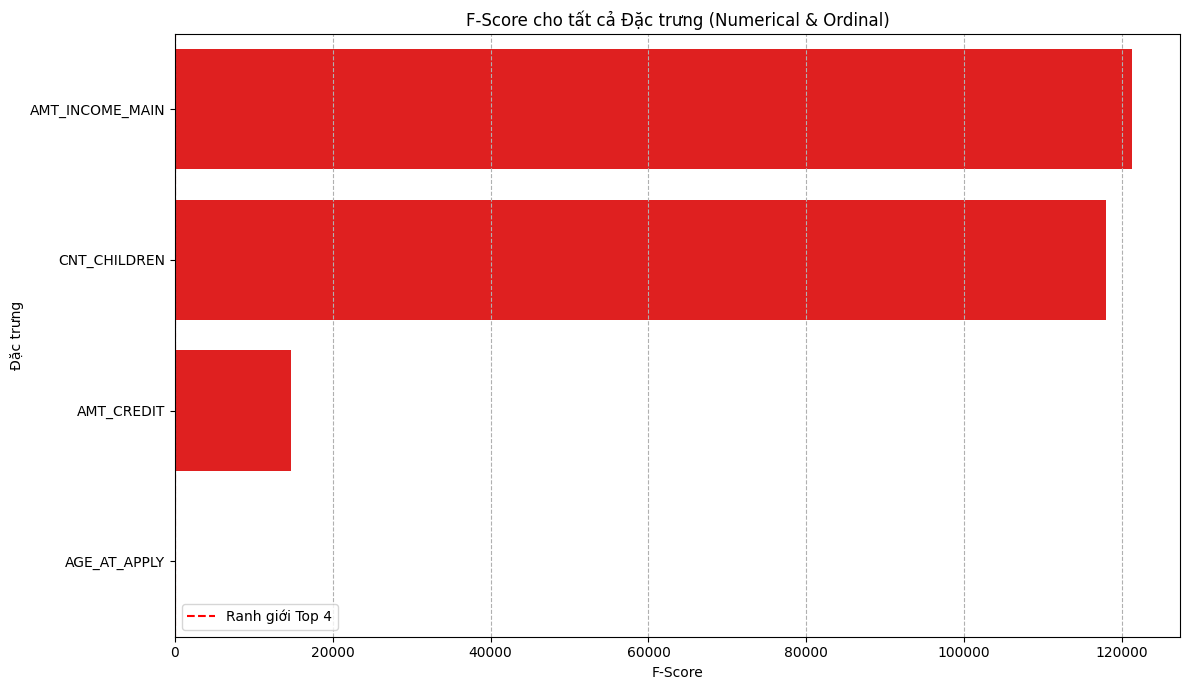

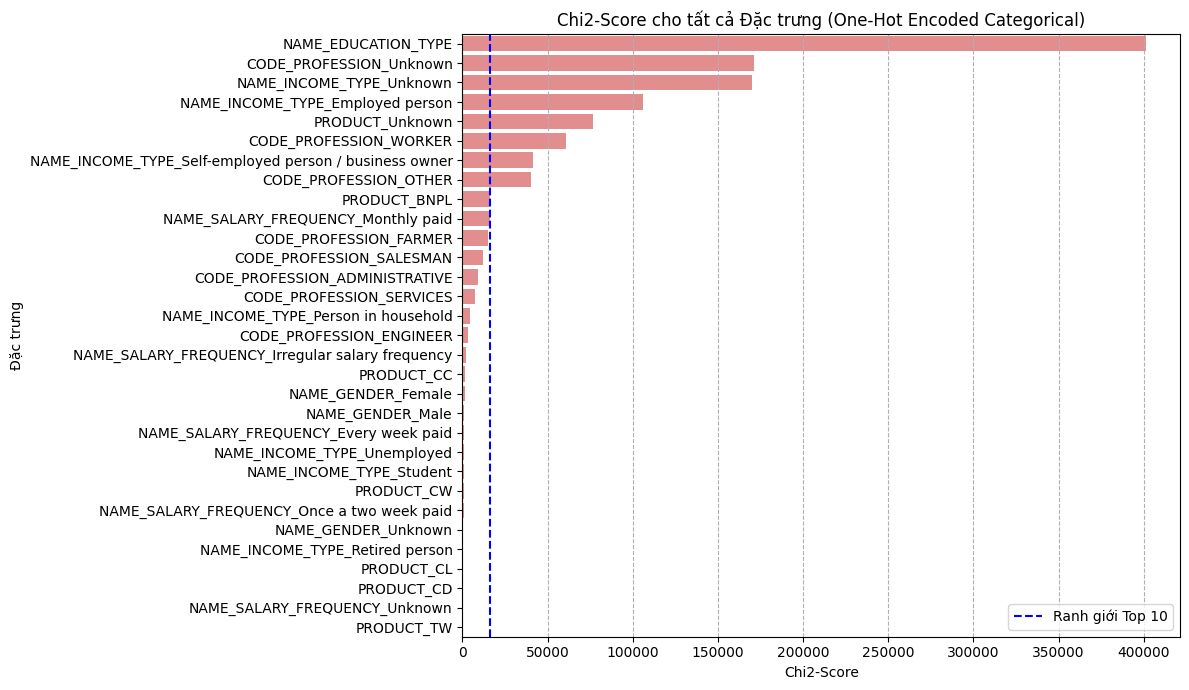

In [20]:
# --- 3. Đánh giá và Lựa chọn Đặc trưng Thống kê (Chọn Top 10 mỗi loại) ---
print("\n--- Bắt đầu đánh giá Đặc trưng bằng phương pháp Thống kê (Chọn Top 10 mỗi loại) ---")

# Tách các cột đã tiền xử lý thành các nhóm tương ứng để áp dụng kiểm định thống kê
numerical_and_ordinal_cols_for_anova = [col for col in numerical_cols + ['NAME_EDUCATION_TYPE_encoded'] if col in X_train_processed_df.columns]
one_hot_encoded_cols_for_chi2 = [col for col in feature_names_cleaned if col not in numerical_cols + ['NAME_EDUCATION_TYPE_encoded'] and col in X_train_processed_df.columns]

# Thực hiện kiểm định ANOVA F-value
if numerical_and_ordinal_cols_for_anova:
    f_scores, p_values_anova = f_classif(X_train_processed_df[numerical_and_ordinal_cols_for_anova], y_train)
    anova_results = pd.DataFrame({
        'Feature': numerical_and_ordinal_cols_for_anova,
        'F_Score': f_scores,
        'P_Value': p_values_anova
    }).sort_values(by='F_Score', ascending=False) # Sắp xếp theo F_Score để chọn Top N
else:
    anova_results = pd.DataFrame(columns=['Feature', 'F_Score', 'P_Value'])
print("\n--- Kết quả ANOVA F-value (Top 10 theo F_Score) ---")
print(anova_results.head(30)) # In ra top 10

# Thực hiện kiểm định Chi-squared
if one_hot_encoded_cols_for_chi2:
    chi2_scores, p_values_chi2 = chi2(X_train_processed_df[one_hot_encoded_cols_for_chi2], y_train)
    chi2_results = pd.DataFrame({
        'Feature': one_hot_encoded_cols_for_chi2,
        'Chi2_Score': chi2_scores,
        'P_Value': p_values_chi2
    }).sort_values(by='Chi2_Score', ascending=False) # Sắp xếp theo Chi2_Score để chọn Top N
else:
    chi2_results = pd.DataFrame(columns=['Feature', 'Chi2_Score', 'P_Value'])
print("\n--- Kết quả Chi-squared Test (Top 10 theo Chi2_Score) ---")
print(chi2_results.head(10)) # In ra top 10

# Giả sử anova_results và chi2_results đã được tạo và sắp xếp theo F_Score/Chi2_Score giảm dần

# --- Biểu đồ cho kết quả ANOVA F-value ---
plt.figure(figsize=(12, 7))
sns.barplot(x='F_Score', y='Feature', data=anova_results.head(len(anova_results)), color='red')
plt.axvline(x=anova_results['F_Score'].iloc[min(len(anova_results)-1, 9)], color='red', linestyle='--', label=f'Ranh giới Top {min(len(anova_results), 10)}')
plt.title('F-Score cho tất cả Đặc trưng (Numerical & Ordinal)')
plt.xlabel('F-Score')
plt.ylabel('Đặc trưng')
plt.grid(axis='x', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# --- Biểu đồ cho kết quả Chi-squared Test ---
plt.figure(figsize=(12, 7))
sns.barplot(x='Chi2_Score', y='Feature', data=chi2_results.head(len(chi2_results)), color='lightcoral')
plt.axvline(x=chi2_results['Chi2_Score'].iloc[min(len(chi2_results)-1, 9)], color='blue', linestyle='--', label=f'Ranh giới Top {min(len(chi2_results), 10)}')
plt.title('Chi2-Score cho tất cả Đặc trưng (One-Hot Encoded Categorical)')
plt.xlabel('Chi2-Score')
plt.ylabel('Đặc trưng')
plt.grid(axis='x', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:


# --- LỰA CHỌN ĐẶC TRƯNG: CHỈ LẤY TOP 10 MỖI LOẠI ---
N_anova_features = 4
N_chi2_features = 10



selected_anova_features = anova_results.head(N_anova_features)['Feature'].tolist()
selected_chi2_features = chi2_results.head(N_chi2_features)['Feature'].tolist()

selected_features_statistical_top_N = list(set(selected_anova_features + selected_chi2_features))

# Logic phòng ngừa nếu danh sách vẫn trống
if not selected_features_statistical_top_N:
    print("\nCẢNH BÁO: Không có đặc trưng nào được chọn từ top N. Sử dụng tất cả các đặc trưng đã tiền xử lý.")
    selected_features_statistical_top_N = feature_names_cleaned

# print(f"\n--- Đặc trưng được chọn bằng phương pháp Thống kê (Top {selected_features_statistical_top_N} mỗi loại) ---")
print(f"Số lượng đặc trưng được chọn: {len(selected_features_statistical_top_N)}")
print(f"Các đặc trưng được chọn: {selected_features_statistical_top_N}")

Số lượng đặc trưng được chọn: 14
Các đặc trưng được chọn: ['NAME_INCOME_TYPE_Unknown', 'PRODUCT_Unknown', 'AMT_INCOME_MAIN', 'NAME_SALARY_FREQUENCY_Monthly paid', 'AGE_AT_APPLY', 'PRODUCT_BNPL', 'CNT_CHILDREN', 'NAME_EDUCATION_TYPE', 'AMT_CREDIT', 'CODE_PROFESSION_WORKER', 'CODE_PROFESSION_Unknown', 'NAME_INCOME_TYPE_Employed person', 'NAME_INCOME_TYPE_Self-employed person / business owner', 'CODE_PROFESSION_OTHER']


In [22]:
# --- 4. Huấn luyện Mô hình với Đặc trưng đã chọn thống kê (Top N) ---
print("\n--- Bắt đầu huấn luyện mô hình RandomForestClassifier với đặc trưng đã chọn thống kê (Top N) ---")

X_train_selected_stat_top_N = X_train_processed_df[selected_features_statistical_top_N]
X_test_selected_stat_top_N = X_test_processed_df[selected_features_statistical_top_N]

# model_rf_stat_features_top_N = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
# model_rf_stat_features_top_N.fit(X_train_selected_stat_top_N, y_train)

# print("\nĐã huấn luyện mô hình RandomForest với đặc trưng đã chọn thống kê (Top N).")


# # Đánh giá hiệu suất trên tập huấn luyện
# y_pred_train_rf_stat_top_N = model_rf_stat_features_top_N.predict(X_train_selected_stat_top_N)
# y_proba_train_rf_stat_top_N = model_rf_stat_features_top_N.predict_proba(X_train_selected_stat_top_N)[:, 1]

# auc_train_rf_stat_top_N = roc_auc_score(y_train, y_proba_train_rf_stat_top_N)
# acc_train_rf_stat_top_N = accuracy_score(y_train, y_pred_train_rf_stat_top_N)

# print(f"\n--- Kết quả Đánh giá Mô hình RandomForest (Đặc trưng Top N thống kê) trên Tập HUẤN LUYỆN ---")
# print(f"Độ chính xác (Accuracy): {acc_train_rf_stat_top_N:.4f}")
# print(f"AUC-ROC Score: {auc_train_rf_stat_top_N:.4f}")
# print("Báo cáo phân loại:\n", classification_report(y_train, y_pred_train_rf_stat_top_N))



# # Đánh giá hiệu suất của mô hình này
# y_pred_test_rf_stat_top_N = model_rf_stat_features_top_N.predict(X_test_selected_stat_top_N)
# y_proba_test_rf_stat_top_N = model_rf_stat_features_top_N.predict_proba(X_test_selected_stat_top_N)[:, 1]

# auc_test_rf_stat_top_N = roc_auc_score(y_test, y_proba_test_rf_stat_top_N)
# acc_test_rf_stat_top_N = accuracy_score(y_test, y_pred_test_rf_stat_top_N)

# print(f"\n--- Kết quả Đánh giá Mô hình RandomForest (Đặc trưng Top N thống kê) trên Tập Kiểm tra ---")
# print(f"Độ chính xác (Accuracy): {acc_test_rf_stat_top_N:.4f}")
# print(f"AUC-ROC Score: {auc_test_rf_stat_top_N:.4f}")
# print("Báo cáo phân loại:\n", classification_report(y_test, y_pred_test_rf_stat_top_N))

# cm_rf_stat_top_N = confusion_matrix(y_test, y_pred_test_rf_stat_top_N, labels=model_rf_stat_features_top_N.classes_)
# disp_rf_stat_top_N = ConfusionMatrixDisplay(confusion_matrix=cm_rf_stat_top_N, display_labels=model_rf_stat_features_top_N.classes_)
# disp_rf_stat_top_N.plot(cmap=plt.cm.Blues)
# plt.title('Ma trận nhầm lẫn (RF - Đặc trưng Top N Thống kê)')
# plt.show()



--- Bắt đầu huấn luyện mô hình RandomForestClassifier với đặc trưng đã chọn thống kê (Top N) ---



--- Bắt đầu huấn luyện mô hình LightGBM Classifier (cấu hình cơ bản) ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1992069, number of negative: 486260
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.139164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 2478329, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.803795 -> initscore=1.410186
[LightGBM] [Info] Start training from score 1.410186

Đã huấn luyện mô hình LightGBM cơ bản hoàn tất.

--- Đánh giá Mô hình LightGBM (cấu hình cơ bản) ---

--- Kết quả dự đoán chi tiết (10 mẫu đầu) ---
   Actual  Predicted  P(Not Approve)  P(Approve)
0       1          1        0.165352    0.834648
1       1          0        0.519481   

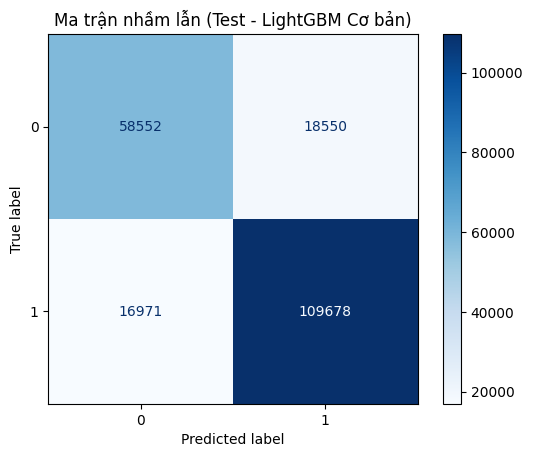

In [26]:
# --- 5. Xây dựng và Huấn luyện Mô hình LightGBM Classifier (cấu hình cơ bản) ---
import lightgbm as lgb

print("\n--- Bắt đầu huấn luyện mô hình LightGBM Classifier (cấu hình cơ bản) ---")

lgbm_model_base = lgb.LGBMClassifier(objective='binary', metric='auc', random_state=42, is_unbalance=True, n_jobs=-1)

lgbm_model_base.fit(X_train_selected_stat_top_N, y_train)

print("\nĐã huấn luyện mô hình LightGBM cơ bản hoàn tất.")

# --- Đánh giá Mô hình LightGBM (cấu hình cơ bản) ---
print("\n--- Đánh giá Mô hình LightGBM (cấu hình cơ bản) ---")
y_pred_train_lgbm_base = lgbm_model_base.predict(X_train_selected_stat_top_N)
y_proba_train_lgbm_base = lgbm_model_base.predict_proba(X_train_selected_stat_top_N)[:, 1]
auc_train_lgbm_base = roc_auc_score(y_train, y_proba_train_lgbm_base)
acc_train_lgbm_base = accuracy_score(y_train, y_pred_train_lgbm_base)

y_pred_test_lgbm_base = lgbm_model_base.predict(X_test_selected_stat_top_N)
y_proba_test_lgbm_base = lgbm_model_base.predict_proba(X_test_selected_stat_top_N)[:, 1]

# Tạo DataFrame chứa kết quả dự đoán trên tập test
results_df = pd.DataFrame({
    'Actual': y_test,  # Nhãn thực tế
    'Predicted': y_pred_test_lgbm_base,  # Lớp dự đoán (0/1)
    'P(Not Approve)': lgbm_model_base.predict_proba(X_test_selected_stat_top_N)[:, 0],  # Xác suất lớp 0
    'P(Approve)': y_proba_test_lgbm_base  # Xác suất lớp 1
})

# Xuất 10 dòng đầu tiên để kiểm tra
print("\n--- Kết quả dự đoán chi tiết (10 mẫu đầu) ---")
print(results_df.head(10))


auc_test_lgbm_base = roc_auc_score(y_test, y_proba_test_lgbm_base)
acc_test_lgbm_base = accuracy_score(y_test, y_pred_test_lgbm_base)

print(f"LightGBM (Cơ bản): AUC-ROC (Train) = {auc_train_lgbm_base:.4f}, Độ chính xác (Train) = {acc_train_lgbm_base:.4f}")
print(f"LightGBM (Cơ bản): AUC-ROC (Test) = {auc_test_lgbm_base:.4f}, Độ chính xác (Test) = {acc_test_lgbm_base:.4f}")
print(f"Chênh lệch AUC-ROC: {auc_train_lgbm_base - auc_test_lgbm_base:.4f}")
print(f"Chênh lệch Acc: {acc_train_lgbm_base - acc_test_lgbm_base:.4f}")
print("Báo cáo phân loại (Test - LightGBM Cơ bản):\n", classification_report(y_test, y_pred_test_lgbm_base))

cm_lgbm_base = confusion_matrix(y_test, y_pred_test_lgbm_base, labels=lgbm_model_base.classes_)
disp_lgbm_base = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm_base, display_labels=lgbm_model_base.classes_)
disp_lgbm_base.plot(cmap=plt.cm.Blues)
plt.title('Ma trận nhầm lẫn (Test - LightGBM Cơ bản)')
plt.show()

# # --- 6. Xây dựng và Huấn luyện Mô hình XGBoost Classifier (cấu hình cơ bản) ---
# import xgboost as xgb

# print("\n--- Bắt đầu huấn luyện mô hình XGBoost Classifier (cấu hình cơ bản) ---")

# xgb_model_base = xgb.XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='auc',
#     use_label_encoder=False,
#     random_state=42,
#     n_jobs=-1,
#     scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum()
# )

# xgb_model_base.fit(X_train_selected_stat_top_N, y_train)

# print("\nĐã huấn luyện mô hình XGBoost cơ bản hoàn tất.")

# # --- Đánh giá Mô hình XGBoost (cấu hình cơ bản) ---
# print("\n--- Đánh giá Mô hình XGBoost (cấu hình cơ bản) ---")
# y_pred_train_xgb_base = xgb_model_base.predict(X_train_selected_stat_top_N)
# y_proba_train_xgb_base = xgb_model_base.predict_proba(X_train_selected_stat_top_N)[:, 1]
# auc_train_xgb_base = roc_auc_score(y_train, y_proba_train_xgb_base)
# acc_train_xgb_base = accuracy_score(y_train, y_pred_train_xgb_base)

# y_pred_test_xgb_base = xgb_model_base.predict(X_test_selected_stat_top_N)
# y_proba_test_xgb_base = xgb_model_base.predict_proba(X_test_selected_stat_top_N)[:, 1]
# auc_test_xgb_base = roc_auc_score(y_test, y_proba_test_xgb_base)
# acc_test_xgb_base = accuracy_score(y_test, y_pred_test_xgb_base)

# print(f"XGBoost (Cơ bản): AUC-ROC (Train) = {auc_train_xgb_base:.4f}, Độ chính xác (Train) = {acc_train_xgb_base:.4f}")
# print(f"XGBoost (Cơ bản): AUC-ROC (Test) = {auc_test_xgb_base:.4f}, Độ chính xác (Test) = {acc_test_xgb_base:.4f}")
# print(f"Chênh lệch AUC-ROC: {auc_train_xgb_base - auc_test_xgb_base:.4f}")
# print(f"Chênh lệch Acc: {acc_train_xgb_base - acc_test_xgb_base:.4f}")
# print("Báo cáo phân loại (Test - XGBoost Cơ bản):\n", classification_report(y_test, y_pred_test_xgb_base))

# cm_xgb_base = confusion_matrix(y_test, y_pred_test_xgb_base, labels=xgb_model_base.classes_)
# disp_xgb_base = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_base, display_labels=xgb_model_base.classes_)
# disp_xgb_base.plot(cmap=plt.cm.Blues)
# plt.title('Ma trận nhầm lẫn (Test - XGBoost Cơ bản)')
# plt.show()


In [35]:
# Đếm số lượng và tính tỷ lệ
actual_counts = y_test.value_counts()
actual_ratio = y_test.value_counts(normalize=True) * 100

print("\n--- Tỷ lệ THỰC TẾ trong tập test ---")
print(f"Not Approve (0): {actual_counts.get(0, 0)} mẫu | {actual_ratio.get(0, 0):.2f}%")
print(f"Approve (1): {actual_counts.get(1, 0)} mẫu | {actual_ratio.get(1, 0):.2f}%")


--- Tỷ lệ THỰC TẾ trong tập test ---
Not Approve (0): 77102 mẫu | 37.84%
Approve (1): 126649 mẫu | 62.16%


In [36]:
# Đếm số lượng và tính tỷ lệ dự đoán
predicted_counts = pd.Series(y_pred_test_lgbm_base).value_counts()
predicted_ratio = pd.Series(y_pred_test_lgbm_base).value_counts(normalize=True) * 100

print("\n--- Tỷ lệ DỰ ĐOÁN từ model ---")
print(f"Not Approve (0): {predicted_counts.get(0, 0)} mẫu | {predicted_ratio.get(0, 0):.2f}%")
print(f"Approve (1): {predicted_counts.get(1, 0)} mẫu | {predicted_ratio.get(1, 0):.2f}%")


--- Tỷ lệ DỰ ĐOÁN từ model ---
Not Approve (0): 75523 mẫu | 37.07%
Approve (1): 128228 mẫu | 62.93%


In [41]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [42]:
# Tính toán tỷ lệ cân bằng thực tế
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
class_ratio = counts[0]/counts[1] if len(counts) > 1 else 0

print("\n--- Phân tích cân bằng lớp ---")
print(f"Số lượng mẫu train - Lớp 0: {counts[0]}, Lớp 1: {counts[1]}")
print(f"Tỷ lệ lớp 0/lớp 1: {class_ratio:.2f}:1")
print(f"Trọng số tự động được áp dụng (scale_pos_weight): ~{class_ratio:.2f}")

# Kiểm tra hiệu quả trên lớp thiểu số (Approve)
approve_recall = recall_score(y_test, y_pred_test_lgbm_base, pos_label=1)
approve_precision = precision_score(y_test, y_pred_test_lgbm_base, pos_label=1)
print(f"\nHiệu suất lớp Approve (1):")
print(f"- Recall: {approve_recall:.4f} (tỷ lệ phát hiện đúng)")
print(f"- Precision: {approve_precision:.4f} (tỷ lệ dự đoán đúng)")


--- Phân tích cân bằng lớp ---
Số lượng mẫu train - Lớp 0: 486260, Lớp 1: 1992069
Tỷ lệ lớp 0/lớp 1: 0.24:1
Trọng số tự động được áp dụng (scale_pos_weight): ~0.24

Hiệu suất lớp Approve (1):
- Recall: 0.8660 (tỷ lệ phát hiện đúng)
- Precision: 0.8553 (tỷ lệ dự đoán đúng)


In [40]:
lgbm_model_balanced = lgb.LGBMClassifier(objective='binary', 
                                       metric='auc', 
                                       random_state=42, 
                                       is_unbalance=False,  # Tắt cân bằng
                                       n_jobs=-1)
lgbm_model_balanced.fit(X_train_selected_stat_top_N, y_train)

# Đánh giá
y_pred_balanced = lgbm_model_balanced.predict(X_test_selected_stat_top_N)
print("\n--- Khi KHÔNG dùng is_unbalance=True ---")
print(classification_report(y_test, y_pred_balanced))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1992069, number of negative: 486260
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 2478329, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.803795 -> initscore=1.410186
[LightGBM] [Info] Start training from score 1.410186

--- Khi KHÔNG dùng is_unbalance=True ---
              precision    recall  f1-score   support

           0       0.99      0.66      0.80     77102
           1       0.83      1.00      0.91    126649

    accuracy                           0.87    203751
   macro avg       0.91      0.83      0.85    203751
weighted avg       0.89      0.87      0.86   


--- Bắt đầu huấn luyện mô hình LightGBM Classifier (cấu hình cơ bản) ---
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1992069, number of negative: 486260
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.196855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 671
[LightGBM] [Info] Number of data points in the train set: 2478329, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.803795 -> initscore=1.410186
[LightGBM] [Info] Start training from score 1.410186

Đã huấn luyện mô hình LightGBM cơ bản hoàn tất.

--- Đánh giá Mô hình LightGBM (cấu hình cơ bản) ---

--- Kết quả dự đoán chi tiết (10 mẫu đầu) ---
   Actual  Predicted  P(Not Approve)  P(Approve)
0       1          1        0.165352    0.834648
1       1          0        0.519481   

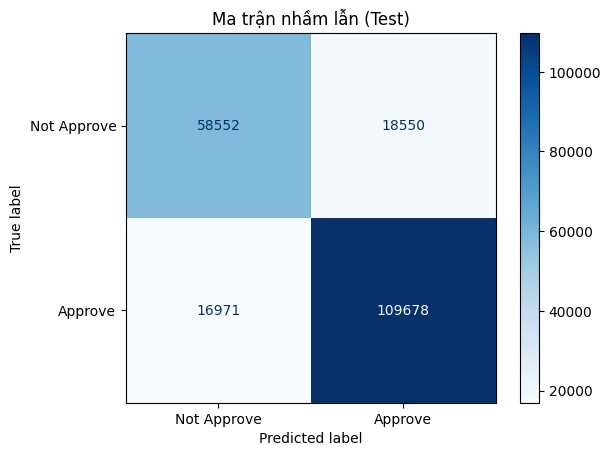

In [43]:
# --- Import đầy đủ ---
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# --- Huấn luyện mô hình ---
print("\n--- Bắt đầu huấn luyện mô hình LightGBM Classifier (cấu hình cơ bản) ---")

lgbm_model_base = lgb.LGBMClassifier(objective='binary', metric='auc', random_state=42, is_unbalance=True, n_jobs=-1)
lgbm_model_base.fit(X_train_selected_stat_top_N, y_train)

print("\nĐã huấn luyện mô hình LightGBM cơ bản hoàn tất.")

# --- Đánh giá mô hình ---
print("\n--- Đánh giá Mô hình LightGBM (cấu hình cơ bản) ---")

# Dự đoán trên tập test
y_pred_test_lgbm_base = lgbm_model_base.predict(X_test_selected_stat_top_N)
y_proba_test_lgbm_base = lgbm_model_base.predict_proba(X_test_selected_stat_top_N)[:, 1]

# Tạo DataFrame kết quả
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test_lgbm_base,
    'P(Not Approve)': lgbm_model_base.predict_proba(X_test_selected_stat_top_N)[:, 0],
    'P(Approve)': y_proba_test_lgbm_base
})

# In 10 mẫu đầu
print("\n--- Kết quả dự đoán chi tiết (10 mẫu đầu) ---")
print(results_df.head(10))

# Tính các metrics
auc_test = roc_auc_score(y_test, y_proba_test_lgbm_base)
acc_test = accuracy_score(y_test, y_pred_test_lgbm_base)
recall_approve = recall_score(y_test, y_pred_test_lgbm_base, pos_label=1)
precision_approve = precision_score(y_test, y_pred_test_lgbm_base, pos_label=1)

# Phân tích cân bằng lớp
unique, counts = np.unique(y_train, return_counts=True)
class_ratio = counts[0]/counts[1] if len(counts) > 1 else 0

print("\n--- Phân tích hiệu suất ---")
print(f"Tỷ lệ lớp 0/lớp 1 trong train: {class_ratio:.2f}:1")
print(f"AUC-ROC: {auc_test:.4f}")
print(f"Accuracy: {acc_test:.4f}")
print(f"Recall (Approve): {recall_approve:.4f}")
print(f"Precision (Approve): {precision_approve:.4f}")
print("\nBáo cáo phân loại đầy đủ:\n", classification_report(y_test, y_pred_test_lgbm_base))

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred_test_lgbm_base)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Approve', 'Approve'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Ma trận nhầm lẫn (Test)')
plt.show()

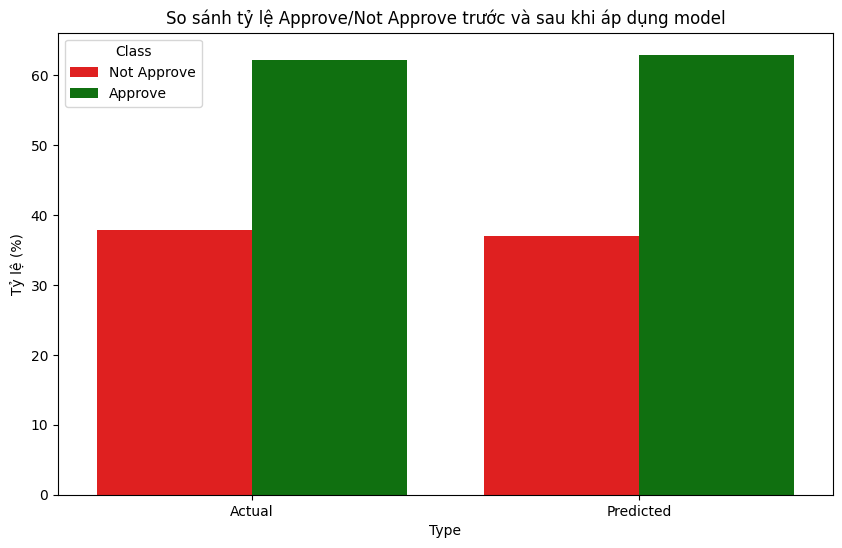

In [37]:
# Chuẩn bị dữ liệu
ratio_df = pd.DataFrame({
    'Type': ['Actual', 'Actual', 'Predicted', 'Predicted'],
    'Class': ['Not Approve', 'Approve', 'Not Approve', 'Approve'],
    'Percentage': [actual_ratio.get(0, 0), actual_ratio.get(1, 0), 
                   predicted_ratio.get(0, 0), predicted_ratio.get(1, 0)]
})

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.barplot(x='Type', y='Percentage', hue='Class', data=ratio_df, palette=['red', 'green'])
plt.title('So sánh tỷ lệ Approve/Not Approve trước và sau khi áp dụng model')
plt.ylabel('Tỷ lệ (%)')
plt.show()


--- Tỉ lệ dự đoán ---
Tỉ lệ Not Approve (0): 37.07%
Tỉ lệ Approve (1): 62.93%


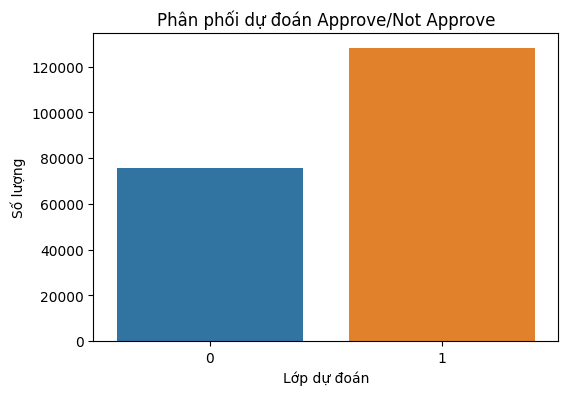

In [30]:
# Tính tỉ lệ các lớp trong dự đoán
pred_distribution = results_df['Predicted'].value_counts(normalize=True) * 100

print("\n--- Tỉ lệ dự đoán ---")
print(f"Tỉ lệ Not Approve (0): {pred_distribution.get(0, 0):.2f}%")
print(f"Tỉ lệ Approve (1): {pred_distribution.get(1, 0):.2f}%")

# Vẽ biểu đồ phân phối
plt.figure(figsize=(6, 4))
sns.countplot(x='Predicted', data=results_df)
plt.title('Phân phối dự đoán Approve/Not Approve')
plt.xlabel('Lớp dự đoán')
plt.ylabel('Số lượng')
plt.show()

In [31]:
# Tính tỉ lệ lớp thực tế trong tập test
actual_distribution = pd.Series(y_test).value_counts(normalize=True) * 100

print("\n--- Tỉ lệ thực tế trong tập test ---")
print(f"Tỉ lệ Not Approve (0): {actual_distribution.get(0, 0):.2f}%")
print(f"Tỉ lệ Approve (1): {actual_distribution.get(1, 0):.2f}%")


--- Tỉ lệ thực tế trong tập test ---
Tỉ lệ Not Approve (0): 37.84%
Tỉ lệ Approve (1): 62.16%



=== Thông số mô hình LightGBM ===
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'binary', 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'metric': 'auc', 'is_unbalance': True}

=== Dự đoán mẫu (5 dòng đầu) ===
Dự đoán lớp: [1 0 1 1 1]
Xác suất dự đoán:
 [[0.1653518  0.8346482 ]
 [0.51948056 0.48051944]
 [0.12563385 0.87436615]
 [0.11680743 0.88319257]
 [0.26514395 0.73485605]]

=== Feature Importance ===
1. NAME_INCOME_TYPE_Unknown: 80
2. PRODUCT_Unknown: 82
3. AMT_INCOME_MAIN: 397
4. NAME_SALARY_FREQUENCY_Monthly paid: 79
5. AGE_AT_APPLY: 429
6. PRODUCT_BNPL: 36
7. CNT_CHILDREN: 118
8. NAME_EDUCATION_TYPE: 250
9. AMT_CREDIT: 1309
10. CODE_PROFESSION_WORKER: 34
11. CODE_PROFESS

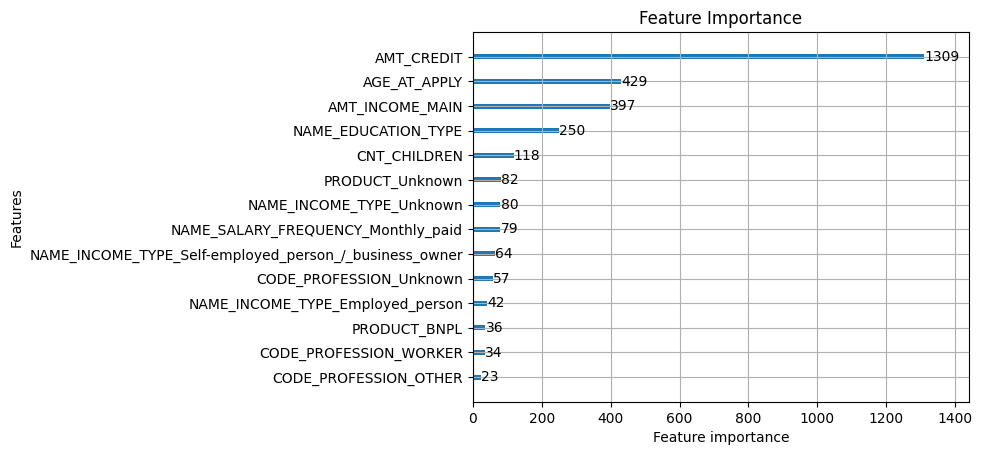

In [24]:
# In các thông số của mô hình đã được huấn luyện
print("\n=== Thông số mô hình LightGBM ===")
print(lgbm_model_base.get_params())

# In một số dự đoán mẫu
print("\n=== Dự đoán mẫu (5 dòng đầu) ===")
sample_predictions = lgbm_model_base.predict(X_test_selected_stat_top_N[:5])
sample_probabilities = lgbm_model_base.predict_proba(X_test_selected_stat_top_N[:5])
print("Dự đoán lớp:", sample_predictions)
print("Xác suất dự đoán:\n", sample_probabilities)

# In feature importance
print("\n=== Feature Importance ===")
for i, (feature, importance) in enumerate(zip(X_train_selected_stat_top_N.columns, 
                                            lgbm_model_base.feature_importances_)):
    print(f"{i+1}. {feature}: {importance}")

# Hoặc vẽ biểu đồ feature importance
lgb.plot_importance(lgbm_model_base)
plt.title('Feature Importance')
plt.show()

In [25]:
y_pred = lgbm_model_base.predict(X_test)  # Trả về 0 hoặc 1

ValueError: Number of features of the model must match the input. Model n_features_ is 14 and input n_features is 11

In [28]:
results_df = X_test_selected_stat_top_N.copy() # Bắt đầu với các đặc trưng đầu vào của tập test
results_df['True_Target'] = y_test # Thêm giá trị thực tế của biến mục tiêu
results_df['Predicted_Class'] = y_pred_test_lgbm_base # Thêm lớp dự đoán (0 hoặc 1)
results_df['Predicted_Probability_Approved'] = y_proba_test_lgbm_base # Thêm xác suất dự đoán cho lớp 'Approved' (lớp 1)


# 2. Xem các dòng đầu tiên của kết quả để có cái nhìn tổng quan
print("\n--- Thông tin khách hàng và kết quả dự đoán của mô hình (Top 5) ---")
print(results_df.head())

# # 3. Phân tích các trường hợp cụ thể (ví dụ: khách hàng bị dự đoán sai)
# print("\n--- Ví dụ Khách hàng bị dự đoán sai (False Negatives - Approved thực tế nhưng dự đoán Not Approved) ---")
# false_negatives = results_df[(results_df['True_Target'] == 1) & (results_df['Predicted_Class'] == 0)]
# print(false_negatives.head())
# print(f"Tổng số False Negatives: {len(false_negatives)}")


# print("\n--- Ví dụ Khách hàng bị dự đoán sai (False Positives - Not Approved thực tế nhưng dự đoán Approved) ---")
# false_positives = results_df[(results_df['True_Target'] == 0) & (results_df['Predicted_Class'] == 1)]
# print(false_positives.head())
# print(f"Tổng số False Positives: {len(false_positives)}")



--- Thông tin khách hàng và kết quả dự đoán của mô hình (Top 5) ---
   NAME_SALARY_FREQUENCY_Monthly paid  CODE_PROFESSION_OTHER  PRODUCT_BNPL  \
0                                 0.0                    1.0           0.0   
1                                 0.0                    1.0           0.0   
2                                 0.0                    0.0           0.0   
3                                 0.0                    0.0           0.0   
4                                 0.0                    0.0           0.0   

   AMT_CREDIT  AMT_INCOME_MAIN  CODE_PROFESSION_Unknown  \
0   -0.492739         0.533186                      0.0   
1    0.268906         0.533186                      0.0   
2    0.044066         1.238767                      0.0   
3   -0.296004         1.415162                      0.0   
4    0.268906        -1.230764                      1.0   

   CODE_PROFESSION_WORKER  PRODUCT_Unknown  CNT_CHILDREN  \
0                     0.0              0.0     

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.900062	train's binary_logloss: 0.324016	test's auc: 0.885646	test's binary_logloss: 0.41047
Early stopping, best iteration is:
[24]	train's auc: 0.892883	train's binary_logloss: 0.364367	test's auc: 0.887988	test's binary_logloss: 0.479868

=== Đánh giá trên tập TRAIN ===
AUC: 0.8929
Accuracy: 0.9442
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.72      0.83    486260
           1       0.94      1.00      0.97   1992069

    accuracy                           0.94   2478329
   macro avg       0.97      0.86      0.90   2478329
weighted avg       0.95      0.94      0.94   2478329

F1-score lớp 0: 0.8342

=== Đánh giá trên tập TEST ===
AUC: 0.8880
Accuracy: 0.8710
Classification Report:


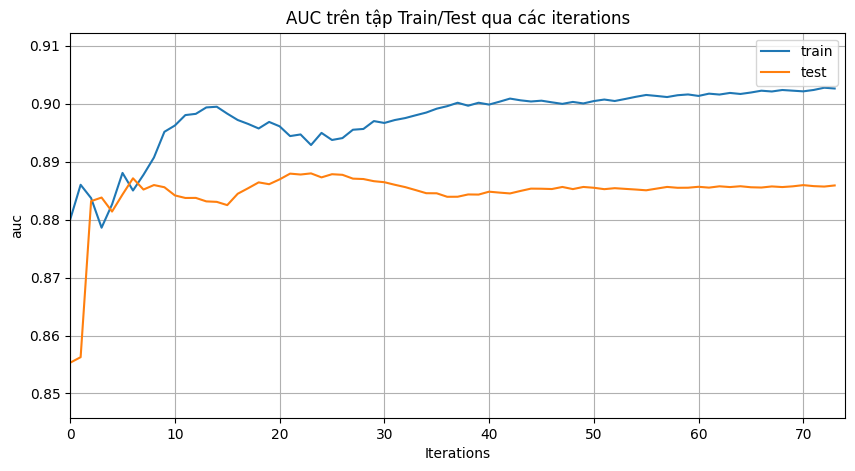

In [29]:
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# Tính toán scale_pos_weight
n_class0 = len(y_train[y_train == 0])
n_class1 = len(y_train[y_train == 1])
scale_pos_weight = n_class0 / n_class1


# params = {
#     'objective': 'binary',
#     'metric': ['auc', 'binary_logloss'],
#     'scale_pos_weight': scale_pos_weight,
#     'num_leaves': 31,  # Giảm 50% (từ 63)
#     'min_child_samples': 200,  # Tăng gấp đôi
#     'learning_rate': 0.05,  # Giảm tốc độ học
#     'feature_fraction': 0.7,
#     'reg_alpha': 0.5,  # Tăng L1 regularization
#     'reg_lambda': 0.5,  # Tăng L2 regularization
#     'verbosity': -1
# }

params = {
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],
    'scale_pos_weight': scale_pos_weight,
    'num_leaves': 24,  # Giảm thêm từ 31 để giảm overfitting
    'min_child_samples': 300,  # Tăng từ 200
    'learning_rate': 0.03,  # Giảm tốc độ học
    'feature_fraction': 0.6,  # Giảm từ 0.7
    'bagging_fraction': 0.8,  # Thêm bagging
    'bagging_freq': 5,  # Bagging mỗi 5 iterations
    'reg_alpha': 1.0,  # Tăng regularization L1
    'reg_lambda': 1.0,  # Tăng regularization L2
    'max_depth': 6,  # Giới hạn độ sâu
    'min_split_gain': 0.1,  # Thêm điều kiện phân chia
    'verbosity': -1,
    'seed': 42
}

# Huấn luyện và theo dõi trên cả train/test
eval_results = {}
model = lgb.train(
    params,
    train_set=lgb.Dataset(X_train_selected_stat_top_N, y_train),
    num_boost_round=1000,
    valid_sets=[
        lgb.Dataset(X_train_selected_stat_top_N, y_train, free_raw_data=False).construct(),
        lgb.Dataset(X_test_selected_stat_top_N, y_test, free_raw_data=False).construct()
    ],
    valid_names=['train', 'test'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(50),
        lgb.record_evaluation(eval_results)  # Lưu kết quả đánh giá
    ]
)

# Hàm đánh giá chi tiết
def print_evaluation(X, y, dataset_name):
    y_proba = model.predict(X)
    y_pred = (y_proba > 0.5).astype(int)
    
    print(f"\n=== Đánh giá trên tập {dataset_name} ===")
    print(f"AUC: {roc_auc_score(y, y_proba):.4f}")
    print(f"Accuracy: {accuracy_score(y, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y, y_pred))
    
    # Tính toán thêm F1 cho lớp thiểu số (lớp 0)
    report = classification_report(y, y_pred, output_dict=True)
    f1_class0 = report['0']['f1-score']
    print(f"F1-score lớp 0: {f1_class0:.4f}")

# Đánh giá trên tập TRAIN
print_evaluation(X_train_selected_stat_top_N, y_train, "TRAIN")

# Đánh giá trên tập TEST
print_evaluation(X_test_selected_stat_top_N, y_test, "TEST")

# Phân tích chênh lệch
print("\n=== PHÂN TÍCH OVERFITTING ===")
train_auc = roc_auc_score(y_train, model.predict(X_train_selected_stat_top_N))
test_auc = roc_auc_score(y_test, model.predict(X_test_selected_stat_top_N))
print(f"Chênh lệch AUC (Train - Test): {train_auc - test_auc:.4f}")

# Vẽ đồ thị AUC qua các epochs
lgb.plot_metric(eval_results, metric='auc', figsize=(10, 5))
plt.title("AUC trên tập Train/Test qua các iterations")
plt.show()

## Model 2

## 

In [90]:
# Create product type mapping for training data
merged_inner_train_MD['PRODUCT'] = merged_inner_train_MD['PRODUCT'].map(product_mapping)

# Create product type mapping for test data 
merged_inner_test_MD['PRODUCT'] = merged_inner_test_MD['PRODUCT'].map(product_mapping)

# Convert AGE_AT_APPLY column to integer in both training and test datasets
merged_inner_train_MD['AGE_AT_APPLY'] = merged_inner_train_MD['AGE_AT_APPLY'].astype(int)
merged_inner_test_MD['AGE_AT_APPLY'] = merged_inner_test_MD['AGE_AT_APPLY'].astype(int)


In [91]:
# Drop first, second, third, fourth due columns
columns_to_drop = ['FIRST_DUE', 'SECOND_DUE', 'THIRD_DUE', 'FOURTH_DUE']
merged_inner_train_MD = merged_inner_train_MD.drop(columns=columns_to_drop)
merged_inner_test_MD = merged_inner_test_MD.drop(columns=columns_to_drop)


In [93]:
# Fill missing values in AMT_INCOME_MAIN with median
income_median = merged_inner_train_MD['AMT_INCOME_MAIN'].median()
merged_inner_train_MD['AMT_INCOME_MAIN'] = merged_inner_train_MD['AMT_INCOME_MAIN'].fillna(income_median)
merged_inner_test_MD['AMT_INCOME_MAIN'] = merged_inner_test_MD['AMT_INCOME_MAIN'].fillna(income_median)

# Replace zeros with 1 to avoid division by zero
merged_inner_train_MD['AMT_INCOME_MAIN'] = merged_inner_train_MD['AMT_INCOME_MAIN'].replace(0, 1)
merged_inner_test_MD['AMT_INCOME_MAIN'] = merged_inner_test_MD['AMT_INCOME_MAIN'].replace(0, 1)

# Ensure AMT_CREDIT is at least 1 to avoid division by zero
merged_inner_train_MD['AMT_CREDIT'] = merged_inner_train_MD['AMT_CREDIT'].replace(0, 1)
merged_inner_test_MD['AMT_CREDIT'] = merged_inner_test_MD['AMT_CREDIT'].replace(0, 1)

# Calculate Credit to Income Ratio
merged_inner_train_MD['CREDIT_INCOME_RATIO'] = merged_inner_train_MD['AMT_CREDIT'] / merged_inner_train_MD['AMT_INCOME_MAIN']
merged_inner_test_MD['CREDIT_INCOME_RATIO'] = merged_inner_test_MD['AMT_CREDIT'] / merged_inner_test_MD['AMT_INCOME_MAIN']

# Calculate Annuity to Income Ratio
merged_inner_train_MD['ANNUITY_INCOME_RATIO'] = merged_inner_train_MD['ANNUITY'] / merged_inner_train_MD['AMT_INCOME_MAIN']
merged_inner_test_MD['ANNUITY_INCOME_RATIO'] = merged_inner_test_MD['ANNUITY'] / merged_inner_test_MD['AMT_INCOME_MAIN']

# Calculate Down Payment Ratio
merged_inner_train_MD['DOWN_PAYMENT_RATIO'] = merged_inner_train_MD['INIT_PAY'] / merged_inner_train_MD['AMT_CREDIT']
merged_inner_test_MD['DOWN_PAYMENT_RATIO'] = merged_inner_test_MD['INIT_PAY'] / merged_inner_test_MD['AMT_CREDIT']


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


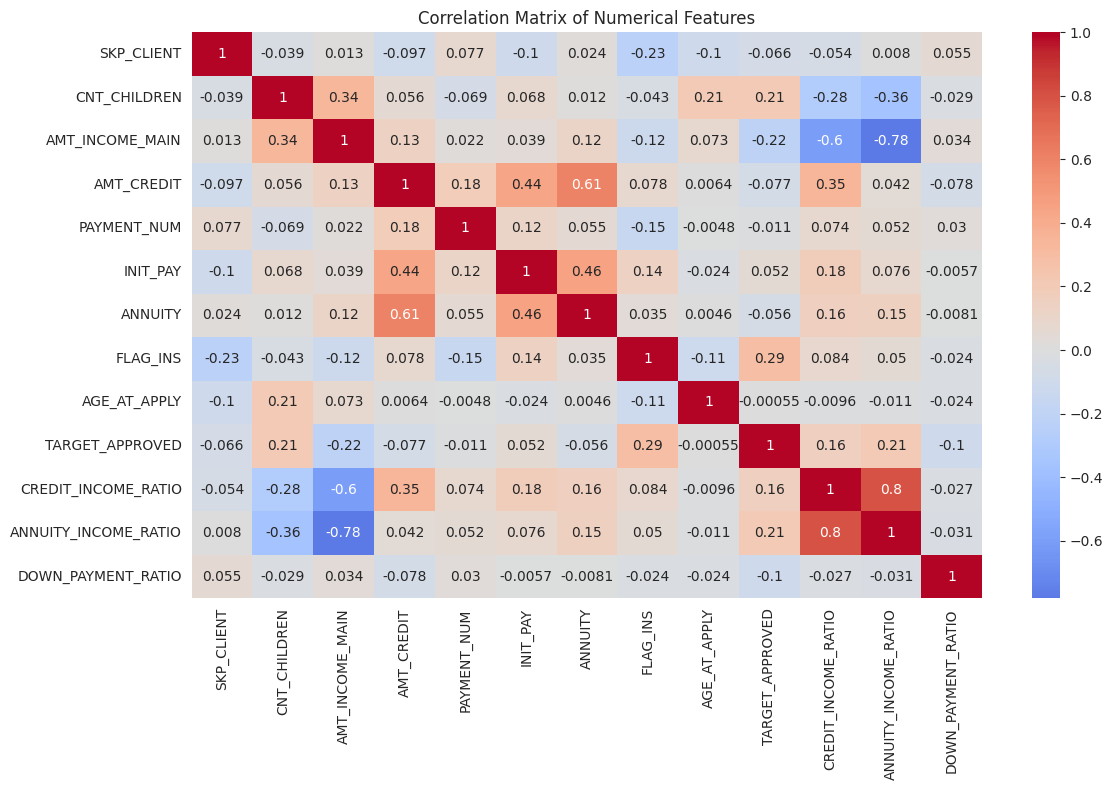

In [94]:
# Select numerical columns
numerical_cols = merged_inner_train_MD.select_dtypes(include=['int64', 'float64']).columns

# Calculate correlation matrix
correlation_matrix = merged_inner_train_MD[numerical_cols].corr()

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()


In [95]:
# Drop ANNUITY_INCOME_RATIO column
merged_inner_train_MD = merged_inner_train_MD.drop('ANNUITY_INCOME_RATIO', axis=1)
merged_inner_test_MD = merged_inner_test_MD.drop('ANNUITY_INCOME_RATIO', axis=1)


In [96]:
# Model 2: Intelligent Lead-SA Matching

# Add probability of approval from Model 1 as new feature
# For LightGBM Booster, use predict() with raw_score=False to get probabilities
approval_probs_train = lgbm_model_base.predict_proba(X_train_selected_stat_top_N, raw_score=False)[:, 1]
approval_probs_test = lgbm_model_base.predict_proba(X_test_selected_stat_top_N, raw_score=False)[:, 1]

merged_inner_train_MD['APPROVAL_PROBABILITY'] = approval_probs_train
merged_inner_test_MD['APPROVAL_PROBABILITY'] = approval_probs_test

# Select features for clustering
cluster_features = ['APPROVAL_PROBABILITY', 'AMT_CREDIT', 'AMT_INCOME_MAIN', 'AGE_AT_APPLY', 'PRODUCT', 'ANNUITY', 'CREDIT_INCOME_RATIO', 'DOWN_PAYMENT_RATIO']

# Prepare data for clustering
X_cluster = merged_inner_train_MD[cluster_features].copy()

In [97]:
# Standardize features
from sklearn.preprocessing import StandardScaler
# Separate numerical and categorical columns
numerical_cols = X_cluster.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_cluster.select_dtypes(include=['object']).columns

# Scale numerical features
scaler = StandardScaler()
X_cluster_numerical = pd.DataFrame(scaler.fit_transform(X_cluster[numerical_cols]), 
                                 columns=numerical_cols,
                                 index=X_cluster.index)

# One-hot encode categorical features 
X_cluster_categorical = pd.get_dummies(X_cluster[categorical_cols])

# Combine scaled numerical and one-hot encoded categorical features
X_cluster_scaled = pd.concat([X_cluster_numerical, X_cluster_categorical], axis=1)


# Determine optimal number of clusters using elbow method
from sklearn.cluster import KMeans


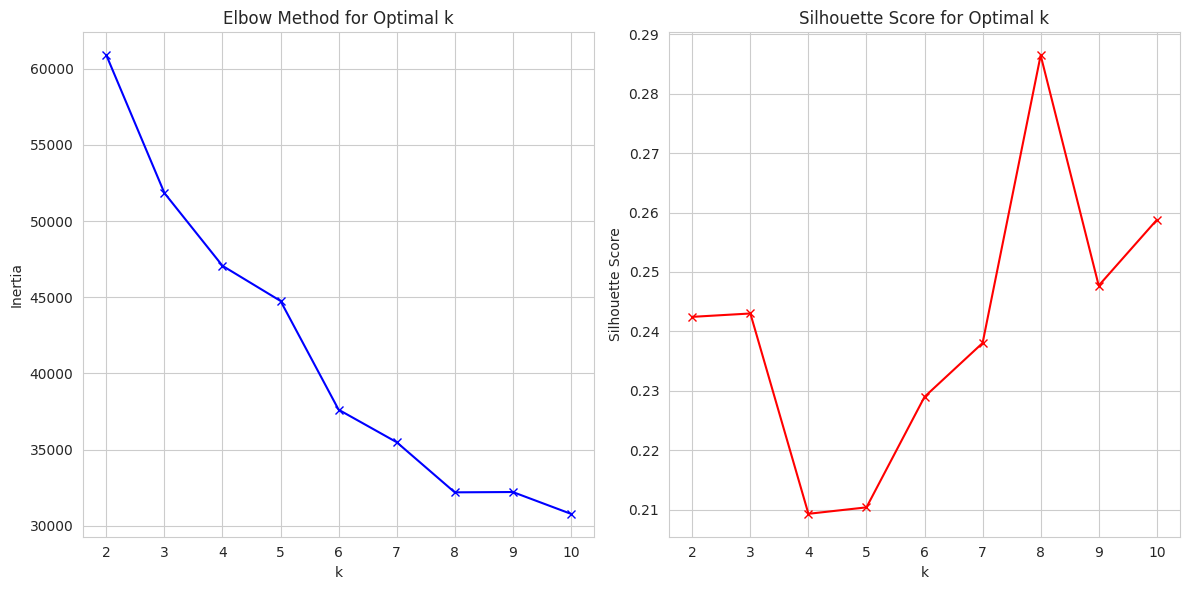

Tested on 10000 samples out of 2478329 total samples


In [98]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.utils import resample

# Reduce the range of K values to test
K = range(2, 11)  # Reduced from 2-8 to 2-6

# Use a smaller sample for faster evaluation
sample_size = min(10000, len(X_cluster_scaled))  # Limit to 10k samples
X_cluster_sample = resample(X_cluster_scaled, n_samples=sample_size, random_state=42)
inertias = []
silhouette_scores = []

for k in K:
    # Increase batch_size for faster processing
    minibatch_kmeans = MiniBatchKMeans(
        n_clusters=k, 
        random_state=42, 
        batch_size=2000,  # Increased from 1000
        max_iter=100,     # Reduced from default 300
        n_init=3          # Reduced from default 10
    )
    minibatch_kmeans.fit(X_cluster_sample)
    inertias.append(minibatch_kmeans.inertia_)
    
    # Calculate silhouette score on a smaller sample for speed
    silhouette_sample_size = min(5000, len(X_cluster_sample))
    if len(X_cluster_sample) > silhouette_sample_size:
        silhouette_indices = np.random.choice(len(X_cluster_sample), silhouette_sample_size, replace=False)
        silhouette_sample = X_cluster_sample.iloc[silhouette_indices]
        silhouette_labels = minibatch_kmeans.labels_[silhouette_indices]
    else:
        silhouette_sample = X_cluster_sample
        silhouette_labels = minibatch_kmeans.labels_
    
    silhouette_scores.append(silhouette_score(silhouette_sample, silhouette_labels))

# Plot elbow curve
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.tight_layout()
plt.show()

print(f"Tested on {len(X_cluster_sample)} samples out of {len(X_cluster_scaled)} total samples")

In [99]:
# Perform clustering with optimal k=4
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
merged_inner_train_MD['CLUSTER'] = kmeans.fit_predict(X_cluster_scaled)

# Analyze cluster characteristics
cluster_profiles = merged_inner_train_MD.groupby('CLUSTER').agg({
    'APPROVAL_PROBABILITY': 'mean',
    'AMT_CREDIT': 'mean',
    'AGE_AT_APPLY': 'mean',
    'AMT_INCOME_MAIN': 'mean',
    'ANNUITY': 'mean',
    'NAME_INCOME_TYPE': lambda x: x.mode()[0] if not x.mode().empty else None,
    'CREDIT_INCOME_RATIO': 'mean',
    'DOWN_PAYMENT_RATIO': 'mean',
    'NAME_EDUCATION_TYPE': lambda x: x.mode()[0] if not x.mode().empty else None,
    'PRODUCT': lambda x: x.mode()[0] if not x.mode().empty else None
}).round(2)

print("\nCluster Profiles:")
print(cluster_profiles)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Cluster Profiles:
         APPROVAL_PROBABILITY  AMT_CREDIT  AGE_AT_APPLY  AMT_INCOME_MAIN  \
CLUSTER                                                                    
0                        0.45  7975071.89         34.75      11309212.64   
1                        0.76  2928823.93         34.24       7224246.01   
2                        0.05        1.00         30.26      10537535.00   
3                        0.81  6694619.71         33.90             1.00   

            ANNUITY NAME_INCOME_TYPE  CREDIT_INCOME_RATIO  DOWN_PAYMENT_RATIO  \
CLUSTER                                                                         
0        1371096.96          Unknown                26.83                0.33   
1         833710.61  Employed person            356199.56                4.89   
2         991000.00          Unknown                 0.03          1611913.08   
3        1167534.87          Unknown           6694619.71                0.40   

           NAME_EDUCATION_TYPE       

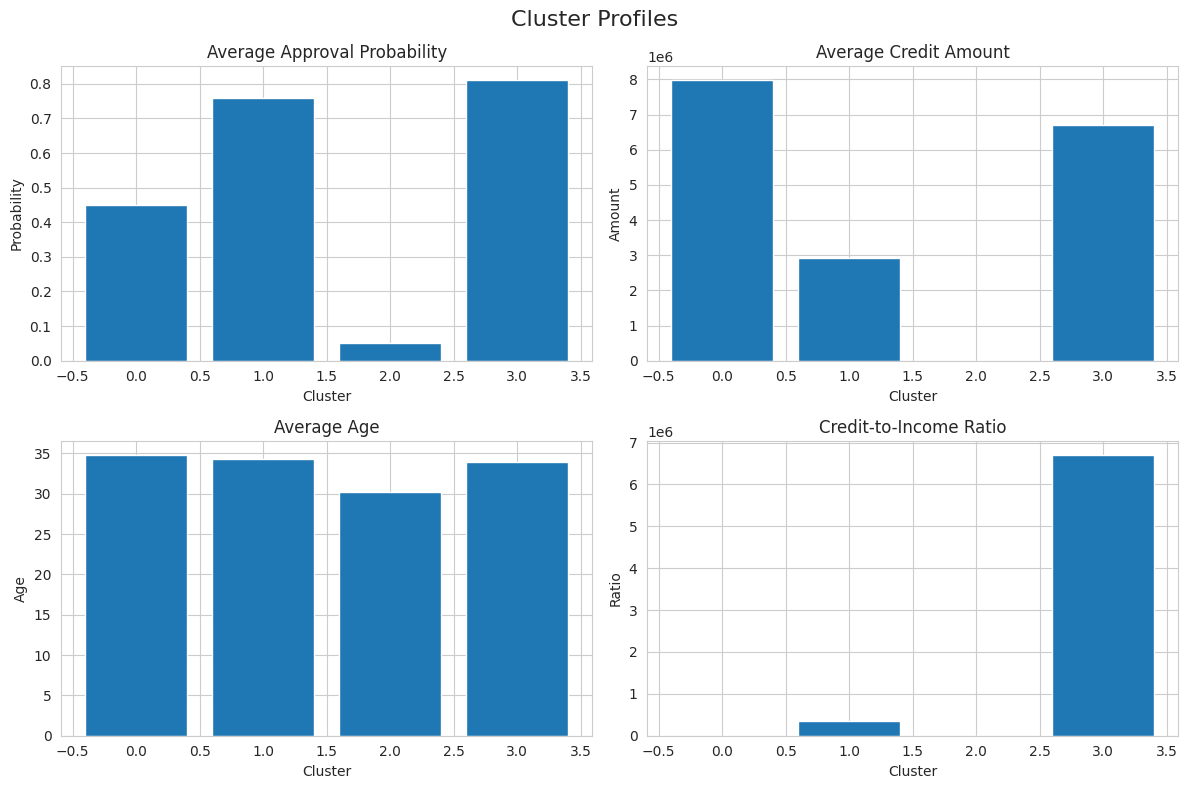


Most Common Categories by Cluster:
        Most Common Income Type  Most Common Education Most Common Product
CLUSTER                                                                   
0                       Unknown                Unknown    Consumer Durable
1               Employed person  High school education    Consumer Durable
2                       Unknown                Unknown    Consumer Durable
3                       Unknown                Unknown    Consumer Durable


In [100]:
# Create a figure with multiple subplots for key metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Cluster Profiles', fontsize=16)

# Plot average approval probability by cluster
axes[0,0].bar(cluster_profiles.index, cluster_profiles['APPROVAL_PROBABILITY'])
axes[0,0].set_title('Average Approval Probability')
axes[0,0].set_xlabel('Cluster')
axes[0,0].set_ylabel('Probability')

# Plot average credit amount by cluster
axes[0,1].bar(cluster_profiles.index, cluster_profiles['AMT_CREDIT'])
axes[0,1].set_title('Average Credit Amount')
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('Amount')

# Plot average age by cluster
axes[1,0].bar(cluster_profiles.index, cluster_profiles['AGE_AT_APPLY'])
axes[1,0].set_title('Average Age')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('Age')

# Plot credit-to-income ratio by cluster
axes[1,1].bar(cluster_profiles.index, cluster_profiles['CREDIT_INCOME_RATIO'])
axes[1,1].set_title('Credit-to-Income Ratio')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Ratio')

plt.tight_layout()
plt.show()

# Create a summary table for categorical variables
categorical_summary = pd.DataFrame({
    'Most Common Income Type': cluster_profiles['NAME_INCOME_TYPE'],
    'Most Common Education': cluster_profiles['NAME_EDUCATION_TYPE'],
    'Most Common Product': cluster_profiles['PRODUCT']
})

print("\nMost Common Categories by Cluster:")
print(categorical_summary)


In [101]:
# Analyze conversion rates by SA level for each cluster
df = pd.merge(merged_inner_train_MD, employee, left_on='SIGN_EMPLOYEE', right_on='CODE_EMPLOYEE', how='left')
conversion_by_cluster_sa = df.groupby(['CLUSTER', 'LEVEL_SA'])['APPROVAL_PROBABILITY'].agg(['count', 'mean']).round(3)
print("\nConversion Rates by Cluster and SA Level:")
print(conversion_by_cluster_sa)

# Determine optimal SA level for each cluster
optimal_sa_assignment = conversion_by_cluster_sa['mean'].unstack().idxmax(axis=1)
print("\nOptimal SA Level Assignment by Cluster:")
print(optimal_sa_assignment)

# Calculate potential improvement in conversion rate
current_conversion = merged_inner_train_MD['APPROVAL_PROBABILITY'].mean()
print(f"\nCurrent Overall Conversion Rate: {current_conversion:.3f}")

# Simulate optimal assignment using the merged dataframe that has LEVEL_SA
df['OPTIMAL_SA_LEVEL'] = df['CLUSTER'].map(optimal_sa_assignment)
optimal_conversion = df.groupby('CLUSTER').apply(
    lambda x: x['APPROVAL_PROBABILITY'][x['LEVEL_SA'] == x['OPTIMAL_SA_LEVEL'].iloc[0]].mean()
).mean()

print(f"Simulated Optimal Conversion Rate: {optimal_conversion:.3f}")
print(f"Potential Improvement: {((optimal_conversion - current_conversion) / current_conversion * 100):.1f}%")


Conversion Rates by Cluster and SA Level:
                  count   mean
CLUSTER LEVEL_SA              
0       JUNIOR    13995  0.693
        MASTER    13614  0.685
        SENIOR    18310  0.683
        WARRIOR   14703  0.677
1       JUNIOR    23525  0.808
        MASTER    19149  0.802
        SENIOR    27832  0.805
        WARRIOR   20383  0.802
2       JUNIOR       24  0.887
        MASTER       10  0.900
        SENIOR       25  0.846
        WARRIOR       9  0.884
3       JUNIOR    15311  0.750
        MASTER    13937  0.741
        SENIOR    19699  0.742
        WARRIOR   14597  0.735

Optimal SA Level Assignment by Cluster:
CLUSTER
0    JUNIOR
1    JUNIOR
2    MASTER
3    JUNIOR
dtype: object

Current Overall Conversion Rate: 0.682
Simulated Optimal Conversion Rate: 0.788
Potential Improvement: 15.6%


/tmp/ipykernel_35/3264045118.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  optimal_conversion = df.groupby('CLUSTER').apply(
